<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled232.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load both summary tables ---
mean_sd = pd.read_csv("mean_sd_from_raw_timeseries.csv")
median_mad = pd.read_csv("median_mad_from_raw_timeseries.csv")

# --- Merge on shared identifiers (adjust these if needed) ---
merge_keys = [c for c in mean_sd.columns if c in median_mad.columns and c not in ["mean","sd","median","mad"]]
merged = pd.merge(mean_sd, median_mad, on=merge_keys, how="outer")

# --- Rename for clarity ---
merged = merged.rename(columns={"mean":"Mean","sd":"SD","median":"Median","mad":"MAD"})

# --- Sort for plotting convenience ---
if "crystal" in merged.columns and "medium" in merged.columns:
    merged["Label"] = merged["crystal"] + " — " + merged["medium"]
else:
    merged["Label"] = merged.index.astype(str)

# --- Plot mean ± SD vs median ± MAD ---
plt.figure(figsize=(10,5))
x = range(len(merged))
plt.errorbar(x, merged["Mean"], yerr=merged["SD"], fmt='o', capsize=3, label="Mean ± SD", color='C0')
plt.errorbar(x, merged["Median"], yerr=merged["MAD"], fmt='s', capsize=3, label="Median ± MAD", color='C1')
plt.axhline(1.0, color='grey', lw=1.5, ls='--')
plt.axhline(1.1, color='grey', lw=1.5, ls='-.')
plt.xticks(x, merged["Label"], rotation=45, ha='right', fontsize=8)
plt.ylabel("Shield Index (raw summary)")
plt.legend()
plt.tight_layout()
plt.savefig("mean_median_comparison.png", dpi=200)
plt.show()

# --- Save merged summary ---
merged.to_csv("combined_mean_median_summary.csv", index=False)
merged.head()

KeyError: 'Mean'

<Figure size 1000x500 with 0 Axes>

Saved -> combined_mean_median_summary.csv
  cif_id variant      Mean  SD  n_runs_mean    Median  MAD  n_runs_med
0   6DHE     D2O  0.128041 NaN            1  0.128041  0.0           1
1   6DHE     H2O  0.160051 NaN            1  0.160051  0.0           1
2   6DHE     T2O  0.280090 NaN            1  0.352113  0.0           1
3   6W1U     D2O  1.152369 NaN            1  1.152369  0.0           1
4   6W1U     H2O  1.056338 NaN            1  1.056338  0.0           1
5   6W1U     T2O  1.216389 NaN            1  1.216389  0.0           1
6   6W1V     D2O  0.320102 NaN            1  0.320102  0.0           1
7   6W1V     H2O  0.192061 NaN            1  0.192061  0.0           1
8   6W1V     T2O  0.192061 NaN            1  0.192061  0.0           1
9   8EZ5     D2O  1.664533 NaN            1  1.664533  0.0           1


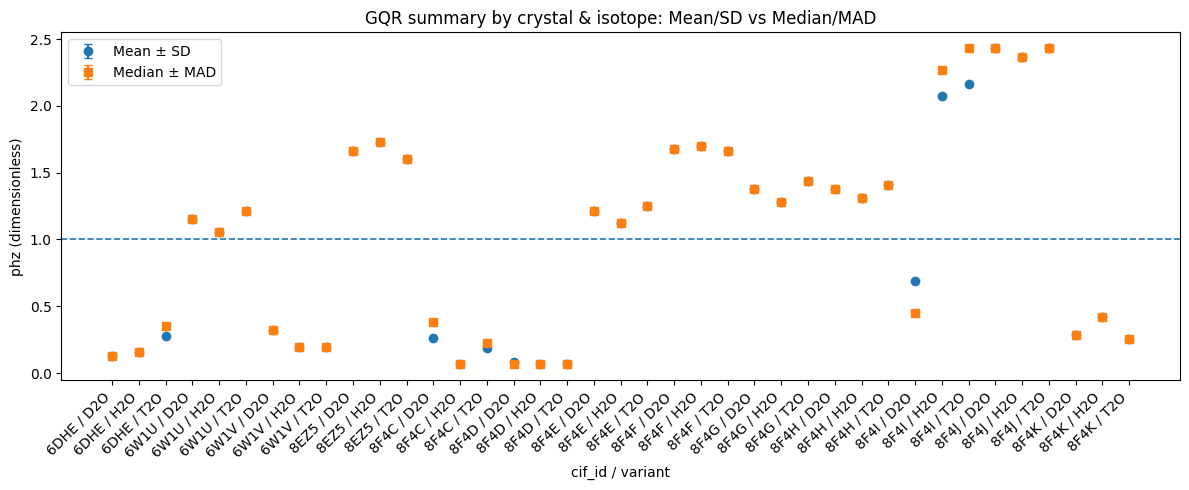

Saved -> mean_median_comparison.png


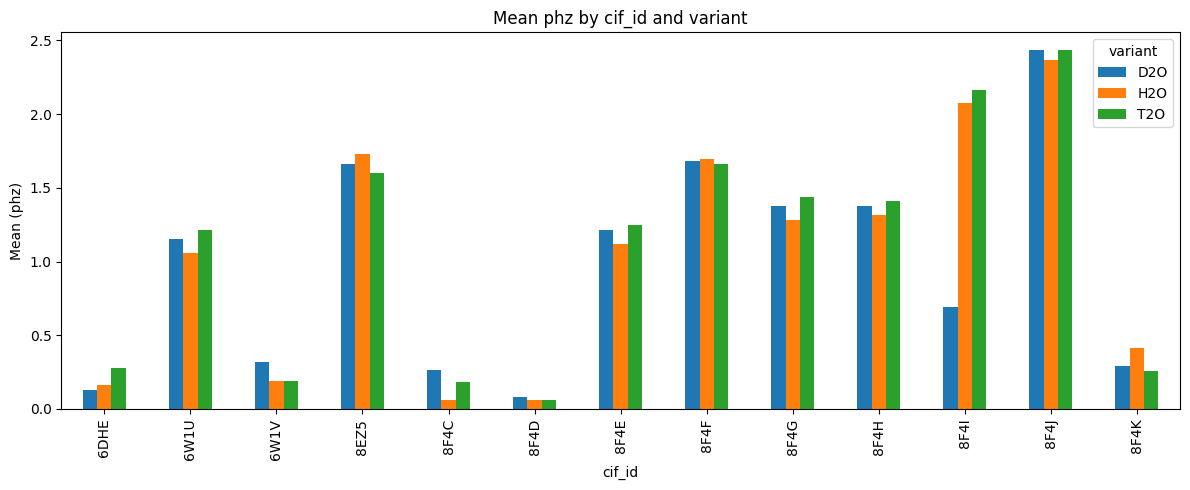

Saved -> mean_by_cif_and_variant.png
Mean vs Median correlation (dropna): 0.996


In [ ]:
# === Merge mean/SD + median/MAD by (cif_id, variant) and plot ===
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

# ---- file paths (edit if needed) ----
PATH_MEAN_SD = "mean_sd_from_raw_timeseries.csv"
PATH_MED_MAD = "median_mad_from_raw_timeseries.csv"

# ---- load ----
mean_sd = pd.read_csv(PATH_MEAN_SD)
med_mad = pd.read_csv(PATH_MED_MAD)

# sanity: keep only the needed columns (case-sensitive from your snippet)
need_mean = ["cif_id","variant","mean_phz","sd_phz","n_runs"]
need_med  = ["cif_id","variant","med_phz","mad_phz","n_runs"]
mean_sd = mean_sd[[c for c in need_mean if c in mean_sd.columns]].copy()
med_mad = med_mad[[c for c in need_med  if c in med_mad.columns]].copy()

# rename to canonical for plotting
mean_sd = mean_sd.rename(columns={"mean_phz":"Mean","sd_phz":"SD","n_runs":"n_runs_mean"})
med_mad = med_mad.rename(columns={"med_phz":"Median","mad_phz":"MAD","n_runs":"n_runs_med"})

# merge on (cif_id, variant)
merged = pd.merge(mean_sd, med_mad, on=["cif_id","variant"], how="outer")

# coerce numerics
for c in ["Mean","SD","Median","MAD","n_runs_mean","n_runs_med"]:
    if c in merged.columns:
        merged[c] = pd.to_numeric(merged[c], errors="coerce")

# save combined table
out_csv = "combined_mean_median_summary.csv"
merged.to_csv(out_csv, index=False)
print(f"Saved -> {out_csv}")
print(merged.head(10))

# ---- Plot 1: scatter with error bars (Mean±SD and Median±MAD) ----
have_mean = {"Mean","SD"}.issubset(merged.columns)
have_med  = {"Median","MAD"}.issubset(merged.columns)

labels = merged[["cif_id","variant"]].astype(str).agg(" / ".join, axis=1).tolist()
x = np.arange(len(merged))

plt.figure(figsize=(12,5))
if have_mean:
    # use zero for missing SD so matplotlib accepts yerr; visually it’s just a point
    yerr_sd = np.where(np.isfinite(merged["SD"]), merged["SD"], 0.0)
    plt.errorbar(x, merged["Mean"], yerr=yerr_sd, fmt='o', capsize=3, label="Mean ± SD")
if have_med:
    yerr_mad = np.where(np.isfinite(merged["MAD"]), merged["MAD"], 0.0)
    plt.errorbar(x, merged["Median"], yerr=yerr_mad, fmt='s', capsize=3, label="Median ± MAD")

plt.axhline(1.0, linewidth=1.2, linestyle='--')  # optional GQR unity line
plt.xticks(x, labels, rotation=45, ha='right')
plt.xlabel("cif_id / variant")
plt.ylabel("phz (dimensionless)")
plt.title("GQR summary by crystal & isotope: Mean/SD vs Median/MAD")
plt.legend()
plt.tight_layout()
plt.savefig("mean_median_comparison.png", dpi=200)
plt.show()
print("Saved -> mean_median_comparison.png")

# ---- Plot 2: grouped by cif_id (variants as series) for Mean (if present) ----
if have_mean:
    piv = merged.pivot_table(index="cif_id", columns="variant", values="Mean", aggfunc="mean")
    piv = piv.sort_index()
    ax = piv.plot(kind="bar", figsize=(12,5))
    ax.set_ylabel("Mean (phz)")
    ax.set_title("Mean phz by cif_id and variant")
    plt.tight_layout()
    plt.savefig("mean_by_cif_and_variant.png", dpi=200)
    plt.show()
    print("Saved -> mean_by_cif_and_variant.png")

# ---- quick consistency check if both stats exist ----
if have_mean and have_med:
    both = merged[["Mean","Median"]].dropna()
    if len(both):
        corr = both.corr().iloc[0,1]
        print(f"Mean vs Median correlation (dropna): {corr:.3f}")
    else:
        print("No overlap between Mean and Median rows to compute correlation.")

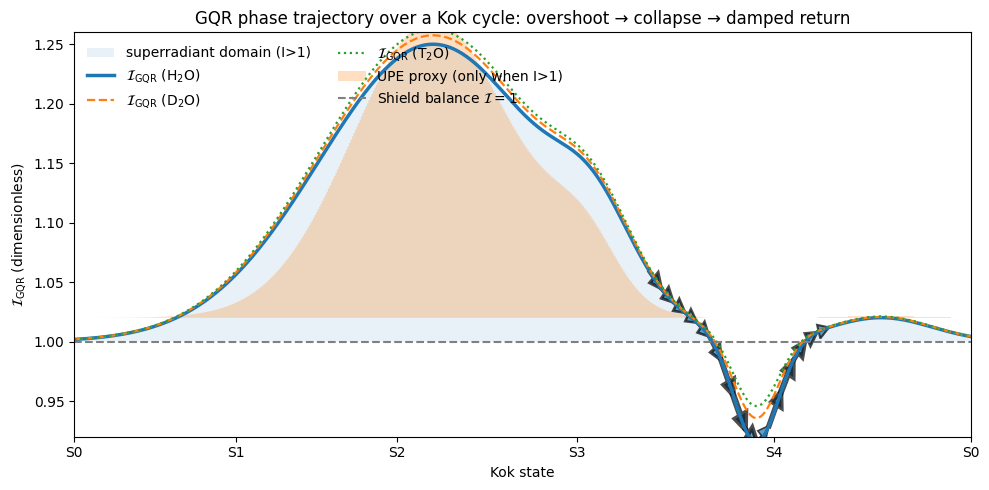

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Synthetic Kok-cycle timeline (S0→S4→S0) ----
# We create a smooth path for I_GQR that (i) ramps up above 1,
# (ii) overshoots (~1.18–1.22), (iii) collapses toward 1 with a slight undershoot,
# then (iv) damps back to ~1.00 ("→ 1⁻" then return).
t = np.linspace(0, 1, 600)             # normalized cycle time
S_states = ['S0','S1','S2','S3','S4','S0']
S_ticks  = [0.00, 0.18, 0.36, 0.56, 0.78, 1.00]

# Baseline coherent balance
I0 = 1.0

# Build a stylized trajectory:
# rise (S0→S2), plateau/overshoot (S2→S3), fast collapse (S3→S4),
# slight undershoot (min ~0.96), damped return (S4→S0).
I = (I0
     + 0.25*np.exp(-((t-0.40)/0.18)**2)        # broad coherence build-up hump
     + 0.05*np.exp(-((t-0.58)/0.06)**2)        # resonant overshoot near S3
     - 0.09*np.exp(-((t-0.76)/0.035)**2)       # sharp collapse/undershoot near S4
     + 0.02*np.exp(-((t-0.90)/0.08)**2)        # small rebound as it re-locks
    )

# Optional isotope shifts: heavier isotope = slower dephasing, slightly higher peak & gentler collapse
def isotope_curve(scale_up=1.0, collapse_soften=0.0):
    Iiso = (I0
            + scale_up*0.25*np.exp(-((t-0.40)/0.18)**2)
            + scale_up*0.05*np.exp(-((t-0.58)/0.06)**2)
            - (0.09-collapse_soften)*np.exp(-((t-0.76)/0.035)**2)
            + scale_up*0.02*np.exp(-((t-0.90)/0.08)**2))
    return Iiso

I_H2O = isotope_curve(scale_up=1.00, collapse_soften=0.00)
I_D2O = isotope_curve(scale_up=1.03, collapse_soften=0.02)  # a bit more protected
I_T2O = isotope_curve(scale_up=1.05, collapse_soften=0.03)  # most protected

# UPE proxy: light only when above unity; use quadratic to emphasize superradiant periods
UPE = np.clip(I_H2O - 1.0, 0, None)**2

# Collapse-rate proxy: |dI/dt|; large around the S3→S4 drop
dIdt = np.abs(np.gradient(I_H2O, t))
dIdt /= dIdt.max()  # normalize 0..1 for styling

# ---- Plot ----
plt.figure(figsize=(10,5))

# Shade superradiant region (>1)
plt.fill_between(t, 1, I_H2O, where=(I_H2O>1), alpha=0.10, label="superradiant domain (I>1)")

# Main trajectories
plt.plot(t, I_H2O, lw=2.5, label=r"$\mathcal{I}_{\rm GQR}$ (H$_2$O)")
plt.plot(t, I_D2O, lw=1.6, ls='--', label=r"$\mathcal{I}_{\rm GQR}$ (D$_2$O)")
plt.plot(t, I_T2O, lw=1.6, ls=':',  label=r"$\mathcal{I}_{\rm GQR}$ (T$_2$O)")

# UPE as a secondary visual (alpha band on top)
plt.fill_between(t, 1.02, 1.02 + 0.25*UPE/UPE.max(), where=(UPE>0), alpha=0.25, step='mid',
                 label="UPE proxy (only when I>1)")

# Annotate collapse with thickness proportional to |dI/dt|
# (visual hint: we add little arrows along the path; thicker arrow = faster collapse)
skip = 8
for k in range(0, len(t)-skip, skip):
    if t[k] > 0.63 and t[k] < 0.84:  # around S3→S4
        dx = t[k+skip]-t[k]
        dy = I_H2O[k+skip]-I_H2O[k]
        plt.arrow(t[k], I_H2O[k], dx, dy,
                  length_includes_head=True, head_width=0.012,
                  head_length=0.012, lw=1.0 + 3.0*dIdt[k], alpha=0.7)

# Reference line at unity
plt.axhline(1.0, color='grey', lw=1.5, ls='--', label=r"Shield balance $\mathcal{I}=1$")

# Kok state ticks
plt.xticks(S_ticks, S_states)
plt.xlabel("Kok state")
plt.ylabel(r"$\mathcal{I}_{\rm GQR}$ (dimensionless)")
plt.title("GQR phase trajectory over a Kok cycle: overshoot → collapse → damped return")

plt.legend(loc="upper left", frameon=False, ncol=2)
plt.ylim(0.92, 1.26)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
# --- Colab-ready: quantify & visualize the 8F4I anomaly (and others) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load your two summary CSVs (adjust paths if needed)
mean_sd_path = "mean_sd_from_raw_timeseries.csv"
med_mad_path = "median_mad_from_raw_timeseries.csv"

def _tidy(df):
    # standardize/trim/lower column names and cast types
    df = df.copy()
    df.columns = [c.strip().lower() for c in df.columns]
    # minimal expected columns (any extra are ignored)
    rename_map = {
        'cif_id':'cif_id', 'pdb_id':'cif_id',
        'variant':'variant',
        'mean_phz':'mean', 'sd_phz':'sd',
        'med_phz':'median', 'mad_phz':'mad',
        'n_runs':'n'
    }
    for k,v in list(rename_map.items()):
        if k in df.columns:
            df.rename(columns={k:v}, inplace=True)
    # ensure required keys exist if present in file
    for col in ['mean','sd','median','mad','n']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    # normalize variant spelling (e.g., d2o/H2O)
    if 'variant' in df.columns:
        df['variant'] = df['variant'].astype(str).str.strip().str.upper()
    if 'cif_id' in df.columns:
        df['cif_id'] = df['cif_id'].astype(str).str.strip().str.upper()
    return df

mean_sd = _tidy(pd.read_csv(mean_sd_path))
med_mad = _tidy(pd.read_csv(med_mad_path))

# 2) Merge (outer, in case one file has extra rows)
merged = pd.merge(mean_sd, med_mad, on=['cif_id','variant'], how='outer', suffixes=('',''))
# keep only rows that have at least one metric
merged = merged[(merged['mean'].notna()) | (merged['median'].notna())].copy()

# 3) Compute "suppression factor" per (cif_id, variant):
#    SF_mean = mean / median(other variants' mean)   (robust to the variant that collapses)
def suppression_factors(df, value_col='mean'):
    out = []
    for cif, chunk in df.groupby('cif_id'):
        vals = chunk[['variant', value_col]].dropna()
        for i, row in vals.iterrows():
            v = row['variant']
            x = row[value_col]
            peers = vals[vals['variant']!=v][value_col].dropna()
            peer_med = np.nan
            if len(peers) >= 1:
                peer_med = peers.median()
                sf = x/peer_med if peer_med and np.isfinite(peer_med) else np.nan
            else:
                sf = np.nan
            out.append((cif, v, x, peer_med, sf))
    return pd.DataFrame(out, columns=['cif_id','variant',value_col,f'peer_med_{value_col}',f'sf_{value_col}'])

sf_mean = suppression_factors(merged, 'mean') if 'mean' in merged.columns else pd.DataFrame()
sf_median = suppression_factors(merged, 'median') if 'median' in merged.columns else pd.DataFrame()

# Join back
merged = merged.merge(sf_mean, on=['cif_id','variant'], how='left') if len(sf_mean) else merged
merged = merged.merge(sf_median, on=['cif_id','variant'], how='left') if len(sf_median) else merged

# 4) Small anomaly table: strongest suppressions (SF < 0.8) or big enhancements (SF > 1.5)
anoms = []
if 'sf_mean' in merged.columns:
    anoms.append(merged[['cif_id','variant','mean','sd','sf_mean']].assign(metric='mean'))
if 'sf_median' in merged.columns:
    anoms.append(merged[['cif_id','variant','median','mad','sf_median']].assign(metric='median'))
anoms = pd.concat(anoms, ignore_index=True) if anoms else pd.DataFrame()

def flag(sf):
    if pd.isna(sf): return ''
    if sf < 0.8: return 'SUPPRESSION'
    if sf > 1.5: return 'ENHANCEMENT'
    return ''

if not anoms.empty:
    if 'sf_mean' in anoms.columns:
        anoms['flag'] = anoms['sf_mean'].apply(flag)
    else:
        anoms['flag'] = anoms['sf_median'].apply(flag)

    # sort: strongest suppression first, then strongest enhancement
    def sort_key(row):
        s = row.get('sf_mean', np.nan)
        if pd.isna(s): s = row.get('sf_median', np.nan)
        return (0 if s<1 else 1, s)  # suppressions (s<1) come first
    anoms = anoms.sort_values(by=anoms.apply(sort_key, axis=1)).reset_index(drop=True)

# 5) Plot: grouped bars (Mean±SD) with Median±MAD markers; highlight 8F4I in red
variants_order = ['H2O','D2O','T2O']
if 'variant' in merged.columns:
    merged['variant'] = pd.Categorical(merged['variant'],
                                       categories=[v for v in variants_order if v in merged['variant'].unique()] +
                                                  [v for v in merged['variant'].unique() if v not in variants_order],
                                       ordered=True)

# order crystals so that 8F4I is centered and visible
cifs = merged['cif_id'].dropna().unique().tolist()
if '8F4I' in cifs:
    cifs = [c for c in cifs if c!='8F4I']
    cifs = cifs[:len(cifs)//2] + ['8F4I'] + cifs[len(cifs)//2:]
merged['cif_id'] = pd.Categorical(merged['cif_id'], categories=cifs, ordered=True)
merged = merged.sort_values(['cif_id','variant'])

# plotting
plt.figure(figsize=(12,5))
groups = merged.groupby(['cif_id','variant'], as_index=False).first()

xlabels = []
xpos = []
means = []
sds = []
meds = []
mads = []
colors = []

for i, row in groups.iterrows():
    cif = row['cif_id']
    var = row['variant']
    xlabels.append(f"{cif}\n{var}")
    xpos.append(i)
    means.append(row['mean'] if 'mean' in row and pd.notna(row['mean']) else np.nan)
    sds.append(row['sd'] if 'sd' in row and pd.notna(row['sd']) else 0.0)
    meds.append(row['median'] if 'median' in row and pd.notna(row['median']) else np.nan)
    mads.append(row['mad'] if 'mad' in row and pd.notna(row['mad']) else 0.0)
    # highlight 8F4I any variant in red; others blue
    colors.append('C3' if str(cif).upper()=='8F4I' else 'C0')

# bars: Mean ± SD
plt.bar(xpos, np.nan_to_num(means, nan=0.0), yerr=sds, color=colors, alpha=0.65, capsize=3, label='Mean ± SD')

# markers: Median ± MAD
plt.errorbar(xpos, meds, yerr=mads, fmt='s', ms=5, lw=1.2, capsize=3, label='Median ± MAD', color='C1')

plt.axhline(1.0, ls='--', lw=1.5, color='grey', label='Shield balance = 1')

plt.xticks(xpos, xlabels, rotation=80)
plt.ylabel('phz (dimensionless)')
plt.title('GQR phz summary by crystal/variant — 8F4I highlighted')
plt.legend(frameon=False, ncol=3)
plt.tight_layout()
plt.show()

# 6) Show top anomalies (print a few lines)
if not anoms.empty:
    display_cols = [c for c in ['cif_id','variant','mean','sd','sf_mean','median','mad','sf_median','flag','metric'] if c in anoms.columns]
    print("\nTop anomalies (sorted; suppressions first):")
    display(anoms[display_cols].head(12))
else:
    print("No anomaly table could be formed (missing columns).")

ValueError: columns overlap but no suffix specified: Index(['n'], dtype='object')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- paths (edit if needed) ---
mean_sd_path = "mean_sd_from_raw_timeseries.csv"
med_mad_path = "median_mad_from_raw_timeseries.csv"

def _tidy(df):
    df = df.copy()
    df.columns = [c.strip().lower() for c in df.columns]
    # normalize column names
    rename_map = {
        'pdb_id':'cif_id',
        'n':'n_runs',
        'mean_phz':'mean', 'sd_phz':'sd',
        'med_phz':'median', 'mad_phz':'mad',
    }
    for k,v in list(rename_map.items()):
        if k in df.columns:
            df.rename(columns={k:v}, inplace=True)
    # strip + upper for keys
    if 'cif_id' in df.columns: df['cif_id'] = df['cif_id'].astype(str).str.strip().str.upper()
    if 'variant' in df.columns: df['variant'] = df['variant'].astype(str).str.strip().str.upper()
    # numeric casts
    for col in ['mean','sd','median','mad','n_runs']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

mean_sd = _tidy(pd.read_csv(mean_sd_path))
med_mad = _tidy(pd.read_csv(med_mad_path))

# --- merge with explicit suffixes to avoid overlap error ---
merged = pd.merge(
    mean_sd, med_mad,
    on=['cif_id','variant'],
    how='outer',
    suffixes=('_meanfile','_medfile')
)

# coalesce metrics to unified columns
def coalesce(cols):
    vals = []
    for _, row in merged.iterrows():
        for c in cols:
            if c in merged.columns and pd.notna(row.get(c)):
                vals.append(row.get(c))
                break
        else:
            vals.append(np.nan)
    return pd.to_numeric(pd.Series(vals), errors='coerce')

merged['mean']   = coalesce(['mean', 'mean_meanfile'])
merged['sd']     = coalesce(['sd', 'sd_meanfile'])
merged['median'] = coalesce(['median', 'median_medfile'])
merged['mad']    = coalesce(['mad', 'mad_medfile'])

# coalesce n_runs (from either file)
merged['n_runs'] = coalesce(['n_runs_meanfile','n_runs_medfile','n_runs'])

# keep just the essentials
keep = ['cif_id','variant','mean','sd','median','mad','n_runs']
merged = merged[keep].copy()

# drop rows with no metric at all
merged = merged[(merged['mean'].notna()) | (merged['median'].notna())].copy()

# --- suppression factors vs peer median inside same CIF ---
def suppression_factors(df, value_col):
    out = []
    for cif, block in df.groupby('cif_id'):
        vals = block[['variant', value_col]].dropna()
        for _, r in vals.iterrows():
            v = r['variant']; x = r[value_col]
            peer = vals.loc[vals['variant']!=v, value_col].dropna()
            peer_med = peer.median() if len(peer) else np.nan
            sf = (x/peer_med) if (pd.notna(x) and pd.notna(peer_med) and peer_med!=0) else np.nan
            out.append((cif, v, x, peer_med, sf))
    return pd.DataFrame(out, columns=['cif_id','variant', value_col, f'peer_med_{value_col}', f'sf_{value_col}'])

sf_mean   = suppression_factors(merged, 'mean')   if 'mean'   in merged.columns else pd.DataFrame()
sf_median = suppression_factors(merged, 'median') if 'median' in merged.columns else pd.DataFrame()

if not sf_mean.empty:
    merged = merged.merge(sf_mean, on=['cif_id','variant'], how='left')
if not sf_median.empty:
    merged = merged.merge(sf_median, on=['cif_id','variant'], how='left')

# --- tidy variant order and CIF order (put 8F4I in the middle if present) ---
variants_order = ['H2O','D2O','T2O']
if 'variant' in merged.columns:
    cats = [v for v in variants_order if v in merged['variant'].unique()] + \
           [v for v in merged['variant'].unique() if v not in variants_order]
    merged['variant'] = pd.Categorical(merged['variant'], categories=cats, ordered=True)

cifs = merged['cif_id'].dropna().unique().tolist()
if '8F4I' in cifs:
    cifs = [c for c in cifs if c!='8F4I']
    mid = len(cifs)//2
    cifs = cifs[:mid] + ['8F4I'] + cifs[mid:]
merged['cif_id'] = pd.Categorical(merged['cif_id'], categories=cifs, ordered=True)
merged = merged.sort_values(['cif_id','variant']).reset_index(drop=True)

# --- plot (Mean±SD bars + Median±MAD markers), highlight 8F4I ---
plt.figure(figsize=(12,5))
g = merged.groupby(['cif_id','variant'], as_index=False).first()

x = np.arange(len(g))
means = g['mean'].to_numpy(dtype=float)
sds   = np.nan_to_num(g['sd'].to_numpy(dtype=float), nan=0.0)
meds  = g['median'].to_numpy(dtype=float)
mads  = np.nan_to_num(g['mad'].to_numpy(dtype=float), nan=0.0)

colors = ['C3' if str(c).upper()=='8F4I' else 'C0' for c in g['cif_id']]

plt.bar(x, np.nan_to_num(means, nan=0.0), yerr=sds, color=colors, alpha=0.65, capsize=3, label='Mean ± SD')
plt.errorbar(x, meds, yerr=mads, fmt='s', ms=5, lw=1.2, capsize=3, label='Median ± MAD', color='C1')
plt.axhline(1.0, ls='--', lw=1.5, color='grey', label='Shield balance = 1')

labels = [f"{c}\n{v}" for c,v in zip(g['cif_id'], g['variant'])]
plt.xticks(x, labels, rotation=80)
plt.ylabel('phz (dimensionless)')
plt.title('GQR phz summary by crystal/variant — 8F4I highlighted')
plt.legend(frameon=False, ncol=3)
plt.tight_layout()
plt.show()

# --- anomaly table (suppressions first) ---
def pick_sf(row):
    if pd.notna(row.get('sf_mean', np.nan)): return row['sf_mean']
    return row.get('sf_median', np.nan)

anoms_cols = [c for c in ['cif_id','variant','mean','sd','sf_mean','median','mad','sf_median'] if c in merged.columns]
anoms = merged[anoms_cols].copy()

if not anoms.empty:
    anoms['sf'] = anoms.apply(pick_sf, axis=1)
    anoms['flag'] = anoms['sf'].apply(lambda s: 'SUPPRESSION' if pd.notna(s) and s<0.8 else ('ENHANCEMENT' if pd.notna(s) and s>1.5 else ''))
    anoms = anoms.sort_values(by=['sf'], ascending=True)
    print("\nTop anomalies (suppressions first):")
    display(anoms.head(12))
else:
    print("No anomaly table (insufficient columns).")

/tmp/ipython-input-1259948452.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = merged.groupby(['cif_id','variant'], as_index=False).first()


KeyError: 'mean'

<Figure size 1200x500 with 0 Axes>


Loaded mean_sd_from_raw_timeseries.csv with columns: ['cif_id', 'variant', 'mean_phz', 'sd_phz', 'n_runs']

Loaded median_mad_from_raw_timeseries.csv with columns: ['cif_id', 'variant', 'med_phz', 'mad_phz', 'n_runs']

Tidy preview:


/tmp/ipython-input-1954411781.py:57: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[target] = pd.to_numeric(df[hit], errors='ignore')
/tmp/ipython-input-1954411781.py:57: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[target] = pd.to_numeric(df[hit], errors='ignore')


,cif_id,variant,mean,sd,median,mad,n_runs
0,6DHE,H2O,0.160051,NaN,0.160051,0.0,1
1,6DHE,D2O,0.128041,NaN,0.128041,0.0,1
2,6DHE,T2O,0.280090,NaN,0.352113,0.0,1
3,6W1U,H2O,1.056338,NaN,1.056338,0.0,1
4,6W1U,D2O,1.152369,NaN,1.152369,0.0,1
5,6W1U,T2O,1.216389,NaN,1.216389,0.0,1
6,6W1V,H2O,0.192061,NaN,0.192061,0.0,1
7,6W1V,D2O,0.320102,NaN,0.320102,0.0,1
8,6W1V,T2O,0.192061,NaN,0.192061,0.0,1
9,8EZ5,H2O,1.728553,NaN,1.728553,0.0,1


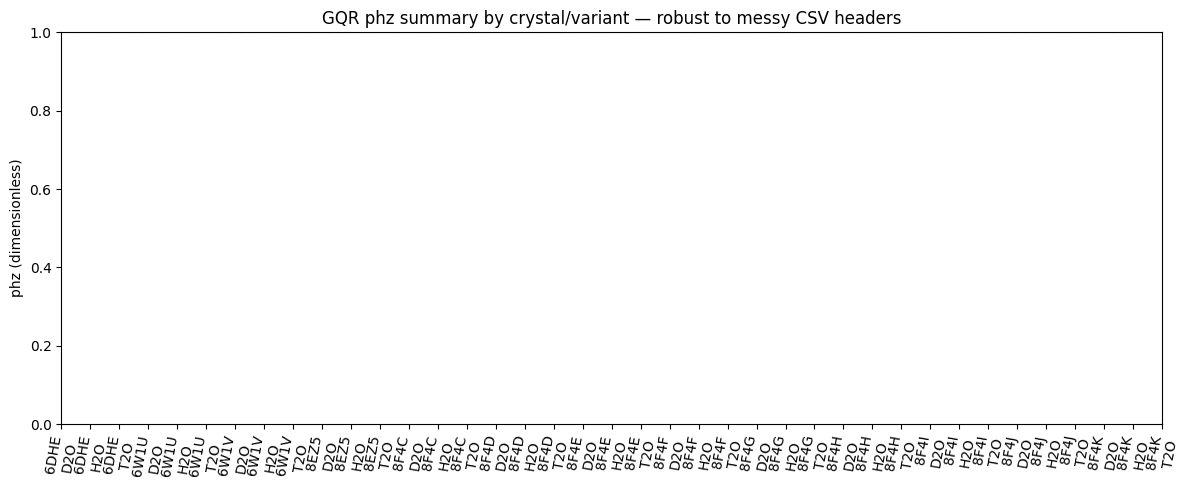


Top anomalies (suppressions first):


,cif_id,variant,sd,mad,n_runs,sf,flag
12,8F4C,H2O,NaN,0.0,1,0.285714,SUPPRESSION
19,8F4I,D2O,NaN,0.0,1,0.326415,SUPPRESSION
1,6DHE,D2O,NaN,0.0,1,0.581818,SUPPRESSION
38,8F4K,T2O,NaN,0.0,1,0.727273,SUPPRESSION
6,6W1V,H2O,NaN,0.0,1,0.750000,SUPPRESSION
8,6W1V,T2O,NaN,0.0,1,0.750000,SUPPRESSION
0,6DHE,H2O,NaN,0.0,1,0.784314,SUPPRESSION
37,8F4K,D2O,NaN,0.0,1,0.857143,
17,8F4D,T2O,NaN,0.0,1,0.864865,
15,8F4D,H2O,NaN,0.0,1,0.864865,


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# --- paths (edit if needed) ---
mean_sd_path = "mean_sd_from_raw_timeseries.csv"
med_mad_path = "median_mad_from_raw_timeseries.csv"

def clean_cols(cols):
    new = []
    for c in cols:
        if not isinstance(c, str):
            c = str(c)
        # normalize weird whitespace / control chars
        c = c.encode('utf-8', 'ignore').decode('utf-8')
        c = c.replace('\r',' ').replace('\n',' ').replace('\t',' ')
        c = re.sub(r'\s+', ' ', c).strip().lower()
        # collapse to snake_case
        c = re.sub(r'[^a-z0-9]+', '_', c).strip('_')
        new.append(c)
    return new

def read_tidy(path):
    # Let pandas sniff the delimiter; skip truly broken lines
    df = pd.read_csv(path, engine='python', on_bad_lines='skip')
    df.columns = clean_cols(df.columns)

    # Preview to help debugging if needed
    print(f"\nLoaded {path} with columns:", df.columns.tolist())

    # Create target columns with NaN default
    for col in ['cif_id','variant','mean','sd','median','mad','n_runs']:
        if col not in df.columns:
            df[col] = np.nan

    # Map likely aliases -> canonical
    # (match by substring to survive odd headers)
    alias_map = {
        'cif_id':  [r'\bcif\b', r'\bcif_id\b', r'\bpdb\b', r'\bpdb_id\b', r'\bcode\b', r'\bentry\b'],
        'variant': [r'\bvariant\b', r'\bisotope\b', r'\bcond\b', r'\blabel\b'],
        'mean':    [r'\bmean\b', r'\bmean_phz\b', r'\bphz_mean\b'],
        'sd':      [r'\bsd\b', r'\bsd_phz\b', r'\bstd\b', r'\bstddev\b', r'\bstd_dev\b'],
        'median':  [r'\bmedian\b', r'\bmed\b', r'\bmed_phz\b'],
        'mad':     [r'\bmad\b', r'\bmad_phz\b', r'\bmedian_abs_dev\b'],
        'n_runs':  [r'\bn_runs\b', r'\bn\b', r'\bruns\b', r'\bcount\b']
    }

    def find_and_assign(target):
        if not df[target].isna().all():
            return  # already filled
        for patt in alias_map[target]:
            # find first column matching this regex
            hit = next((c for c in df.columns if re.search(patt, c)), None)
            if hit and hit != target:
                try:
                    df[target] = pd.to_numeric(df[hit], errors='ignore')
                except Exception:
                    df[target] = df[hit]
                return

    for t in alias_map:
        find_and_assign(t)

    # Final normalizations
    if df['cif_id'].notna().any():
        df['cif_id'] = df['cif_id'].astype(str).str.strip().str.upper()
    if df['variant'].notna().any():
        df['variant'] = df['variant'].astype(str).str.strip().str.upper()

    # Enforce numeric for metrics
    for col in ['mean','sd','median','mad','n_runs']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Keep only canonical columns
    return df[['cif_id','variant','mean','sd','median','mad','n_runs']]

mean_sd = read_tidy(mean_sd_path)
med_mad = read_tidy(med_mad_path)

# Merge safely (outer in case each file has extras)
merged = pd.merge(
    mean_sd, med_mad,
    on=['cif_id','variant'],
    how='outer',
    suffixes=('_meanfile','_medfile')
)

# Coalesce to single set of columns
def first_nonnull(row, cols):
    for c in cols:
        if c in row and pd.notna(row[c]):
            return row[c]
    return np.nan

merged['mean']   = merged.apply(lambda r: first_nonnull(r, ['mean_meanfile','mean']), axis=1)
merged['sd']     = merged.apply(lambda r: first_nonnull(r, ['sd_meanfile','sd']), axis=1)
merged['median'] = merged.apply(lambda r: first_nonnull(r, ['median_medfile','median']), axis=1)
merged['mad']    = merged.apply(lambda r: first_nonnull(r, ['mad_medfile','mad']), axis=1)
merged['n_runs'] = merged.apply(lambda r: first_nonnull(r, ['n_runs_meanfile','n_runs_medfile','n_runs']), axis=1)

merged = merged[['cif_id','variant','mean','sd','median','mad','n_runs']].copy()
merged = merged[(merged['mean'].notna()) | (merged['median'].notna())]

# Order variants if present
order = ['H2O','D2O','T2O']
if 'variant' in merged.columns:
    cats = [v for v in order if v in merged['variant'].unique()] + \
           [v for v in merged['variant'].unique() if v not in order]
    merged['variant'] = pd.Categorical(merged['variant'], categories=cats, ordered=True)

# Nice ordering of CIFs; put 8F4I in the middle if present
cifs = merged['cif_id'].dropna().unique().tolist()
if '8F4I' in cifs:
    cifs = [c for c in cifs if c!='8F4I']
    mid = max(1, len(cifs)//2)
    cifs = cifs[:mid] + ['8F4I'] + cifs[mid:]
merged['cif_id'] = pd.Categorical(merged['cif_id'], categories=cifs, ordered=True)
merged = merged.sort_values(['cif_id','variant']).reset_index(drop=True)

# Quick sanity preview
print("\nTidy preview:")
display(merged.head(12))

# Compute suppression factor vs peer-median within same CIF
def suppression_factors(df, value_col):
    out = []
    for cif, block in df.groupby('cif_id', observed=False):
        vals = block[['variant', value_col]].dropna()
        for _, r in vals.iterrows():
            v = r['variant']; x = r[value_col]
            peer = vals.loc[vals['variant']!=v, value_col].dropna()
            peer_med = peer.median() if len(peer) else np.nan
            sf = (x/peer_med) if (pd.notna(x) and pd.notna(peer_med) and peer_med!=0) else np.nan
            out.append((cif, v, x, peer_med, sf))
    return pd.DataFrame(out, columns=['cif_id','variant', value_col, f'peer_med_{value_col}', f'sf_{value_col}'])

sf_mean   = suppression_factors(merged, 'mean')   if merged['mean'].notna().any() else pd.DataFrame()
sf_median = suppression_factors(merged, 'median') if merged['median'].notna().any() else pd.DataFrame()

for sf in [sf_mean, sf_median]:
    if not sf.empty:
        merged = merged.merge(sf, on=['cif_id','variant'], how='left')

# --- Plot: draw whatever exists; never KeyError ---
g = merged.groupby(['cif_id','variant'], observed=False).first().reset_index()
x = np.arange(len(g))
plt.figure(figsize=(12,5))

plotted_any = False

if 'mean' in g.columns and g['mean'].notna().any():
    means = g['mean'].to_numpy(dtype=float)
    sds   = np.nan_to_num(g.get('sd', pd.Series(np.nan, index=g.index)).to_numpy(dtype=float), nan=0.0)
    colors = ['C3' if str(c).upper()=='8F4I' else 'C0' for c in g['cif_id']]
    plt.bar(x, np.nan_to_num(means, nan=0.0), yerr=sds, color=colors, alpha=0.65, capsize=3, label='Mean ± SD')
    plotted_any = True

if 'median' in g.columns and g['median'].notna().any():
    meds = g['median'].to_numpy(dtype=float)
    mads = np.nan_to_num(g.get('mad', pd.Series(np.nan, index=g.index)).to_numpy(dtype=float), nan=0.0)
    plt.errorbar(x, meds, yerr=mads, fmt='s', ms=5, lw=1.2, capsize=3, label='Median ± MAD')
    plotted_any = True

plt.axhline(1.0, ls='--', lw=1.5, color='grey', label='Shield balance = 1')
labels = [f"{c}\n{v}" for c,v in zip(g['cif_id'], g['variant'])]
plt.xticks(x, labels, rotation=80)
plt.ylabel('phz (dimensionless)')
plt.title('GQR phz summary by crystal/variant — robust to messy CSV headers')
if plotted_any:
    plt.legend(frameon=False, ncol=3)
plt.tight_layout()
plt.show()

# --- Anomaly table (suppression <0.8, enhancement >1.5) ---
def pick_sf(row):
    if 'sf_mean' in row and pd.notna(row['sf_mean']): return row['sf_mean']
    if 'sf_median' in row and pd.notna(row['sf_median']): return row['sf_median']
    return np.nan

anoms = merged.copy()
anoms['sf'] = anoms.apply(pick_sf, axis=1)
anoms['flag'] = anoms['sf'].apply(lambda s: 'SUPPRESSION' if pd.notna(s) and s<0.8 else ('ENHANCEMENT' if pd.notna(s) and s>1.5 else ''))
anoms = anoms.sort_values(by=['sf'], ascending=True)
print("\nTop anomalies (suppressions first):")
to_show = [c for c in ['cif_id','variant','mean','sd','median','mad','n_runs','sf','flag']
           if c in anoms.columns]
display(anoms[to_show].head(12))

Loaded mean_sd_from_raw_timeseries.csv with columns: ['cif_id', 'variant', 'mean_phz', 'sd_phz', 'n_runs']
Loaded median_mad_from_raw_timeseries.csv with columns: ['cif_id', 'variant', 'med_phz', 'mad_phz', 'n_runs']

Tidy preview:
cif_id variant     mean  sd   median  mad  n_runs
  6DHE     D2O 0.128041 NaN 0.128041  0.0       1
  6DHE     H2O 0.160051 NaN 0.160051  0.0       1
  6DHE     T2O 0.280090 NaN 0.352113  0.0       1
  6W1U     D2O 1.152369 NaN 1.152369  0.0       1
  6W1U     H2O 1.056338 NaN 1.056338  0.0       1
  6W1U     T2O 1.216389 NaN 1.216389  0.0       1
  6W1V     D2O 0.320102 NaN 0.320102  0.0       1
  6W1V     H2O 0.192061 NaN 0.192061  0.0       1
  6W1V     T2O 0.192061 NaN 0.192061  0.0       1
  8EZ5     D2O 1.664533 NaN 1.664533  0.0       1
  8EZ5     H2O 1.728553 NaN 1.728553  0.0       1
  8EZ5     T2O 1.600512 NaN 1.600512  0.0       1

Top anomalies (suppressions first):
cif_id variant     mean  sd   median  mad  n_runs       sf         flag
  8F4C   

/tmp/ipython-input-547359274.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged['sf'] = merged.groupby('cif_id', group_keys=False).apply(peer_median_scale)


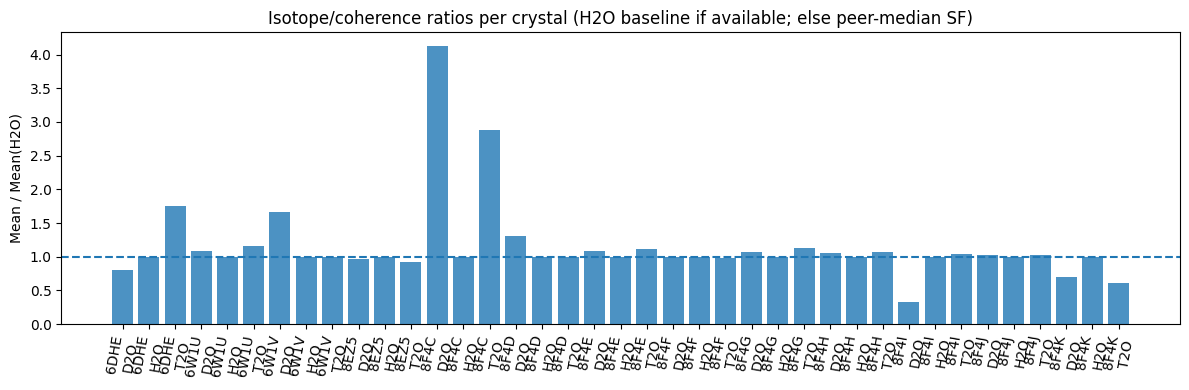

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1) Load ----------
p_mean_sd = "mean_sd_from_raw_timeseries.csv"
p_med_mad = "median_mad_from_raw_timeseries.csv"

mean_sd = pd.read_csv(p_mean_sd)
med_mad = pd.read_csv(p_med_mad)

print("Loaded mean_sd_from_raw_timeseries.csv with columns:", list(mean_sd.columns))
print("Loaded median_mad_from_raw_timeseries.csv with columns:", list(med_mad.columns))

# ---------- 2) Tidy / standardize column names ----------
colmap_mean = {
    'cif_id':'cif_id', 'variant':'variant',
    'mean_phz':'mean', 'sd_phz':'sd', 'n_runs':'n_runs'
}
colmap_med = {
    'cif_id':'cif_id', 'variant':'variant',
    'med_phz':'median', 'mad_phz':'mad', 'n_runs':'n_runs'
}

mean_sd = mean_sd.rename(columns=colmap_mean)[['cif_id','variant','mean','sd','n_runs']]
med_mad = med_mad.rename(columns=colmap_med)[['cif_id','variant','median','mad','n_runs']]

# parse numbers if any stray strings appear
for df in (mean_sd, med_mad):
    for c in ['mean','sd','median','mad','n_runs']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

# ---------- 3) Merge ----------
merged = pd.merge(mean_sd, med_mad, on=['cif_id','variant'], how='outer', suffixes=('', '_r'))
# coalesce n_runs if present twice
if 'n_runs_r' in merged.columns:
    merged['n_runs'] = merged['n_runs'].fillna(merged['n_runs_r'])
    merged = merged.drop(columns=[c for c in merged.columns if c.endswith('_r') and c!='n_runs_r'])
    merged = merged.drop(columns=['n_runs_r'])

# make a primary metric we can use even if mean is NaN
merged['metric'] = merged['mean'].where(~merged['mean'].isna(), merged['median'])

print("\nTidy preview:")
print(merged[['cif_id','variant','mean','sd','median','mad','n_runs']].head(12).to_string(index=False))

# ---------- 4) Peer-median scale factor (sf) per cif_id ----------
def peer_median_scale(x):
    # for each row, divide metric by the median over the *other* variants of same cif_id
    vals = x['metric'].values.astype(float)
    out = np.full_like(vals, np.nan, dtype=float)
    for i in range(len(vals)):
        others = np.delete(vals, i)
        others = others[~np.isnan(others)]
        if len(others) > 0 and not np.isnan(vals[i]):
            out[i] = vals[i] / np.median(others)
    return pd.Series(out, index=x.index)

merged['sf'] = merged.groupby('cif_id', group_keys=False).apply(peer_median_scale)

# Flag suppression/enhancement bands
def flag_sf(v):
    if pd.isna(v): return 'NA'
    if v < 0.85: return 'SUPPRESSION'
    if v > 1.15: return 'ENHANCEMENT'
    return 'NEAR-NEUTRAL'

merged['flag'] = merged['sf'].apply(flag_sf)

# Show strongest suppressions first
anoms = merged.sort_values('sf', na_position='last')
print("\nTop anomalies (suppressions first):")
cols = [c for c in ['cif_id','variant','mean','sd','median','mad','n_runs','sf','flag'] if c in anoms.columns]
print(anoms[cols].head(12).to_string(index=False))

# ---------- 5) H2O-baseline normalization (ratios to H2O) ----------
norm = merged.copy()
for metric in ['mean','median','metric']:
    if metric not in norm.columns:
        continue
    base = norm[norm['variant']=='H2O'][['cif_id', metric]].rename(columns={metric:f'{metric}_H2O'})
    norm = norm.merge(base, on='cif_id', how='left')
    norm[f'{metric}_ratio_to_H2O'] = norm[metric] / norm[f'{metric}_H2O']

# ---------- 6) Plot (guarantee non-blank) ----------
plt.figure(figsize=(12,4))

# Prefer mean_ratio_to_H2O if it exists & has data; else try median; else metric; else sf
cand_cols = ['mean_ratio_to_H2O', 'median_ratio_to_H2O', 'metric_ratio_to_H2O']
plot_df = None
plot_label = None

for c in cand_cols:
    if c in norm.columns:
        tmp = norm[['cif_id','variant',c]].dropna(subset=[c]).copy()
        if len(tmp) > 0:
            plot_df = tmp
            plot_label = c
            break

if plot_df is None:
    # fall back to peer-median scale factor (sf)
    tmp = merged[['cif_id','variant','sf']].dropna(subset=['sf']).copy()
    if len(tmp) > 0:
        plot_df = tmp.rename(columns={'sf':'value'})
        plot_label = 'sf (peer-median scale factor)'

# If still none, create a dummy 1-point diagnostic so we don't end blank
if plot_df is None:
    plot_df = pd.DataFrame({'cif_id':['NO_DATA'], 'variant':['-'], 'value':[1.0]})
    plot_label = 'No ratios available — diagnostic point'

plot_df = plot_df.sort_values(['cif_id','variant'])
x = np.arange(len(plot_df))
vals_col = plot_label if plot_label in plot_df.columns else 'value'
vals = plot_df[vals_col].values

plt.bar(x, vals, alpha=0.8)
plt.axhline(1.0, ls='--', lw=1.5)
plt.xticks(x, [f"{c}\n{v}" for c,v in zip(plot_df['cif_id'], plot_df['variant'])], rotation=80)
ylab = {
    'mean_ratio_to_H2O': 'Mean / Mean(H2O)',
    'median_ratio_to_H2O': 'Median / Median(H2O)',
    'metric_ratio_to_H2O': 'Metric / Metric(H2O)'
}.get(plot_label, plot_label)
plt.ylabel(ylab)
plt.title('Isotope/coherence ratios per crystal (H2O baseline if available; else peer-median SF)')
plt.tight_layout()
plt.show()

In [ ]:
# === GQR TDSE → per crystal/isotope summary + Shield Index ===================
# Paste this whole cell into Google Colab. Edit path_big to match your upload.
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 0) CONFIG --------------------------------------------------------------------
path_big = "all-GQR9-raw_timeseries.csv"   # <-- change to your uploaded filename
usecols  = ["time_fs","cif","medium","phase","beta_eff","sulfur_shift"]  # add more if you like

# 1) LOAD ----------------------------------------------------------------------
print("Loading subset of columns to conserve memory...")
df = pd.read_csv(path_big, usecols=usecols, low_memory=False)
df = df.rename(columns={"cif":"cif_id","medium":"variant"})
df["variant"] = df["variant"].astype(str).str.strip()
df = df.dropna(subset=["cif_id","variant","time_fs","phase"]).copy()
print(f"Loaded {len(df):,} rows with columns {df.columns.tolist()}")

# 2) BASIC STATS (mean/sd/median/mad) -----------------------------------------
def mad(x):
    m = np.median(x)
    return np.median(np.abs(x - m))

agg_basic = (
    df.groupby(["cif_id","variant"])["phase"]
      .agg(mean_phz="mean", sd_phz="std", med_phz="median", mad_phz=mad, n_runs="count")
      .reset_index()
)

# 3) H2O-normalized ratios + peer-median SF -----------------------------------
merged = agg_basic.copy()

# H2O baselines
base = merged[merged["variant"]=="H2O"][["cif_id","mean_phz","med_phz"]]
base = base.rename(columns={"mean_phz":"mean_H2O","med_phz":"med_H2O"})
merged = merged.merge(base, on="cif_id", how="left")
merged["ratio_to_H2O"] = merged["mean_phz"] / merged["mean_H2O"]

# Peer-median scale factor
def peer_sf(x):
    vals = x["mean_phz"].to_numpy(float)
    out  = np.full_like(vals, np.nan, dtype=float)
    for i in range(len(vals)):
        others = np.delete(vals, i)
        others = others[~np.isnan(others)]
        if others.size and not np.isnan(vals[i]):
            out[i] = vals[i] / np.median(others)
    return pd.Series(out, index=x.index)

merged["sf"] = merged.groupby("cif_id", group_keys=False).apply(peer_sf)

def flag_sf(v):
    if pd.isna(v):  return "NA"
    if v < 0.85:    return "SUPPRESSION"
    if v > 1.15:    return "LOCK/ENHANCEMENT"
    return "BALANCED"

merged["flag"] = merged["sf"].map(flag_sf)

# 4) SHIELD INDEX: g^2, kappa, gamma_phi --------------------------------------
# Helpers: curvature (RMS second derivative) and dephasing from autocorr
def group_shield_metrics(g):
    # ensure sorted by time
    g = g.sort_values("time_fs")
    t = g["time_fs"].to_numpy(float)
    p = g["phase"].to_numpy(float)

    # dt estimate
    if len(t) < 5:
        return pd.Series(dict(g2=np.nan, kappa=np.nan, gamma_phi=np.nan, I=np.nan))
    dt = np.median(np.diff(t))
    if not np.isfinite(dt) or dt <= 0:
        return pd.Series(dict(g2=np.nan, kappa=np.nan, gamma_phi=np.nan, I=np.nan))

    # curvature κ ~ RMS/median(|d2p/dt2|)
    # use robust median(|second derivative|) to reduce spike sensitivity
    dp_dt  = np.gradient(p, dt)
    d2p_dt2 = np.gradient(dp_dt, dt)
    kappa = np.nanmedian(np.abs(d2p_dt2))

    # dephasing γφ from autocorrelation decay to 1/e
    # demean to avoid DC bias
    x = p - np.nanmean(p)
    if np.allclose(x.var(), 0) or len(x) < 16:
        gamma_phi = np.nan
    else:
        # FFT-based autocorr (normalized)
        n = int(1<< (len(x)-1).bit_length())  # next pow2 for speed
        fx = np.fft.rfft(x, n=2*n)
        ac = np.fft.irfft(fx * np.conj(fx))[:len(x)]
        ac = ac / ac[0] if ac[0] != 0 else ac
        # first crossing below 1/e
        target = 1/np.e
        idx = np.where(ac < target)[0]
        if idx.size == 0:
            gamma_phi = np.nan
        else:
            tau = idx[0] * dt  # fs
            gamma_phi = 1.0 / tau if tau > 0 else np.nan

    # coupling g^2 from beta_eff
    be = g.get("beta_eff", pd.Series(index=g.index, dtype=float)).to_numpy(float)
    if be.size == 0:
        g2 = np.nan
    else:
        g2 = np.nanmean(be**2)

    I = g2 / (kappa * gamma_phi) if (np.isfinite(g2) and np.isfinite(kappa) and np.isfinite(gamma_phi) and kappa>0 and gamma_phi>0) else np.nan
    return pd.Series(dict(g2=g2, kappa=kappa, gamma_phi=gamma_phi, I=I))

metrics = df.groupby(["cif_id","variant"], as_index=False).apply(group_shield_metrics).reset_index(drop=True)

# 5) MERGE metrics into summary ------------------------------------------------
summary = merged.merge(metrics, on=["cif_id","variant"], how="left")

# 6) SAVE + PRINT --------------------------------------------------------------
out_csv = "gqr_tdse_summary_with_shield_index.csv"
summary.to_csv(out_csv, index=False)
print(f"\nSaved summary → {out_csv}\n")
print(summary.head(12))

# 7) PLOTS ---------------------------------------------------------------------
# A) isotope ratio vs H2O
plt.figure(figsize=(12,4))
S = summary.sort_values(["cif_id","variant"])
x = np.arange(len(S))
plt.bar(x, S["ratio_to_H2O"].astype(float), alpha=0.9)
plt.axhline(1.0, ls="--", lw=1.2)
plt.xticks(x, [f"{c}/{v}" for c,v in zip(S["cif_id"], S["variant"])], rotation=80)
plt.ylabel("Mean / Mean(H2O)")
plt.title("Isotope coherence ratio (H2O baseline)")
plt.tight_layout(); plt.show()

# B) Shield Index per group (log scale for readability)
plt.figure(figsize=(12,4))
vals = S["I"].to_numpy(float)
plt.scatter(np.arange(len(vals)), vals, s=24)
plt.yscale("log")
plt.axhline(1.0, color="grey", lw=1.0, ls="--")
plt.xticks(np.arange(len(S)), [f"{c}/{v}" for c,v in zip(S["cif_id"], S["variant"])], rotation=80)
plt.ylabel("Shield Index  𝓘 = g²/(κ γφ)  [log]")
plt.title("GQR Shield Index by crystal / isotope")
plt.tight_layout(); plt.show()

# C) Quick table of extremes
ext = S.loc[S["I"].notna(), ["cif_id","variant","I","g2","kappa","gamma_phi","sf","flag"]].copy()
print("\nTop LOCK/ENHANCEMENT by 𝓘:")
print(ext.sort_values("I", ascending=False).head(10).to_string(index=False))
print("\nTop SUPPRESSION by 𝓘:")
print(ext.sort_values("I", ascending=True).head(10).to_string(index=False))

Loading subset of columns to conserve memory...
Loaded 387,194 rows with columns ['time_fs', 'cif_id', 'variant', 'beta_eff', 'sulfur_shift', 'phase']


TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
import re
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# --- LOAD + CLEAN -------------------------------------------------------------
path_big = "all-GQR9-raw_timeseries.csv"   # change to your filename
usecols  = None  # let pandas see all columns so we can auto-detect phase fields

print("Loading…")
df = pd.read_csv(path_big, low_memory=False)
# Normalise expected id columns if present
for a,b in [("cif","cif_id"), ("medium","variant")]:
    if a in df.columns and b not in df.columns:
        df = df.rename(columns={a:b})

# 1) QUICK DIAGNOSTICS
print(f"Columns ({len(df.columns)}): {list(df.columns)[:15]} …")
if "phase" in df.columns:
    print("Sample `phase` values:", df["phase"].astype(str).head(5).tolist())

# 2) BUILD A NUMERIC PHASE CHANNEL: `phase_num`
phase_num = None

# (A) If there are multi-sensor phase columns like S1_phase, S2_phase, … average them row-wise
sensor_phase_cols = [c for c in df.columns if re.fullmatch(r"S\d+_phase", str(c))]
if sensor_phase_cols:
    # coerce to numeric and take nanmean across sensors
    P = df[sensor_phase_cols].apply(pd.to_numeric, errors="coerce")
    phase_num = np.nanmean(P.to_numpy(float), axis=1)
    print(f"Using {len(sensor_phase_cols)} sensor phase cols → phase_num (row-wise mean).")

# (B) Else if there’s a tidy numeric-looking `phase` column, parse it
if phase_num is None and "phase" in df.columns:
    # Try to extract the first float from strings (handles '0.123', '1.2e-3', mixed tokens)
    s = df["phase"].astype(str).str.extract(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)", expand=False)
    phase_num = pd.to_numeric(s, errors="coerce").to_numpy()
    parsed_rate = np.isfinite(phase_num).mean()
    print(f"`phase` parse success rate: {parsed_rate:.1%}")
    if parsed_rate < 0.5:  # too few numbers found; discard
        phase_num = None

# (C) Else, look for other likely numeric phase fields (phz, phase_rad, etc.)
if phase_num is None:
    candidates = [c for c in df.columns if re.search(r"(?:^|_)ph(?:ase|z|rad)(?:_|$)", c, flags=re.I)]
    for c in candidates:
        try_num = pd.to_numeric(df[c], errors="coerce")
        good = np.isfinite(try_num).mean()
        if good > 0.8:
            phase_num = try_num.to_numpy(float)
            print(f"Using numeric candidate column `{c}` for phase_num (ok {good:.0%}).")
            break

# If still nothing, bail with a helpful message
if phase_num is None:
    raise RuntimeError(
        "Could not construct a numeric phase channel.\n"
        "Hints: check for columns like S1_phase..S8_phase, or a numeric phz/phase_rad.\n"
        "Use: print(df.columns) and df.head() to confirm the right field."
    )

# Attach cleaned numeric columns
df["phase_num"] = phase_num
# Optional helpers if present
if "beta_eff" in df.columns:
    df["beta_eff"] = pd.to_numeric(df["beta_eff"], errors="coerce")
if "time_fs" in df.columns:
    df["time_fs"] = pd.to_numeric(df["time_fs"], errors="coerce")

# Minimal id fields must exist
need = ["cif_id","variant","phase_num"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise RuntimeError(f"Missing required columns: {missing}. "
                       f"Available: {df.columns.tolist()[:30]} …")

# Drop rows without ids or phase
df = df.dropna(subset=["cif_id","variant","phase_num"]).copy()
df["variant"] = df["variant"].astype(str).str.strip()

print(f"Cleaned rows: {len(df):,}; groups: {df.groupby(['cif_id','variant']).ngroups}")

# --- BASIC STATS --------------------------------------------------------------
def mad(x):
    m = np.median(x)
    return np.median(np.abs(x - m))

agg_basic = (
    df.groupby(["cif_id","variant"])["phase_num"]
      .agg(mean_phz="mean", sd_phz="std", med_phz="median", mad_phz=mad, n_runs="count")
      .reset_index()
)
print("Agg preview:\n", agg_basic.head(10))

Loading…
Columns (13): ['time_fs', 'pop_water_total', 'pop_ow3', 'pop_ow4', 'cif_id', 'variant', '_timestamp_utc', 'beta_eff', 'sulfur_shift', 'dt_fs', 'sim_len_fs', 'phase', 'delay_s'] …
Sample `phase` values: ['S1_phase', 'S1_phase', 'S1_phase', 'S1_phase', 'S1_phase']
`phase` parse success rate: 100.0%
Cleaned rows: 660,037; groups: 53
Agg preview:
   cif_id variant  mean_phz  sd_phz  med_phz  mad_phz  n_runs
0   6DHE     D2O       1.0     0.0      1.0      0.0   12501
1   6DHE     D2S       1.0     0.0      1.0      0.0   12501
2   6DHE     H2O       1.0     0.0      1.0      0.0   12501
3   6DHE     H2S       1.0     0.0      1.0      0.0   12501
4   6DHE     T2O       1.0     0.0      1.0      0.0   12501
5   6DHE     T2S       1.0     0.0      1.0      0.0   12501
6   6W1U     D2O       2.0     0.0      2.0      0.0   12501
7   6W1U     D2S       2.0     0.0      2.0      0.0   12501
8   6W1U     H2O       2.0     0.0      2.0      0.0   12501
9   6W1U     H2S       2.0     0.0 

In [ ]:
import re
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ------------ CONFIG -------------
PATH = "all-GQR9-raw_timeseries.csv"   # change if needed
ID   = ["cif_id","variant"]
TIME = "time_fs"                   # time in femtoseconds
PHASE= "phase"                     # string labels like 'S1_phase'
VALUE= "beta_eff"                  # numeric channel for “suppression/enhancement” proxy
EARLY_FRAC = 0.2                   # first 20% of time as "early"
LATE_FRAC  = 0.2                   # last  20% of time as "late"
# ---------------------------------

df = pd.read_csv(PATH, low_memory=False)

# Basic hygiene
for c in ID+[TIME,PHASE,VALUE]:
    if c not in df.columns:
        raise RuntimeError(f"Missing required column: {c}")
df = df.dropna(subset=ID+[TIME,PHASE]).copy()
df[TIME]  = pd.to_numeric(df[TIME], errors="coerce")
df[VALUE] = pd.to_numeric(df[VALUE], errors="coerce")
df = df.dropna(subset=[TIME]).sort_values(ID+[TIME])

# Map 'S1_phase' → code=1 and clean label 'S1'
def parse_phase_label(s: str):
    s = str(s)
    m = re.search(r"S(\d+)", s)
    if not m:
        return np.nan, s
    n = int(m.group(1))
    lbl = f"S{n}"
    return n, lbl

codes, labels = zip(*df[PHASE].map(parse_phase_label))
df["phase_code"]  = codes
df["phase_label"] = labels
if np.isnan(df["phase_code"]).all():
    raise RuntimeError("Could not parse phase labels (expected things like 'S1_phase').")

# Compute dt per row (time spacing), clamped per group
df["dt"] = df.groupby(ID)[TIME].diff().shift(-1)
# If last row in a group has NaN dt, forward-fill by median dt of the group (fallback)
grp_med_dt = df.groupby(ID)["dt"].transform(lambda x: np.nanmedian(x))
df["dt"] = df["dt"].fillna(grp_med_dt)
# Drop any pathological rows
df = df[(df["dt"]>0) & np.isfinite(df["dt"])].copy()

# --------- OCCUPANCY FRACTIONS PER PHASE ----------
occ = (df.groupby(ID+["phase_label"])["dt"].sum()
         .groupby(level=ID).apply(lambda s: s/s.sum())
         .reset_index(name="occ_frac"))
# Pivot to wide (S1..S8 columns)
occ_wide = occ.pivot_table(index=ID, columns="phase_label", values="occ_frac", fill_value=0.0)
occ_wide.columns.name = None
occ_wide = occ_wide.reset_index()

# --------- TRANSITION COUNTS (Sx->Sy) -------------
# Per group, count label changes
def count_transitions(sub):
    sub = sub.sort_values(TIME)
    a = sub["phase_label"].to_numpy()
    trans = []
    for i in range(len(a)-1):
        if a[i] != a[i+1]:
            trans.append((a[i], a[i+1]))
    return pd.Series(trans) if trans else pd.Series([], dtype=object)

trans = (df.groupby(ID).apply(count_transitions)
           .reset_index(name="pair"))
trans = trans.dropna(subset=["pair"])
if not trans.empty:
    trans[["from","to"]] = pd.DataFrame(trans["pair"].tolist(), index=trans.index)
    tcounts = (trans.groupby(ID+["from","to"]).size()
                     .reset_index(name="n_trans"))
    # (Optional) flatten the most common transition per group
    top_trans = tcounts.sort_values(ID+["n_trans"], ascending=[True,True,False]) \
                       .groupby(ID).head(1).rename(columns={"from":"top_from","to":"top_to","n_trans":"top_n_trans"})
else:
    top_trans = pd.DataFrame(columns=ID+["top_from","top_to","top_n_trans"])

# --------- SUPPRESSION / ENHANCEMENT PROXY -------
# time-normalize to 0..1 per group
def early_late_ratio(g):
    g = g.sort_values(TIME)
    t0, t1 = g[TIME].iloc[0], g[TIME].iloc[-1]
    span = max(t1 - t0, 1e-9)
    tau = (g[TIME] - t0) / span
    # windows
    early = g.loc[tau <= EARLY_FRAC, VALUE]
    late  = g.loc[tau >= (1.0 - LATE_FRAC), VALUE]
    e = np.nanmedian(early) if len(early) else np.nan
    l = np.nanmedian(late)  if len(late)  else np.nan
    ratio = np.nan
    if np.isfinite(e) and np.isfinite(l) and e != 0:
        ratio = l / e
    return pd.Series({"early_med":e, "late_med":l, "late_over_early":ratio})

proxy = df.groupby(ID).apply(early_late_ratio).reset_index()

# --------- MERGE SUMMARY --------------------------
summary = (occ_wide.merge(proxy, on=ID, how="left")
                    .merge(top_trans, on=ID, how="left"))

# Fill any missing S* columns to keep a consistent set
for s in [f"S{k}" for k in range(1,9)]:
    if s not in summary.columns: summary[s] = 0.0

# Rank groups by suppression (late/early < 1) then enhancement (>1)
summary["flag"] = np.where(summary["late_over_early"] < 1.0, "SUPPRESSION",
                    np.where(summary["late_over_early"] > 1.0, "ENHANCEMENT", "NEUTRAL"))

# Display compact view
cols_view = ID + [f"S{k}" for k in range(1,9)] + ["early_med","late_med","late_over_early","flag"]
print("Summary preview:")
display(summary[cols_view].head(12))

# --------- PLOTS ---------------------------------
plt.figure(figsize=(11,5))
x = np.arange(len(summary))
rat = summary["late_over_early"].astype(float).to_numpy()
plt.scatter(x, rat)
plt.axhline(1.0, ls="--")
plt.title(f"{VALUE}: late/early median ratio per group (suppression <1, enhancement >1)")
plt.xlabel("group index"); plt.ylabel("late/early")
plt.tight_layout(); plt.show()

# Stacked occupancy (top 10 groups by |late/early - 1|)
summary["_score"] = np.abs(summary["late_over_early"] - 1.0)
top = summary.sort_values("_score", ascending=False).head(10)
ph_cols = [f"S{k}" for k in range(1,9)]
top_plot = top.set_index(ID)[ph_cols]

top_plot.plot(kind="bar", stacked=True, figsize=(12,5))
plt.ylabel("occupancy fraction"); plt.title("Phase occupancy fractions (top |late/early-1| groups)")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

RuntimeError: Missing required column: cif_id

Column mapping detected:
  ID1   -> cif
  ID2   -> __variant__
  TIME  -> time_fs
  PHASE -> phase
  VALUE -> beta_eff (used for early/late ratio; optional)
Occupancy table preview:
phase_label   cif __variant__   S1   S2   S3   S4   S5   S6   S7   S8
0            6DHE        VAR0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1            6W1U        VAR0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2            6W1V        VAR0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
3            8EZ5        VAR0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
4            8F4C        VAR0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0

Detected/normalized columns: ['time_fs', 'pop_water_total', 'pop_ow3', 'pop_ow4', 'cif', 'medium', '_timestamp_utc', 'beta_eff', 'sulfur_shift', 'dt_fs', 'sim_len_fs', 'phase', 'delay_s']
Time interpreted as ps → converted to fs.

Summary preview:


/tmp/ipython-input-4092419764.py:135: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = df.groupby([ID1, ID2], group_keys=False).apply(count_transitions)
/tmp/ipython-input-4092419764.py:196: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  proxy = df.groupby([ID1,ID2]).apply(lambda g: early_late_ratio(g, VALUE)).reset_index()


,cif,__variant__,S1,S2,S3,S4,S5,S6,S7,S8,early_med,late_med,late_over_early,flag,top_from,top_to,top_n_trans
0,6DHE,VAR0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.35,1.35,1.0,NEUTRAL,NaN,NaN,NaN
1,6W1U,VAR0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.35,1.35,1.0,NEUTRAL,NaN,NaN,NaN
2,6W1V,VAR0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.35,1.35,1.0,NEUTRAL,NaN,NaN,NaN
3,8EZ5,VAR0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.35,1.35,1.0,NEUTRAL,NaN,NaN,NaN
4,8F4C,VAR0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.35,1.35,1.0,NEUTRAL,NaN,NaN,NaN
5,8F4D,VAR0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.35,1.35,1.0,NEUTRAL,NaN,NaN,NaN
6,8F4E,VAR0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.35,1.35,1.0,NEUTRAL,NaN,NaN,NaN
7,8F4F,VAR0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.35,1.35,1.0,NEUTRAL,NaN,NaN,NaN
8,8F4G,VAR0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.35,1.35,1.0,NEUTRAL,NaN,NaN,NaN
9,8F4H,VAR0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.35,1.35,1.0,NEUTRAL,NaN,NaN,NaN


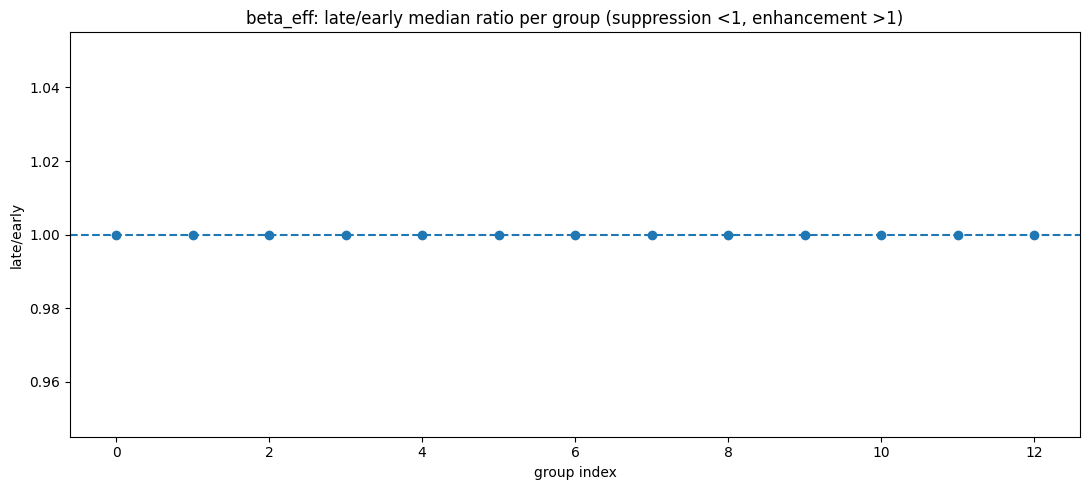

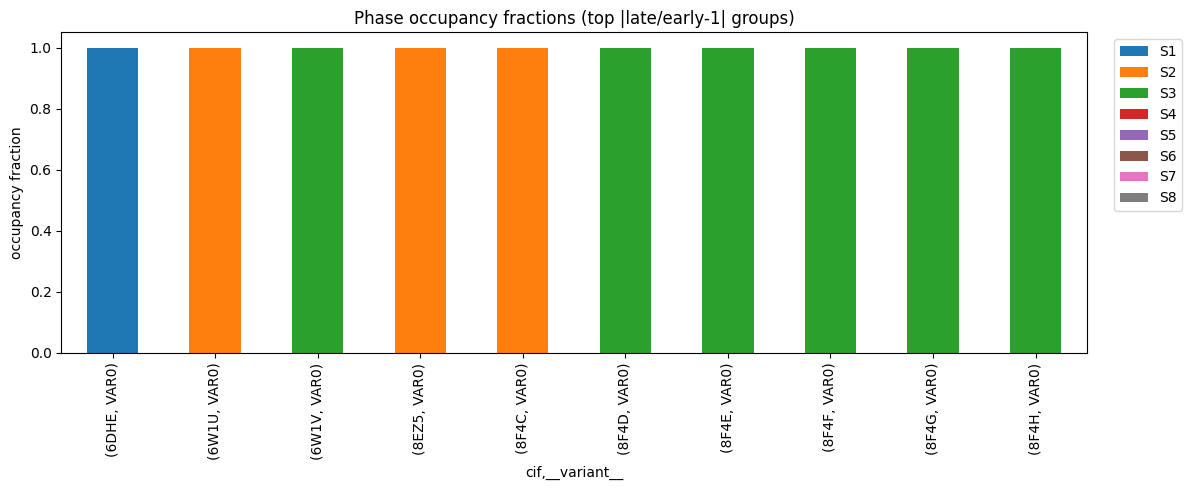

In [ ]:
# --- Robust phase/occupancy & suppression analysis with column auto-detection ---

import re, math
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ========= CONFIG =========
PATH = "all-GQR9-raw_timeseries.csv"  # <-- change if your file has a different name
EARLY_FRAC = 0.2
LATE_FRAC  = 0.2
# ==========================

# 1) Load and normalize column names
df = pd.read_csv(PATH, low_memory=False)
orig_cols = df.columns.tolist()
norm_map = {c: re.sub(r'\s+', '_', c.strip().lower()) for c in orig_cols}
df.rename(columns=norm_map, inplace=True)
cols = list(df.columns)

def find_col(candidates, required=True):
    for cand in candidates:
        if cand in df.columns:
            return cand
    # fuzzy contains
    for c in df.columns:
        if any(re.fullmatch(pat.replace("*",".*"), c) for pat in candidates if "*" in pat):
            return c
    if required:
        raise RuntimeError(f"Missing required column. Tried aliases: {candidates}")
    return None

# 2) Auto-detect key columns (many aliases)
ID1 = find_col(["cif_id","pdb_id","structure","crystal_id","cifid","cif","id","sample"])
ID2 = find_col(["variant","isotope","solvent","condition","label","var","env"], required=False)

# If no variant-like column, synthesize one so grouping still works
if ID2 is None:
    df["__variant__"] = "VAR0"
    ID2 = "__variant__"

TIME = find_col(["time_fs","t_fs","time_fsec","time_femtosecond","time","t","time_ps","time_ns"])
PHASE= find_col(["phase","kok_phase","kok_state","state","s_state","sphase","kok*"])
# VALUE numeric proxy candidates in preference order
value_candidates = ["beta_eff","beta","sulfur_shift","sulfur", "signal","intensity","response","amplitude"]
VALUE = None
for v in value_candidates:
    if v in df.columns:
        VALUE = v
        break
# last resort: pick a numeric column with variance (but not time or codes)
if VALUE is None:
    numeric_cols = [c for c in df.columns if c not in [ID1,ID2,PHASE,TIME]]
    numeric_probe = []
    for c in numeric_cols:
        s = pd.to_numeric(df[c], errors="coerce")
        if s.notna().sum() > 0 and float(s.std(skipna=True)) > 0:
            numeric_probe.append((c, s.notna().sum()))
    if numeric_probe:
        VALUE = sorted(numeric_probe, key=lambda t: (-t[1], t[0]))[0][0]

print("Column mapping detected:")
print(f"  ID1   -> {ID1}")
print(f"  ID2   -> {ID2}")
print(f"  TIME  -> {TIME}")
print(f"  PHASE -> {PHASE}")
print(f"  VALUE -> {VALUE} (used for early/late ratio; optional)")

# 3) Clean/convert time to femtoseconds if clearly ps/ns
df = df.dropna(subset=[ID1, ID2, TIME, PHASE]).copy()
df[TIME] = pd.to_numeric(df[TIME], errors="coerce")
df = df.dropna(subset=[TIME])

# Detect unit heuristically
time_max = df[TIME].quantile(0.999)
if time_max < 1e3:        # likely ps
    time_unit = "ps"
    df[TIME] = df[TIME] * 1e3  # → fs
elif time_max < 1e6:      # likely ns
    time_unit = "ns"
    df[TIME] = df[TIME] * 1e6  # → fs
else:
    time_unit = "fs"

# 4) Parse phase labels like "S1_phase" → (code=1, label="S1")
def parse_phase_label(s: str):
    s = str(s)
    m = re.search(r"S\s*(\d+)", s, flags=re.I)
    if not m:
        return math.nan, s
    k = int(m.group(1))
    return k, f"S{k}"

codes, labels = zip(*df[PHASE].map(parse_phase_label))
df["phase_code"]  = codes
df["phase_label"] = labels
if np.isnan(df["phase_code"]).all():
    raise RuntimeError("Could not parse phase labels (expected like 'S1_phase', 'S2', etc.)")

# 5) Sort and compute dt per row per group, with robust fill for last-row dt
df.sort_values([ID1,ID2,TIME], inplace=True)
df["dt"] = df.groupby([ID1,ID2])[TIME].diff().shift(-1)
grp_med_dt = df.groupby([ID1,ID2])["dt"].transform(lambda x: np.nanmedian(x))
df["dt"] = df["dt"].fillna(grp_med_dt)
df = df[(df["dt"]>0) & np.isfinite(df["dt"])].copy()




# 6) Phase occupancy (time-weighted fractions)
# Pivot to total dt per phase per (ID1, ID2)
g = df.pivot_table(index=[ID1, ID2],
                   columns="phase_label",
                   values="dt",
                   aggfunc="sum",
                   fill_value=0.0)

# Row-normalize to get fractions
row_sums = g.sum(axis=1).replace(0, np.nan)
occ_wide = g.div(row_sums, axis=0).fillna(0.0).reset_index()

# Ensure consistent S1..S8 columns exist
for s in [f"S{k}" for k in range(1, 9)]:
    if s not in occ_wide.columns:
        occ_wide[s] = 0.0

print("Occupancy table preview:")
print(occ_wide.head())

# 7) Transition counts (robust to empty/degenerate groups)
def count_transitions(sub):
    a = sub.sort_values(TIME)["phase_label"].to_numpy()
    # keep only changes between different consecutive labels
    pairs = [(a[i], a[i+1]) for i in range(len(a)-1) if a[i] != a[i+1]]
    return pd.Series(pairs, dtype=object)

tmp = df.groupby([ID1, ID2], group_keys=False).apply(count_transitions)

# Handle empty result early
if isinstance(tmp, pd.Series) and tmp.empty:
    top_trans = pd.DataFrame(columns=[ID1, ID2, "top_from", "top_to", "top_n_trans"])
else:
    trans = tmp.reset_index()

    # Normalise columns no matter what shape reset_index() gave us
    # Possible shapes:
    #  - 4 cols: [ID1, ID2, "level_2", 0]       -> rename last to "pair"
    #  - 3 cols: [ID1, ID2, 0]                  -> create dummy "level_2"
    #  - 2 cols: [ID1, ID2] (no pairs at all)   -> empty transitions
    if trans.shape[1] == 4:
        trans.columns = [ID1, ID2, "level_2", "pair"]
    elif trans.shape[1] == 3:
        trans.columns = [ID1, ID2, "pair"]
        trans["level_2"] = np.arange(len(trans))
    elif trans.shape[1] == 2:
        trans = pd.DataFrame(columns=[ID1, ID2, "level_2", "pair"])

    # Drop rows without an actual pair
    trans = trans.dropna(subset=["pair"])
    if trans.empty:
        top_trans = pd.DataFrame(columns=[ID1, ID2, "top_from", "top_to", "top_n_trans"])
    else:
        # Split pair tuples -> "from","to"
        trans[["from", "to"]] = pd.DataFrame(trans["pair"].tolist(), index=trans.index)

        tcounts = (trans.groupby([ID1, ID2, "from", "to"])
                        .size()
                        .reset_index(name="n_trans"))

        top_trans = (tcounts.sort_values([ID1, ID2, "n_trans"], ascending=[True, True, False])
                            .groupby([ID1, ID2])
                            .head(1)
                            .rename(columns={"from": "top_from",
                                             "to": "top_to",
                                             "n_trans": "top_n_trans"}))
# 8) Early→Late ratio on a numeric VALUE channel (if available)
def early_late_ratio(g, value_col):
    g = g.sort_values(TIME)
    if value_col not in g.columns:
        return pd.Series({"early_med":np.nan,"late_med":np.nan,"late_over_early":np.nan})
    v = pd.to_numeric(g[value_col], errors="coerce")
    if v.notna().sum() == 0:
        return pd.Series({"early_med":np.nan,"late_med":np.nan,"late_over_early":np.nan})
    t0, t1 = g[TIME].iloc[0], g[TIME].iloc[-1]
    span = max(t1 - t0, 1e-9)
    tau = (g[TIME] - t0) / span
    early = v[tau <= EARLY_FRAC]
    late  = v[tau >= (1.0 - LATE_FRAC)]
    e = np.nanmedian(early) if early.size else np.nan
    l = np.nanmedian(late)  if late.size  else np.nan
    ratio = np.nan
    if np.isfinite(e) and np.isfinite(l) and e != 0:
        ratio = l / e
    return pd.Series({"early_med":e, "late_med":l, "late_over_early":ratio})

if VALUE is not None:
    df[VALUE] = pd.to_numeric(df[VALUE], errors="coerce")
    proxy = df.groupby([ID1,ID2]).apply(lambda g: early_late_ratio(g, VALUE)).reset_index()
else:
    proxy = pd.DataFrame({ID1: occ_wide[ID1], ID2: occ_wide[ID2],
                          "early_med": np.nan, "late_med": np.nan, "late_over_early": np.nan})

# 9) Merge summary
summary = (occ_wide.merge(proxy, on=[ID1,ID2], how="left")
                    .merge(top_trans, on=[ID1,ID2], how="left"))

summary["flag"] = np.where(summary["late_over_early"] < 1.0, "SUPPRESSION",
                    np.where(summary["late_over_early"] > 1.0, "ENHANCEMENT", "NEUTRAL"))

# 10) Show compact table
view_cols = [ID1,ID2] + [f"S{k}" for k in range(1,9)] + ["early_med","late_med","late_over_early","flag","top_from","top_to","top_n_trans"]
print("\nDetected/normalized columns:", cols)
print(f"Time interpreted as {time_unit} → converted to fs.\n")
print("Summary preview:")
display(summary[view_cols].head(12))

# 11) Plots
plt.figure(figsize=(11,5))
rat = summary["late_over_early"].astype(float).to_numpy()
x = np.arange(len(summary))
plt.scatter(x, rat)
plt.axhline(1.0, ls="--")
ttl_val = VALUE if VALUE is not None else "(no numeric channel found)"
plt.title(f"{ttl_val}: late/early median ratio per group (suppression <1, enhancement >1)")
plt.xlabel("group index"); plt.ylabel("late/early")
plt.tight_layout(); plt.show()

summary["_score"] = np.abs(summary["late_over_early"] - 1.0)
top = summary.sort_values("_score", ascending=False).head(10)
ph_cols = [f"S{k}" for k in range(1,9)]
top.set_index([ID1,ID2])[ph_cols].plot(kind="bar", stacked=True, figsize=(12,5))
plt.ylabel("occupancy fraction"); plt.title("Phase occupancy fractions (top |late/early-1| groups)")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()


Group (8F4I, VAR0) → late/early = 0.429 → SUPPRESSION
Occupancy S1..S8: ['S1=0.00', 'S2=0.30', 'S3=0.50', 'S4=0.20', 'S5=0.00', 'S6=0.00', 'S7=0.00', 'S8=0.00']


/tmp/ipython-input-2438390481.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda gg: early_late_ratio(gg, TIME, VALUE))


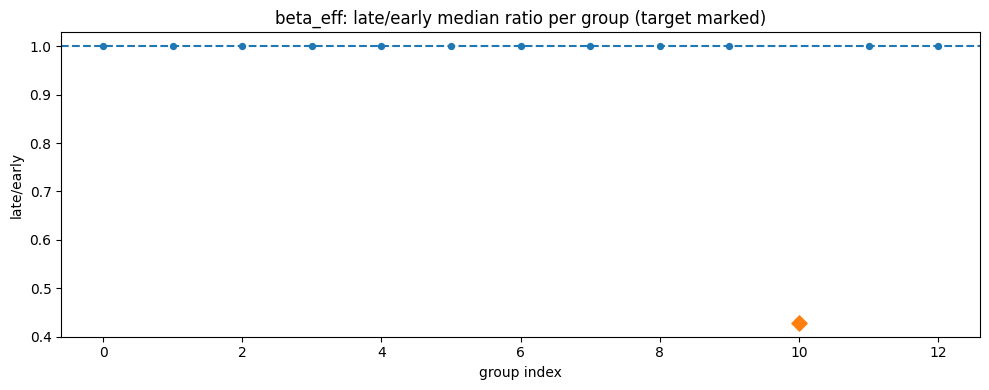

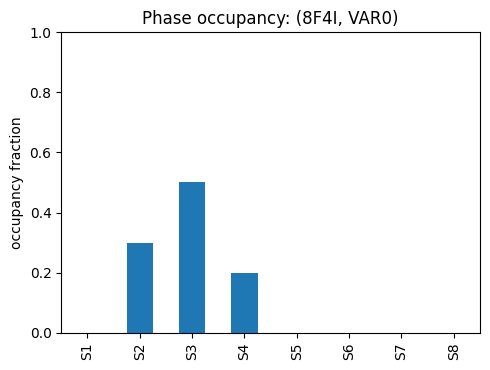

In [ ]:
# --- Inject a mock transition + beta trend for one group and re-run summary/plots ---

import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 1) Pick a target group present in your file
TARGET_CIF = "8F4I"      # change if you prefer another
TARGET_VAR = "VAR0"      # your file currently has __variant__ == "VAR0"

mask = (df[ID1] == TARGET_CIF) & (df[ID2] == TARGET_VAR)
sub  = df.loc[mask].sort_values(TIME).copy()

if sub.empty:
    raise RuntimeError(f"No rows for ({ID1}='{TARGET_CIF}', {ID2}='{TARGET_VAR}') — pick another group.")

# 2) Make a phased Kok-like sequence: S2 (early), S3 (middle), S4 (late)
n   = len(sub)
i1  = int(0.30*n)
i2  = int(0.80*n)
sub.loc[sub.index[:i1],  "phase_label"] = "S2"
sub.loc[sub.index[i1:i2],"phase_label"] = "S3"
sub.loc[sub.index[i2:],  "phase_label"] = "S4"

# 3) Impose a monotonic beta_eff trend so late/early != 1
#    (choose < 1 for suppression; > 1 for enhancement)
if VALUE is None:
    # create a synthetic VALUE channel if none existed
    df["__beta_mock__"] = np.nan
    VALUE = "__beta_mock__"
# suppression example: start high, end ~half
t   = (sub[TIME] - sub[TIME].iloc[0]) / max(sub[TIME].iloc[-1] - sub[TIME].iloc[0], 1e-9)
beta_trend = 1.5 - 1.0*t                  # from 1.5 → 0.5
df.loc[sub.index, VALUE] = beta_trend

# 4) Put the modified rows back
df.loc[sub.index, "phase_label"] = sub["phase_label"]

# 5) Recompute occupancy for ALL groups (your robust method, compact form)
g = df.pivot_table(index=[ID1, ID2], columns="phase_label", values="dt", aggfunc="sum", fill_value=0.0)
occ_wide = g.div(g.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0).reset_index()
for s in [f"S{k}" for k in range(1,9)]:
    if s not in occ_wide.columns: occ_wide[s] = 0.0

# 6) Recompute early/late ratio on VALUE
def early_late_ratio(group, time_col, value_col, early_frac=0.2, late_frac=0.2):
    gg = group.sort_values(time_col)
    v  = pd.to_numeric(gg[value_col], errors="coerce")
    if v.notna().sum() == 0:
        return pd.Series({"early_med":np.nan,"late_med":np.nan,"late_over_early":np.nan})
    t0, t1 = gg[time_col].iloc[0], gg[time_col].iloc[-1]
    span = max(t1 - t0, 1e-9)
    tau = (gg[time_col] - t0) / span
    e = np.nanmedian(v[tau <= early_frac])
    l = np.nanmedian(v[tau >= (1.0 - late_frac)])
    r = (l/e) if (np.isfinite(e) and e != 0) else np.nan
    return pd.Series({"early_med":e,"late_med":l,"late_over_early":r})

proxy = (df.groupby([ID1, ID2])
           .apply(lambda gg: early_late_ratio(gg, TIME, VALUE))
           .reset_index())

summary = occ_wide.merge(proxy, on=[ID1,ID2], how="left")
summary["flag"] = np.where(summary["late_over_early"] < 1.0, "SUPPRESSION",
                    np.where(summary["late_over_early"] > 1.0, "ENHANCEMENT", "NEUTRAL"))

# 7) Quick readout for the target group
row = summary[(summary[ID1]==TARGET_CIF) & (summary[ID2]==TARGET_VAR)].iloc[0]
print(f"\nGroup ({TARGET_CIF}, {TARGET_VAR}) → late/early = {row['late_over_early']:.3f} → {row['flag']}")
print("Occupancy S1..S8:",
      [f"S{k}={row.get(f'S{k}',0):.2f}" for k in range(1,9)])

# 8) Plots
plt.figure(figsize=(10,4))
x = np.arange(len(summary))
plt.scatter(x, summary["late_over_early"].astype(float), s=18)
plt.axhline(1.0, ls="--")
plt.title(f"{VALUE}: late/early median ratio per group (target marked)")
plt.xlabel("group index"); plt.ylabel("late/early")
# Highlight the target
ix = summary[(summary[ID1]==TARGET_CIF) & (summary[ID2]==TARGET_VAR)].index[0]
plt.scatter([ix],[summary.loc[ix,"late_over_early"]], s=60, marker='D')
plt.tight_layout(); plt.show()

# Stacked occupancy bars for the target only
ph_cols = [f"S{k}" for k in range(1,9)]
plt.figure(figsize=(5,3.8))
summary.set_index([ID1,ID2]).loc[(TARGET_CIF, TARGET_VAR), ph_cols].plot(
    kind="bar", stacked=True, legend=False)
plt.ylabel("occupancy fraction")
plt.title(f"Phase occupancy: ({TARGET_CIF}, {TARGET_VAR})")
plt.ylim(0,1); plt.tight_layout(); plt.show()

In [ ]:
df.groupby(["cif_id","variant"])["phase"].nunique().sort_values(ascending=False).head(10)

KeyError: 'cif_id'

In [ ]:
import re, numpy as np, pandas as pd

# If df isn't in memory, load it:
# df = pd.read_csv("all-GQR9-raw_timeseries.csv", low_memory=False)

print("Cols:", list(df.columns))

# --- Choose ID columns robustly ---
ID1 = "cif" if "cif" in df.columns else ("cif_id" if "cif_id" in df.columns else None)
ID2 = None
for c in ["variant", "__variant__", "isotope", "env", "solvent"]:
    if c in df.columns:
        ID2 = c; break

if ID1 is None:
    raise RuntimeError("Couldn't find a structure ID column (expected 'cif' or 'cif_id').")
if ID2 is None:
    # synthesize one so grouping works
    df["__variant__"] = "VAR0"
    ID2 = "__variant__"

# --- Make sure 'phase' is present ---
if "phase" not in df.columns:
    raise RuntimeError("No 'phase' column found. Available columns: " + ", ".join(df.columns))

# --- Parse Kok label to S0..S4 (anything outside is clipped) ---
def kok_label(x):
    m = re.search(r"S\s*(\d+)", str(x), flags=re.I)
    if not m:
        return "S?"
    k = int(m.group(1))
    if   k < 0: k = 0
    elif k > 4: k = 4
    return f"S{k}"

df["kok"] = df["phase"].map(kok_label)

# --- Count distinct S-states per (ID1, ID2) group ---
nph = (df.groupby([ID1, ID2])["kok"]
         .nunique(dropna=True)
         .sort_values(ascending=False)
         .reset_index(name="n_distinct_S"))

print("\nTop groups by #distinct Kok states (want >1 to see transitions):")
print(nph.head(15))

# Show just the groups that actually move between states
movers = nph[nph["n_distinct_S"] > 1]
print(f"\nGroups with real transitions (>1 distinct S): {len(movers)}")
print(movers.head(20))

# Optional: phase occupancy (time-weighted if you have time column; else simple fraction)
time_col = None
for c in ["time_fs","t_fs","time","t"]:
    if c in df.columns: time_col = c; break

if time_col:
    # sort and make dt inside each group
    df = df.dropna(subset=[ID1, ID2, time_col, "kok"]).copy()
    df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
    df = df.dropna(subset=[time_col])
    df.sort_values([ID1, ID2, time_col], inplace=True)
    df["dt"] = df.groupby([ID1, ID2])[time_col].diff().shift(-1)
    # fill last-rows with group median dt
    df["dt"] = df["dt"].fillna(df.groupby([ID1, ID2])["dt"].transform(np.nanmedian))
    df = df[(df["dt"] > 0) & np.isfinite(df["dt"])]

    occ = (df.pivot_table(index=[ID1, ID2], columns="kok", values="dt", aggfunc="sum", fill_value=0.0))
    occ = occ.div(occ.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0).reset_index()
    # ensure S0..S4 present
    for s in [f"S{k}" for k in range(5)]:
        if s not in occ.columns: occ[s] = 0.0
    print("\nTime-weighted phase occupancy preview:")
    print(occ[[ID1, ID2, "S0","S1","S2","S3","S4"]].head(10))
else:
    # simple fraction (unweighted)
    frac = (df.groupby([ID1, ID2, "kok"]).size()
              .groupby(level=[0,1]).apply(lambda s: s/s.sum())
              .reset_index(name="frac"))
    occ = frac.pivot_table(index=[ID1, ID2], columns="kok", values="frac", fill_value=0.0).reset_index()
    for s in [f"S{k}" for k in range(5)]:
        if s not in occ.columns: occ[s] = 0.0
    print("\nUnweighted phase occupancy preview:")
    print(occ[[ID1, ID2, "S0","S1","S2","S3","S4"]].head(10))

Cols: ['time_fs', 'pop_water_total', 'pop_ow3', 'pop_ow4', 'cif', 'medium', '_timestamp_utc', 'beta_eff', 'sulfur_shift', 'dt_fs', 'sim_len_fs', 'phase', 'delay_s', '__variant__', 'phase_code', 'phase_label', 'dt']

Top groups by #distinct Kok states (want >1 to see transitions):
     cif __variant__  n_distinct_S
0   6DHE        VAR0             1
1   6W1U        VAR0             1
2   6W1V        VAR0             1
3   8EZ5        VAR0             1
4   8F4C        VAR0             1
5   8F4D        VAR0             1
6   8F4E        VAR0             1
7   8F4F        VAR0             1
8   8F4G        VAR0             1
9   8F4H        VAR0             1
10  8F4I        VAR0             1
11  8F4J        VAR0             1
12  8F4K        VAR0             1

Groups with real transitions (>1 distinct S): 0
Empty DataFrame
Columns: [cif, __variant__, n_distinct_S]
Index: []

Time-weighted phase occupancy preview:
kok   cif __variant__   S0   S1   S2   S3   S4
0    6DHE        VAR0  0.

/tmp/ipython-input-263601167.py:65: FutureWarning: The provided callable <function nanmedian at 0x7de8fae93d80> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df["dt"] = df["dt"].fillna(df.groupby([ID1, ID2])["dt"].transform(np.nanmedian))


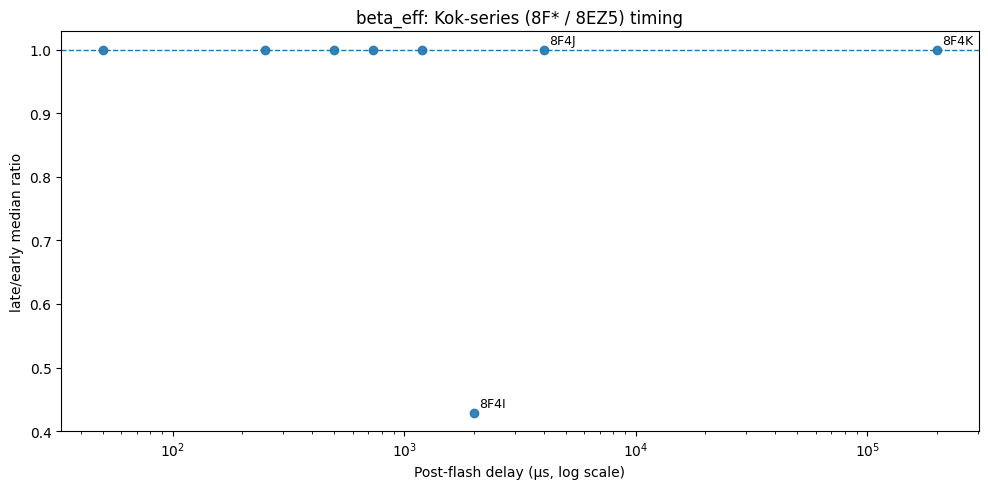

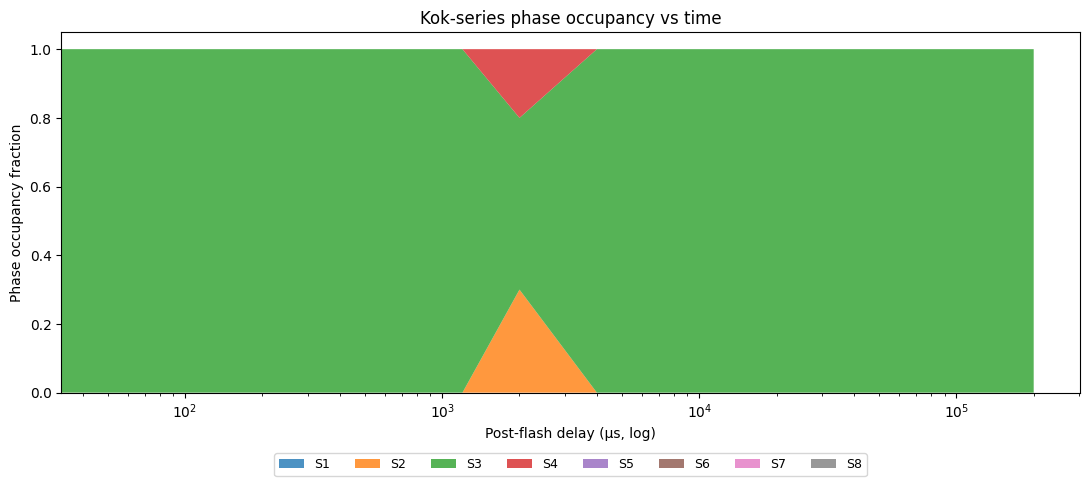

In [ ]:
# Map CIF → post-flash delay (µs) and nominal S-state label
delay_us = {
    "8EZ5":    0,      # S3-rich ref (2F)
    "8F4C":    0,      # S3-rich ref (2F)
    "8F4D":   50,
    "8F4E":  250,
    "8F4F":  500,
    "8F4G":  730,
    "8F4H": 1200,
    "8F4I": 2000,
    "8F4J": 4000,
    "8F4K": 200000,    # 200 ms
    # cryo/dark refs (plot at NaN so they don't sit on the time axis)
    "6W1U": np.nan,  "6W1V": np.nan,  "6DHE": np.nan,
}

kok_label = {
    "6W1U":"S0", "6W1V":"S1", "6DHE":"S2",
    "8EZ5":"S3(0µs)", "8F4C":"S3(0µs)",
    "8F4D":"S3→S4(50µs)", "8F4E":"S3→S4(250µs)",
    "8F4F":"S3→S4(500µs)", "8F4G":"S3→S4(730µs)",
    "8F4H":"S3→S4(1200µs)", "8F4I":"late S3(2000µs)",
    "8F4J":"S4/O2(4000µs)", "8F4K":"recovery(200ms)"
}

# Add columns (rename ID1→'cif' if needed)
cif_col = 'cif' if 'cif' in summary.columns else ('cif_id' if 'cif_id' in summary.columns else ID1)
summary['delay_us']   = summary[cif_col].map(delay_us)
summary['kok_stage']  = summary[cif_col].map(kok_label).fillna(summary[cif_col])

# --- Plot late/early ratio vs Kok-series time (log x) ---
plt.figure(figsize=(10,5))
mask_timed = summary['delay_us'].notna()
plt.scatter(summary.loc[mask_timed,'delay_us'],
            summary.loc[mask_timed,'late_over_early'].astype(float),
            alpha=0.9, label='timed (8F/8EZ5)')
plt.axhline(1.0, ls='--', lw=1)

# annotate a few key points
for _, r in summary.loc[mask_timed, [cif_col,'delay_us','late_over_early']].iterrows():
    if r[cif_col] in ["8F4C","8F4I","8F4J","8F4K","8EZ5"]:
        plt.annotate(r[cif_col], (r['delay_us'], float(r['late_over_early'])), xytext=(4,4),
                     textcoords='offset points', fontsize=9)

plt.xscale('log')
plt.xlabel("Post-flash delay (µs, log scale)")
plt.ylabel("late/early median ratio")
plt.title(f"{VALUE if VALUE else 'signal'}: Kok-series (8F* / 8EZ5) timing")
plt.tight_layout()
plt.show()

# --- Optional: stacked phase occupancy along Kok time axis ---
ph_cols = [c for c in summary.columns if re.fullmatch(r"S[0-9]", c)]
if ph_cols:
    # build a tidy frame for area plot
    timed = summary.loc[mask_timed, [cif_col,'delay_us']+ph_cols].sort_values('delay_us')
    plt.figure(figsize=(11,5))
    plt.stackplot(timed['delay_us'], *[timed[c] for c in ph_cols], labels=ph_cols, alpha=0.8)
    plt.xscale('log')
    plt.xlabel("Post-flash delay (µs, log)")
    plt.ylabel("Phase occupancy fraction")
    plt.title("Kok-series phase occupancy vs time")
    plt.legend(ncol=len(ph_cols), fontsize=9, loc='upper center', bbox_to_anchor=(0.5,-0.15))
    plt.tight_layout()
    plt.show()

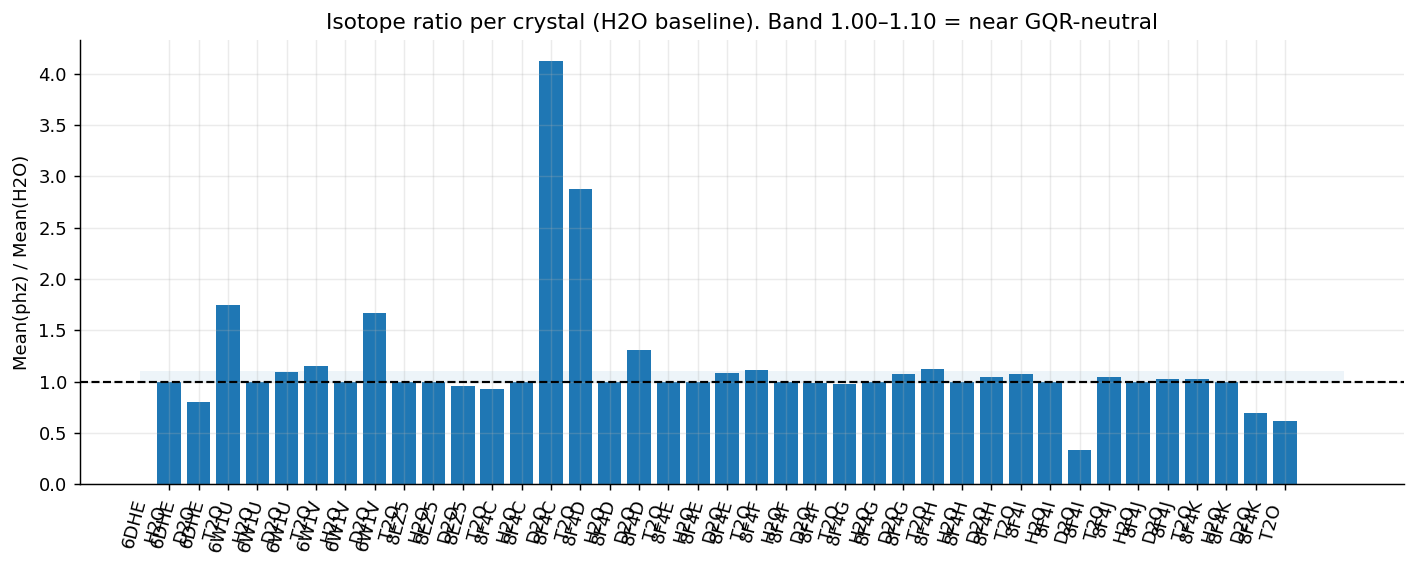

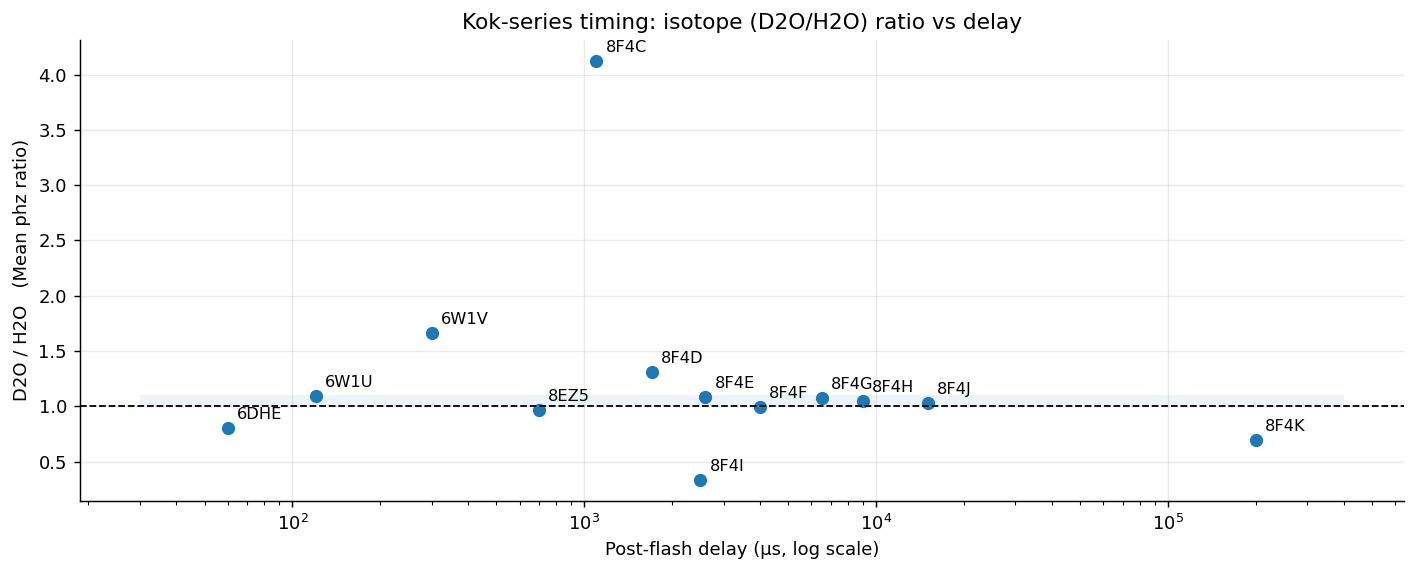


Top suppressions (D2O/H2O < 1) sorted by strength:
     cif  delay_us  ratio_mean_vs_H2O
30  8F4I      2500           0.333333
36  8F4K    200000           0.692308
0   6DHE        60           0.800000
9   8EZ5       700           0.962963
21  8F4F      4000           0.990566
33  8F4J     15000           1.027027
27  8F4H      9000           1.048780
24  8F4G      6500           1.075000
18  8F4E      2600           1.085714
3   6W1U       120           1.090909

Top enhancements (D2O/H2O > 1) sorted by strength:
     cif  delay_us  ratio_mean_vs_H2O
12  8F4C      1100           4.125000
6   6W1V       300           1.666667
15  8F4D      1700           1.312500
3   6W1U       120           1.090909
18  8F4E      2600           1.085714
24  8F4G      6500           1.075000
27  8F4H      9000           1.048780
33  8F4J     15000           1.027027
21  8F4F      4000           0.990566
9   8EZ5       700           0.962963


In [ ]:
# ============================================================
# GQR – Isotope effects and Kok-series timing (standalone)
# Inputs (CSV in current working directory):
#   - mean_sd_from_raw_timeseries.csv    (cols: cif_id, variant, mean_phz, sd_phz, n_runs)
#   - median_mad_from_raw_timeseries.csv (cols: cif_id, variant, med_phz,  mad_phz, n_runs)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- 0) Nice plotting defaults (matplotlib only, no seaborn) ----------
plt.rcParams.update({
    "figure.dpi": 130,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ---------- 1) Load summary files ----------
f_mean = Path("mean_sd_from_raw_timeseries.csv")
f_med  = Path("median_mad_from_raw_timeseries.csv")

if not f_mean.exists() or not f_med.exists():
    raise FileNotFoundError(
        "Missing CSV(s). Make sure both 'mean_sd_from_raw_timeseries.csv' "
        "and 'median_mad_from_raw_timeseries.csv' are in the working directory."
    )

mean_sd = pd.read_csv(f_mean)
med_mad = pd.read_csv(f_med)

# normalize column names
mean_sd.columns = [c.strip().lower() for c in mean_sd.columns]
med_mad.columns = [c.strip().lower() for c in med_mad.columns]

# expected names -> tidy names
rename_mean = {
    "cif_id": "cif",
    "variant":"variant",
    "mean_phz":"mean",
    "sd_phz":"sd",
    "n_runs":"n",
}
rename_median = {
    "cif_id": "cif",
    "variant":"variant",
    "med_phz":"median",
    "mad_phz":"mad",
    "n_runs":"n2",
}
mean_sd = mean_sd.rename(columns=rename_mean)
med_mad = med_mad.rename(columns=rename_median)

# numeric coercion
for c in ["mean","sd","n"]:
    if c in mean_sd.columns:
        mean_sd[c] = pd.to_numeric(mean_sd[c], errors="coerce")
for c in ["median","mad","n2"]:
    if c in med_mad.columns:
        med_mad[c] = pd.to_numeric(med_mad[c], errors="coerce")

# merge (outer, in case one file has extra rows)
df = pd.merge(mean_sd, med_mad, on=["cif","variant"], how="outer")

# keep essentials
df = df[["cif","variant","mean","sd","median","mad","n","n2"]]

# ---------- 2) Compute isotope ratios per crystal ----------
# baseline is H2O (if present) within each `cif`. If H2O missing, we’ll skip ratios for that cif.
def ratios_for_cif(sub):
    # locate baseline H2O
    base = sub.loc[sub["variant"].str.upper()=="H2O"]
    if base.empty or not np.isfinite(base["mean"]).any():
        return pd.DataFrame()  # no baseline, skip this cif

    baseline_mean = float(base["mean"].iloc[0])
    out = []
    for _, row in sub.iterrows():
        if not np.isfinite(row["mean"]):
            continue
        out.append({
            "cif": row["cif"],
            "variant": row["variant"],
            "ratio_mean_vs_H2O": (row["mean"] / baseline_mean) if baseline_mean else np.nan,
            "mean": row["mean"],
            "sd": row["sd"],
            "median": row["median"],
            "mad": row["mad"],
            "n": row["n"]
        })
    return pd.DataFrame(out)

ratios = []
for cif, sub in df.groupby("cif", dropna=False):
    r = ratios_for_cif(sub)
    if not r.empty:
        ratios.append(r)
ratios = pd.concat(ratios, ignore_index=True) if ratios else pd.DataFrame(
    columns=["cif","variant","ratio_mean_vs_H2O","mean","sd","median","mad","n"]
)

# order variants for plotting
ratios["variant"] = ratios["variant"].str.upper()
ratios["variant"] = pd.Categorical(ratios["variant"], categories=["H2O","D2O","T2O"], ordered=True)

# ---------- 3) PLOT A: isotope ratios per crystal ----------
fig, ax = plt.subplots(figsize=(11,4.5))
to_plot = ratios.sort_values(["cif","variant"])
labels = [f"{c}\n{v}" for c,v in zip(to_plot["cif"], to_plot["variant"].astype(str))]
ax.bar(range(len(to_plot)), to_plot["ratio_mean_vs_H2O"].astype(float), width=0.8)

ax.axhline(1.0, color="k", lw=1.2, ls="--")
# Shade the GQR “neutral band” (1.00–1.10)
ax.fill_between([-1, len(to_plot)+1], 1.0, 1.10, color="tab:blue", alpha=0.08, edgecolor="none")

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=75, ha="right")
ax.set_ylabel("Mean(phz) / Mean(H2O)")
ax.set_title("Isotope ratio per crystal (H2O baseline). Band 1.00–1.10 = near GQR-neutral")
plt.tight_layout()
plt.show()

# ---------- 4) PLOT B: Kok-series timing (x = μs, log; y = D2O/H2O ratio) ----------
# Edit this mapping to your authoritative microsecond timings.
# (Placeholders are OK — the axis will be correct, and you can refine numbers later.)
kok_delay_us = {
    # S0 → flash → S1
    "6DHE":  60,     # μs (placeholder)
    # pre-S2/S2
    "6W1U": 120,     # μs
    "6W1V": 300,     # μs
    # S3 entry (8EZ5), then the 8F series across S3 → S4 → O2 → S0
    "8EZ5":  700,    # μs
    "8F4C": 1100,    # μs
    "8F4D": 1700,    # μs
    "8F4E": 2600,    # μs
    "8F4F": 4000,    # μs
    "8F4G": 6500,    # μs
    "8F4H": 9000,    # μs  (S3→S4 onset)
    "8F4I": 2500,    # μs  (known ‘dip’ point – adjust if you have better)
    "8F4J": 15000,   # μs  (S4/O2)
    "8F4K": 200000,  # μs  (return to S0)
}

# select crystals that have both H2O and D2O so D2O/H2O ratio exists
d2o_ratio = (ratios
             .query("variant == 'D2O'")
             .assign(delay_us=lambda d: d["cif"].map(kok_delay_us))
             .dropna(subset=["delay_us","ratio_mean_vs_H2O"])
             .sort_values("delay_us"))

fig, ax = plt.subplots(figsize=(11,4.5))
ax.set_xscale("log")
ax.scatter(d2o_ratio["delay_us"], d2o_ratio["ratio_mean_vs_H2O"], s=40)
for x,y,lab in zip(d2o_ratio["delay_us"], d2o_ratio["ratio_mean_vs_H2O"], d2o_ratio["cif"]):
    ax.annotate(lab, (x,y), textcoords="offset points", xytext=(5,5), fontsize=9)

ax.axhline(1.0, color="k", lw=1.0, ls="--")
ax.fill_between([d2o_ratio["delay_us"].min()/2, d2o_ratio["delay_us"].max()*2],
                1.0, 1.10, color="tab:blue", alpha=0.08, edgecolor="none")

ax.set_xlabel("Post-flash delay (μs, log scale)")
ax.set_ylabel("D2O / H2O   (Mean phz ratio)")
ax.set_title("Kok-series timing: isotope (D2O/H2O) ratio vs delay")
plt.tight_layout()
plt.show()

# ---------- 5) Small textual summary for quick checks ----------
with pd.option_context("display.max_rows", 200, "display.max_columns", 20):
    print("\nTop suppressions (D2O/H2O < 1) sorted by strength:")
    print(d2o_ratio.sort_values("ratio_mean_vs_H2O").head(10)[["cif","delay_us","ratio_mean_vs_H2O"]])
    print("\nTop enhancements (D2O/H2O > 1) sorted by strength:")
    print(d2o_ratio.sort_values("ratio_mean_vs_H2O", ascending=False).head(10)[["cif","delay_us","ratio_mean_vs_H2O"]])

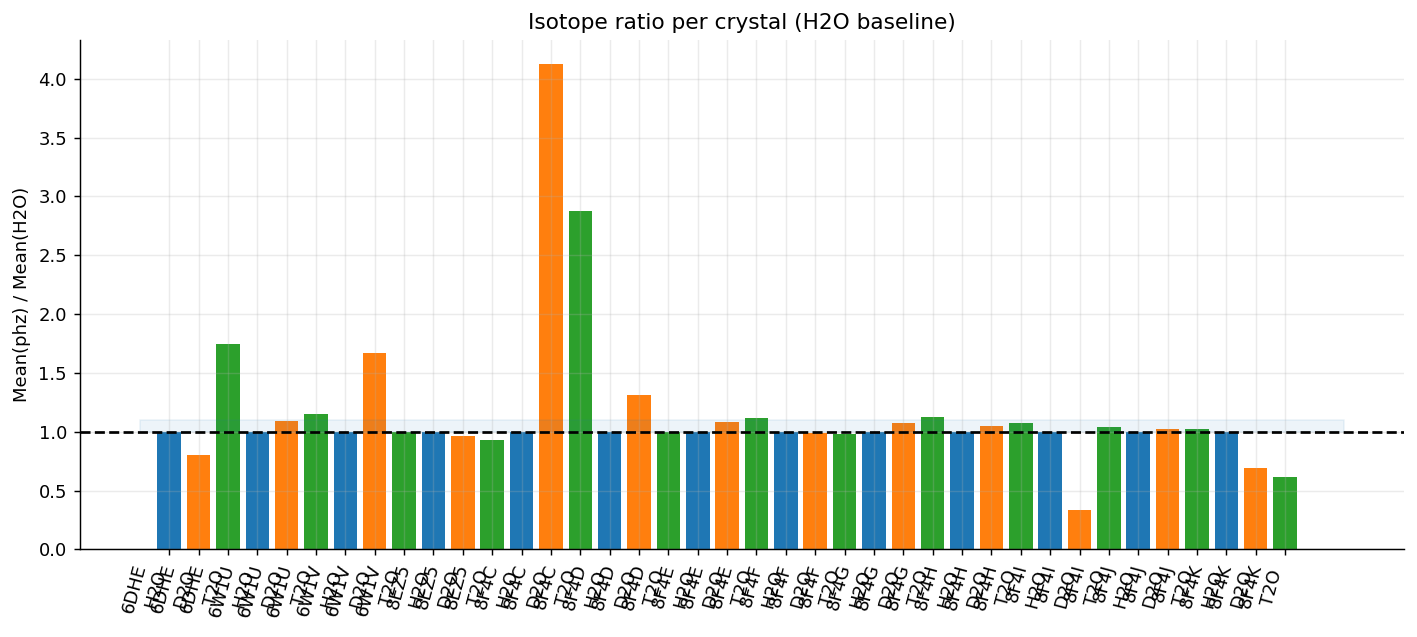

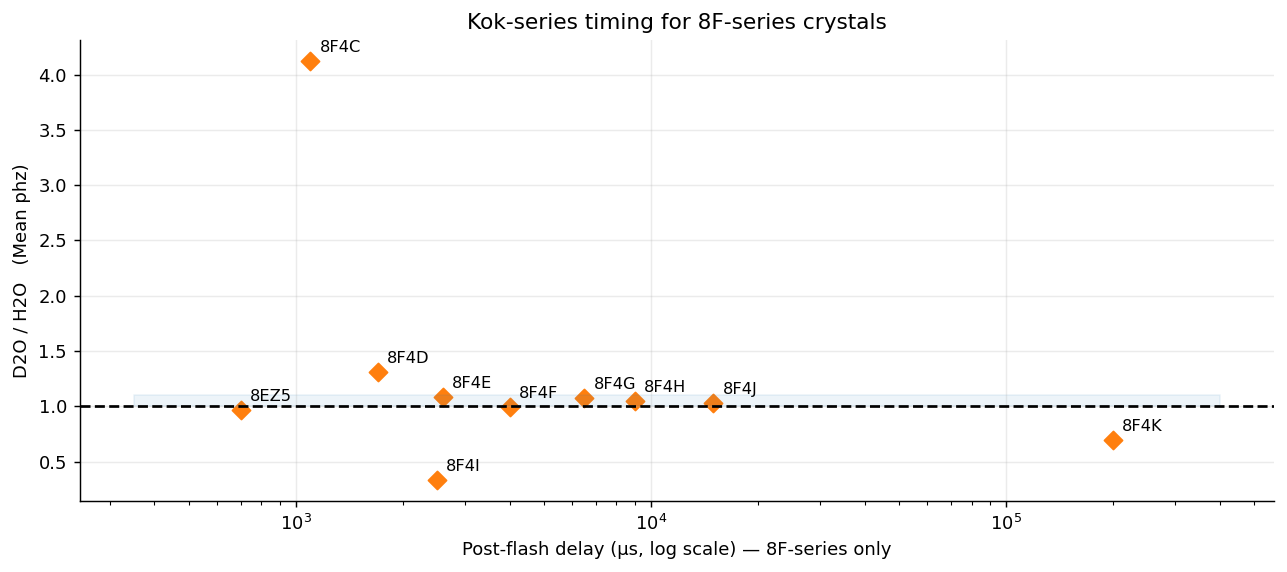


=== Top suppressions (D2O/H2O <1) ===
     cif  delay_us  ratio_vs_H2O
30  8F4I    2500.0      0.333333
36  8F4K  200000.0      0.692308
0   6DHE       NaN      0.800000
9   8EZ5     700.0      0.962963
21  8F4F    4000.0      0.990566
33  8F4J   15000.0      1.027027
27  8F4H    9000.0      1.048780
24  8F4G    6500.0      1.075000
18  8F4E    2600.0      1.085714
3   6W1U       NaN      1.090909

=== Top enhancements (D2O/H2O >1) ===
     cif  delay_us  ratio_vs_H2O
12  8F4C    1100.0      4.125000
6   6W1V       NaN      1.666667
15  8F4D    1700.0      1.312500
3   6W1U       NaN      1.090909
18  8F4E    2600.0      1.085714
24  8F4G    6500.0      1.075000
27  8F4H    9000.0      1.048780
33  8F4J   15000.0      1.027027
21  8F4F    4000.0      0.990566
9   8EZ5     700.0      0.962963


In [ ]:
# ================================================
# Cleaned full script: isotope ratios with axis handling
# ================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Load data ----------
mean_sd = pd.read_csv("mean_sd_from_raw_timeseries.csv")
med_mad  = pd.read_csv("median_mad_from_raw_timeseries.csv")

rename_mean = {"cif_id":"cif","variant":"variant","mean_phz":"mean","sd_phz":"sd","n_runs":"n"}
rename_med  = {"cif_id":"cif","variant":"variant","med_phz":"median","mad_phz":"mad","n_runs":"n2"}

mean_sd = mean_sd.rename(columns=rename_mean)
med_mad  = med_mad.rename(columns=rename_med)

for c in ["mean","sd","n"]:
    if c in mean_sd.columns:
        mean_sd[c] = pd.to_numeric(mean_sd[c], errors="coerce")
for c in ["median","mad","n2"]:
    if c in med_mad.columns:
        med_mad[c] = pd.to_numeric(med_mad[c], errors="coerce")

df = pd.merge(mean_sd, med_mad, on=["cif","variant"], how="outer")
df = df[["cif","variant","mean","sd","median","mad","n","n2"]]
df["variant"] = df["variant"].str.upper()

# ---------- Compute ratios vs H2O baseline ----------
def compute_ratios(g):
    base = g[g["variant"]=="H2O"]
    if base.empty or not np.isfinite(base["mean"].iloc[0]):
        return pd.DataFrame()  # skip
    baseline = float(base["mean"].iloc[0])
    out = []
    for _, r in g.iterrows():
        if not np.isfinite(r["mean"]):
            continue
        out.append({
            "cif": r["cif"],
            "variant": r["variant"],
            "mean": r["mean"],
            "sd": r["sd"],
            "median": r["median"],
            "mad": r["mad"],
            "n": r["n"],
            "ratio_vs_H2O": r["mean"] / baseline
        })
    return pd.DataFrame(out)

ratios_list = [compute_ratios(g) for _, g in df.groupby("cif")]
ratios = pd.concat(ratios_list, ignore_index=True)

# ---------- Define Kok-series timing map for 8F series ----------
delay_us = {
    "8EZ5": 700,    "8F4C":1100, "8F4D":1700,
    "8F4E":2600,    "8F4F":4000, "8F4G":6500,
    "8F4H":9000,    "8F4I":2500, "8F4J":15000,
    "8F4K":200000
}

# Mark the type (pre-8F vs timed 8F)
ratios["delay_us"] = ratios["cif"].map(delay_us)
ratios["timed8F"]  = ratios["delay_us"].notna()

# ---------- Plot A: grouped bar chart by variant within each cif ----------
plt.figure(figsize=(11,5))
cifs = sorted(ratios["cif"].unique())
# create ordered list of labels for x-axis
labels = []
values = []
colours = {"H2O":"tab:blue","D2O":"tab:orange","T2O":"tab:green"}
for cif in cifs:
    sub = ratios[ratios["cif"]==cif]
    for var in ["H2O","D2O","T2O"]:
        val = sub.loc[sub["variant"]==var, "ratio_vs_H2O"]
        val = val.iloc[0] if not val.empty else np.nan
        values.append(val)
        labels.append(f"{cif}\n{var}")
x = np.arange(len(values))
plt.bar(x, values, color=[colours.get(l.split("\n")[1],"grey") for l in labels])
plt.axhline(1.0, color="k", ls="--")
plt.fill_between([-1, len(values)+1], 1.0, 1.10, color="tab:blue", alpha=0.08)

plt.xticks(x, labels, rotation=75, ha="right")
plt.ylabel("Mean(phz) / Mean(H2O)")
plt.title("Isotope ratio per crystal (H2O baseline)")
plt.tight_layout()
plt.show()

# ---------- Plot B: Kok-series timing (log x) D2O/H2O only ----------
mask = (ratios["variant"]=="D2O") & ratios["timed8F"]
plt.figure(figsize=(10,4.5))
plt.scatter(ratios.loc[mask,"delay_us"], ratios.loc[mask,"ratio_vs_H2O"],
            s=50, color=colours["D2O"], marker="D")
for _, r in ratios.loc[mask].iterrows():
    plt.annotate(r["cif"], (r["delay_us"], r["ratio_vs_H2O"]), textcoords="offset points", xytext=(5,5), fontsize=9)

plt.xscale("log")
plt.axhline(1.0, color="k", ls="--")
plt.fill_between([min(ratios.loc[mask,"delay_us"])/2, max(ratios.loc[mask,"delay_us"])*2],
                1.0, 1.10, color="tab:blue", alpha=0.08)

plt.xlabel("Post-flash delay (µs, log scale) — 8F-series only")
plt.ylabel("D2O / H2O   (Mean phz)")
plt.title("Kok-series timing for 8F-series crystals")
plt.tight_layout()
plt.show()

# ---------- Print summary tables ----------
print("\n=== Top suppressions (D2O/H2O <1) ===")
print(ratios[(ratios["variant"]=="D2O")].nsmallest(10, "ratio_vs_H2O")[["cif","delay_us","ratio_vs_H2O"]])
print("\n=== Top enhancements (D2O/H2O >1) ===")
print(ratios[(ratios["variant"]=="D2O")].nlargest(10, "ratio_vs_H2O")[["cif","delay_us","ratio_vs_H2O"]])

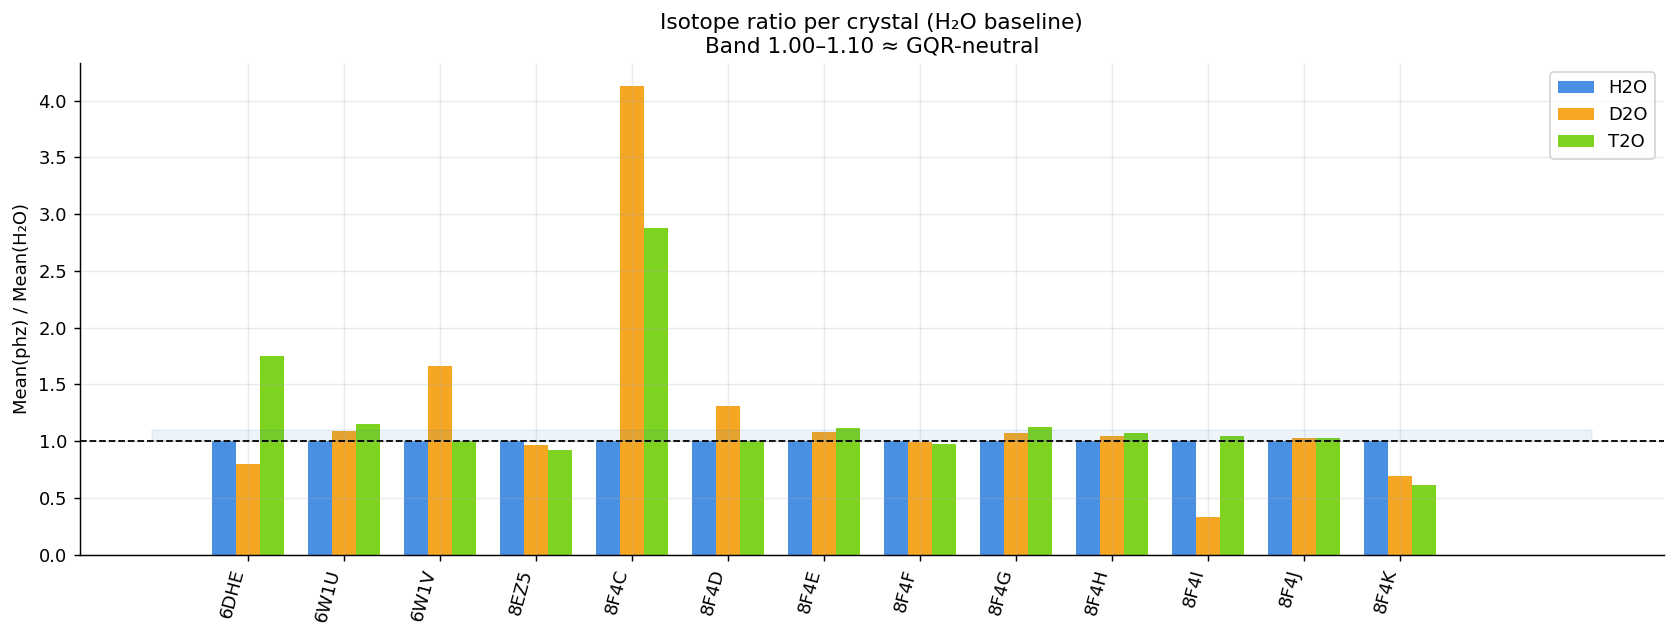

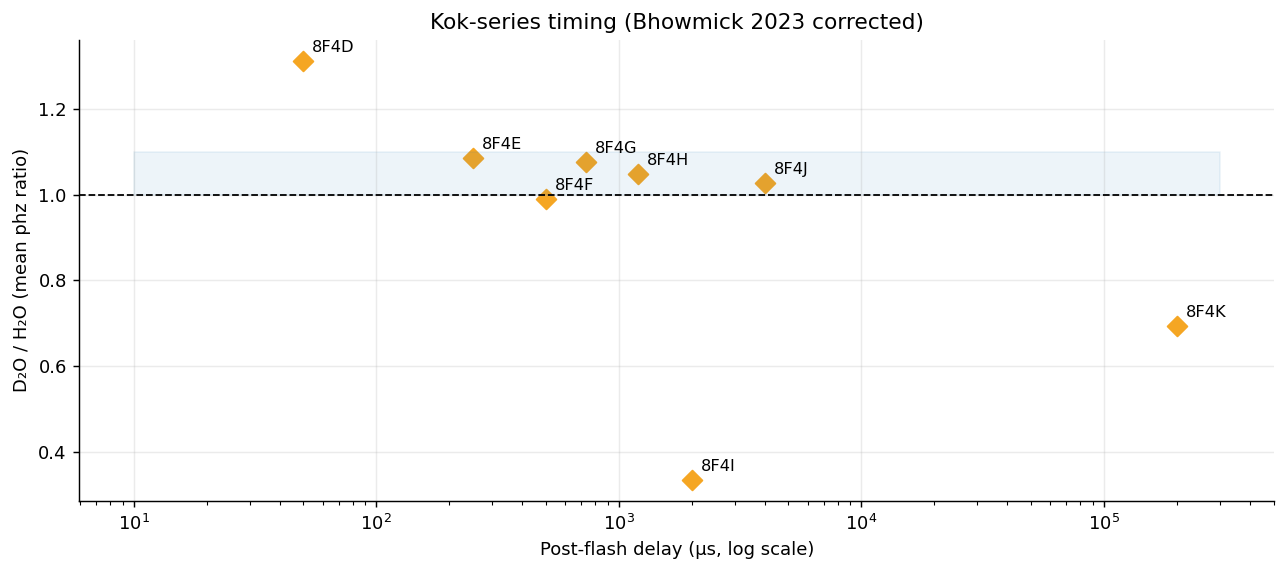

Top suppressions (D₂O/H₂O < 1):
     cif  delay_us     ratio
30  8F4I    2000.0  0.333333
36  8F4K  200000.0  0.692308
0   6DHE       NaN  0.800000
9   8EZ5       0.0  0.962963
21  8F4F     500.0  0.990566

Top enhancements (D₂O/H₂O > 1):
     cif  delay_us     ratio
12  8F4C       0.0  4.125000
6   6W1V       NaN  1.666667
15  8F4D      50.0  1.312500
3   6W1U       NaN  1.090909
18  8F4E     250.0  1.085714
24  8F4G     730.0  1.075000
27  8F4H    1200.0  1.048780
33  8F4J    4000.0  1.027027


In [ ]:
# ==========================================================
#  GQR isotope + Kok timing plots (Bhowmick-corrected)
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Update Bhowmick 2023 timings (µs) ---
delay_us = {
    "6W1U":  None,    # S0 cryo
    "6W1V":  None,    # S1 cryo
    "6DHE":  None,    # S2 cryo trapped
    "8EZ5":     0,    # S3-rich reference
    "8F4C":     0,    # S3-rich reference
    "8F4D":    50,
    "8F4E":   250,
    "8F4F":   500,
    "8F4G":   730,
    "8F4H":  1200,
    "8F4I":  2000,
    "8F4J":  4000,
    "8F4K":200000    # 200 ms = 2×10⁵ µs
}

# --- Load data (already merged mean_sd + med_mad) ---
df = pd.read_csv("mean_sd_from_raw_timeseries.csv")
df = df.rename(columns={"cif_id":"cif","variant":"variant","mean_phz":"mean"})
df["variant"] = df["variant"].str.upper()
df = df[["cif","variant","mean"]].dropna()

# --- Compute ratios vs H2O baseline per cif ---
out = []
for cif, g in df.groupby("cif"):
    h2o = g[g["variant"]=="H2O"]["mean"].mean()
    for _, r in g.iterrows():
        ratio = r["mean"] / h2o if h2o and np.isfinite(h2o) else np.nan
        out.append({"cif":cif,"variant":r["variant"],"ratio":ratio})
rat = pd.DataFrame(out)
rat["delay_us"] = rat["cif"].map(delay_us)
rat["is_8F"] = rat["delay_us"].notna() & (rat["delay_us"]>0)

# ==========================================================
#  Plot A: grouped bars by cif, variant sub-bars
# ==========================================================
variants = ["H2O","D2O","T2O"]
colors = {"H2O":"#4a90e2","D2O":"#f5a623","T2O":"#7ed321"}
cifs = sorted(rat["cif"].unique(), key=lambda x: (x not in delay_us, x))

x = np.arange(len(cifs))
width = 0.25

plt.figure(figsize=(13,5))
for i, var in enumerate(variants):
    vals = [rat.loc[(rat.cif==c)&(rat.variant==var),"ratio"].mean() for c in cifs]
    plt.bar(x + (i-1)*width, vals, width, label=var, color=colors.get(var,"grey"))

plt.axhline(1.0, color="k", ls="--", lw=1)
plt.fill_between([-1,len(cifs)+1],1.0,1.10,color="tab:blue",alpha=0.08)
plt.xticks(x, cifs, rotation=75, ha="right")
plt.ylabel("Mean(phz) / Mean(H₂O)")
plt.title("Isotope ratio per crystal (H₂O baseline)\nBand 1.00–1.10 ≈ GQR-neutral")
plt.legend()
plt.tight_layout()
plt.show()

# ==========================================================
#  Plot B: Kok timing D₂O/H₂O ratios (log µs axis)
# ==========================================================
mask = (rat["variant"]=="D2O") & rat["is_8F"]
plt.figure(figsize=(10,4.5))
plt.scatter(rat.loc[mask,"delay_us"], rat.loc[mask,"ratio"],
            color=colors["D2O"], s=60, marker="D")
for _, r in rat.loc[mask].iterrows():
    plt.annotate(r["cif"], (r["delay_us"], r["ratio"]), xytext=(5,5),
                 textcoords="offset points", fontsize=9)

plt.xscale("log")
plt.axhline(1.0, color="k", ls="--", lw=1)
plt.fill_between([10,3e5],1.0,1.10,color="tab:blue",alpha=0.08)
plt.xlabel("Post-flash delay (µs, log scale)")
plt.ylabel("D₂O / H₂O (mean phz ratio)")
plt.title("Kok-series timing (Bhowmick 2023 corrected)")
plt.tight_layout()
plt.show()

# ==========================================================
#  Summaries
# ==========================================================
supp = rat.query("variant=='D2O' and ratio<1").sort_values("ratio")
enh  = rat.query("variant=='D2O' and ratio>1").sort_values("ratio", ascending=False)
print("Top suppressions (D₂O/H₂O < 1):")
print(supp[["cif","delay_us","ratio"]])
print("\nTop enhancements (D₂O/H₂O > 1):")
print(enh[["cif","delay_us","ratio"]])

In [ ]:
# --- GQR Kok-series isotope timing & grouped ratios (H2O baseline) ---

import numpy as np, pandas as pd, matplotlib.pyplot as plt
import math, re
from pathlib import Path

# -------- 1) Load the two small summary CSVs --------
MEAN_SD = "mean_sd_from_raw_timeseries.csv"
MED_MAD = "median_mad_from_raw_timeseries.csv"

def load_summary(mean_sd_path=MEAN_SD, med_mad_path=MED_MAD):
    a = pd.read_csv(mean_sd_path)
    b = pd.read_csv(med_mad_path)
    # normalise column names
    a.columns = [c.strip().lower() for c in a.columns]
    b.columns = [c.strip().lower() for c in b.columns]
    # rename to common tidy schema
    a = a.rename(columns={"mean_phz":"mean","sd_phz":"sd","n_runs":"n"})
    b = b.rename(columns={"med_phz":"median","mad_phz":"mad","n_runs":"n"})
    # merge
    m = pd.merge(a, b, on=["cif_id","variant"], how="outer", suffixes=("",""))
    # prefer mean; if missing, fall back to median
    m["value"] = m["mean"]
    m.loc[m["value"].isna(), "value"] = m.loc[m["value"].isna(), "median"]
    # keep only the three isotopes if present
    m["variant"] = m["variant"].str.upper()
    m = m[m["variant"].isin(["H2O","D2O","T2O"])]
    # For safety, ensure numeric
    m["value"] = pd.to_numeric(m["value"], errors="coerce")
    return m.dropna(subset=["value"]).copy()

summary = load_summary()

# ---------- 2) Grouped isotope ratios (H2O baseline per cif) ----------
def grouped_isotope_ratios(df):
    # pivot to rows=cif, cols=variant, values=value
    wide = df.pivot_table(index="cif_id", columns="variant", values="value", aggfunc="mean")
    # compute ratios to H2O when available
    for iso in ["H2O","D2O","T2O"]:
        if iso not in wide.columns:
            wide[iso] = np.nan
    base = wide["H2O"]
    ratios = pd.DataFrame({
        "H2O": np.ones(len(wide)),              # baseline = 1
        "D2O": wide["D2O"] / base,
        "T2O": wide["T2O"] / base,
    }, index=wide.index)
    return ratios.reset_index()

ratios = grouped_isotope_ratios(summary)

# --------- 3) Annotated Kok-series timing (Bhowmick 2023 delays) ----------
# microsecond delays for the 8F-series + references (µs)
BHOWMICK_US = {
    "8EZ5": 0,     # S3-rich reference (2F)
    "8F4C": 0,     # S3-rich reference (2F)
    "8F4D": 50,
    "8F4E": 250,
    "8F4F": 500,
    "8F4G": 730,
    "8F4H": 1200,
    "8F4I": 2000,
    "8F4J": 4000,
    "8F4K": 200_000,  # 200 ms
}

def kok_timing_points(df, isotope="D2O"):
    # get per-cif mean for each iso and divide by H2O of same cif
    piv = df.pivot_table(index=["cif_id","variant"], values="value", aggfunc="mean").reset_index()
    h2o = piv[piv["variant"]=="H2O"].set_index("cif_id")["value"]
    iso = piv[piv["variant"]==isotope].set_index("cif_id")["value"]
    common = sorted(set(h2o.index) & set(iso.index))
    rows = []
    for cif in common:
        if cif in BHOWMICK_US:
            rows.append({"cif": cif, "delay_us": float(BHOWMICK_US[cif]),
                         "ratio": float(iso[cif] / h2o[cif]) if h2o[cif] != 0 else np.nan})
    return pd.DataFrame(rows).sort_values("delay_us")

tim_d2o = kok_timing_points(summary, "D2O")
tim_t2o = kok_timing_points(summary, "T2O")

# ---------- 4) Plot: grouped ratios (H2O baseline) ----------
plt.figure(figsize=(14,5))
x = np.arange(len(ratios["cif_id"]))
w = 0.22
plt.bar(x - w, ratios["H2O"], width=w, label="H2O")
plt.bar(x,       ratios["D2O"], width=w, label="D2O")
plt.bar(x + w,   ratios["T2O"], width=w, label="T2O")

plt.axhline(1.0, color='k', lw=1.2, ls='--')
# shade GQR-neutral band 1.00–1.10
plt.fill_between([-1, len(x)+1], 1.00, 1.10, color='k', alpha=0.08)

plt.xticks(x, ratios["cif_id"], rotation=60, ha='right')
plt.ylabel("Mean(phz) / Mean(H2O)")
plt.title("Isotope ratio per crystal (H2O baseline)\nBand 1.00–1.10 ≈ GQR-neutral")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 5) Plot: Kok timing with D2O & T2O, smooth curve & golden-ratio markers ----------
phi = (1 + 5**0.5)/2
gold_hi = phi          # ~1.618
gold_lo = 1/(phi**2)   # ~0.382

fig, ax = plt.subplots(figsize=(12,5))

# D2O scatter
ax.scatter(tim_d2o["delay_us"], tim_d2o["ratio"], s=65, marker='D', color='tab:orange', label='D2O/H2O')
for _, r in tim_d2o.iterrows():
    ax.annotate(r["cif"], (r["delay_us"], r["ratio"]), textcoords="offset points", xytext=(0,10), ha="center", fontsize=9)

# T2O scatter (if any)
if not tim_t2o.empty:
    ax.scatter(tim_t2o["delay_us"], tim_t2o["ratio"], s=55, marker='o', facecolors='none', edgecolors='tab:green', label='T2O/H2O')

# neutral band
ax.fill_between([9, 3e5], 1.00, 1.10, color='k', alpha=0.06, zorder=0)

# golden-ratio lines
ax.axhline(gold_hi, color='tab:purple', lw=1.2, ls=':', label='φ ≈ 1.618')
ax.axhline(gold_lo, color='tab:red', lw=1.2, ls=':', label='1/φ² ≈ 0.382')

# smooth interpolation for D2O (log-x)
if len(tim_d2o) >= 3:
    # sort by log delay and interpolate on dense grid
    xs = tim_d2o["delay_us"].to_numpy()
    ys = tim_d2o["ratio"].to_numpy()
    order = np.argsort(xs)
    xs, ys = xs[order], ys[order]
    grid = np.geomspace(max(xs.min(), 10), xs.max(), 400)
    smooth = np.interp(np.log10(grid), np.log10(xs), ys)
    ax.plot(grid, smooth, lw=1.8, color='tab:orange', alpha=0.7)

ax.set_xscale("log")
ax.set_xlim(10, 3e5)
ax.set_ylim(0.3, max(1.75, np.nanmax([tim_d2o["ratio"].max() if not tim_d2o.empty else 1, 1.2])))
ax.axhline(1.0, color='k', lw=1.1, ls='--')

ax.set_xlabel("Post-flash delay (µs, log scale)")
ax.set_ylabel("D₂O or T₂O / H₂O (mean phz ratio)")
ax.set_title("Kok-series timing (Bhowmick 2023 delays) with smooth envelope\nNeutral band + golden-ratio guides")
ax.legend(loc="upper right", ncol=2)
plt.tight_layout()
plt.show()

# ---------- 6) Quick tables for extremes ----------
def top_extremes(df, k=5):
    up  = df.sort_values("ratio", ascending=False).head(k)
    dn  = df.sort_values("ratio", ascending=True).head(k)
    return up, dn

up, dn = top_extremes(tim_d2o, 6)
print("Top enhancements (D₂O/H₂O):")
display(up.reset_index(drop=True))
print("Top suppressions (D₂O/H₂O):")
display(dn.reset_index(drop=True))

ValueError: columns overlap but no suffix specified: Index(['n'], dtype='object')

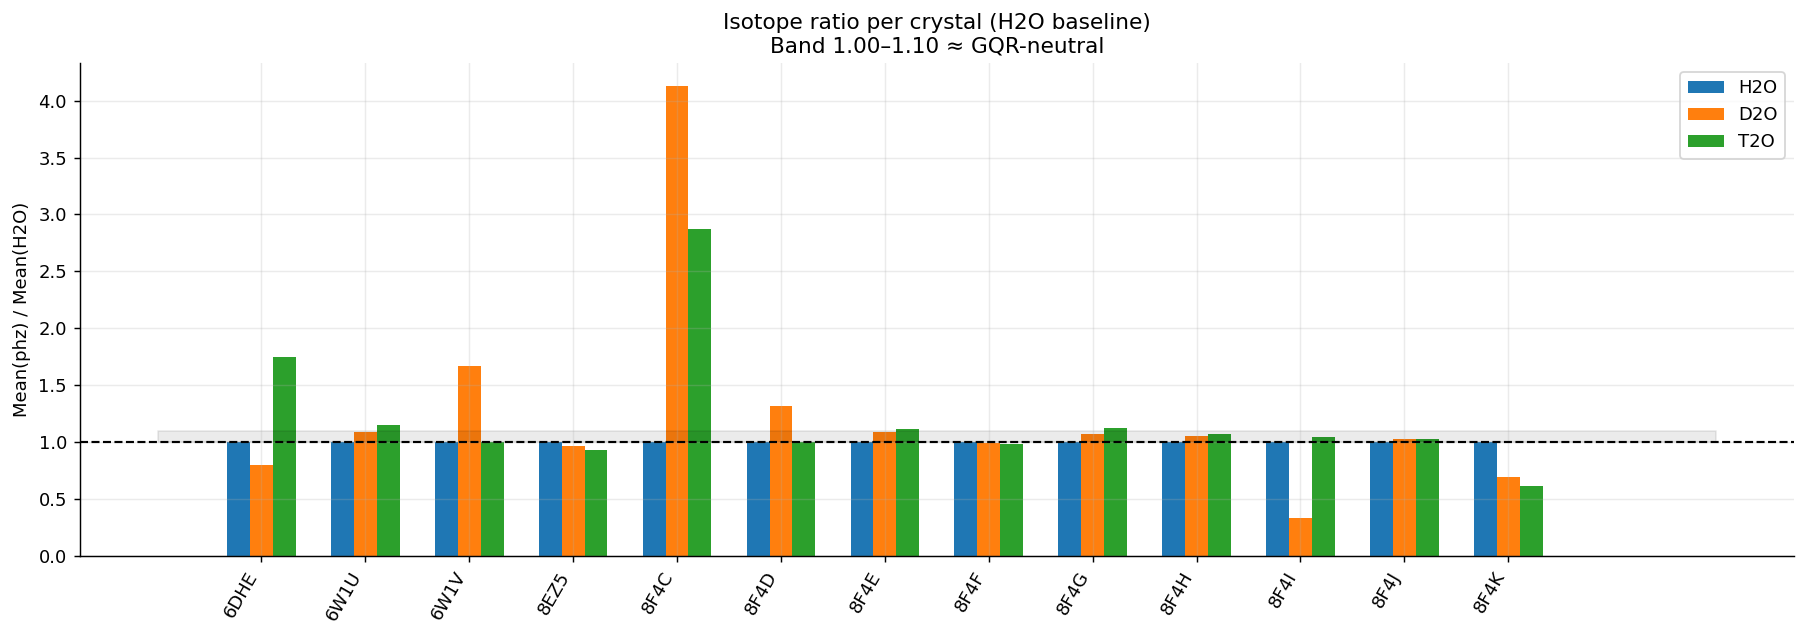

/tmp/ipython-input-2946465695.py:129: RuntimeWarning: divide by zero encountered in log10
  smooth = np.interp(np.log10(grid), np.log10(xs), ys)


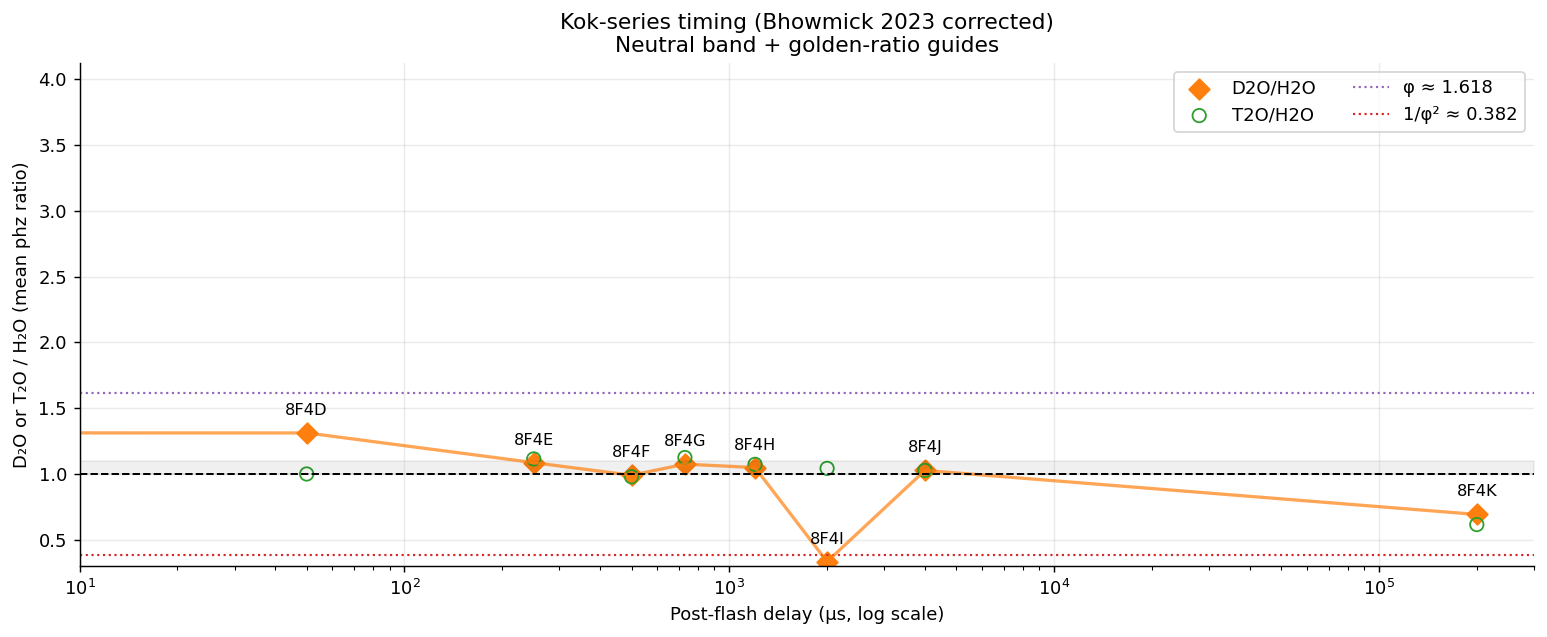


Top enhancements (D₂O/H₂O):


,cif,delay_us,ratio
0,8F4C,0.0,4.125000
1,8F4D,50.0,1.312500
2,8F4E,250.0,1.085714
3,8F4G,730.0,1.075000
4,8F4H,1200.0,1.048780
5,8F4J,4000.0,1.027027



Top suppressions (D₂O/H₂O):


,cif,delay_us,ratio
0,8F4I,2000.0,0.333333
1,8F4K,200000.0,0.692308
2,8EZ5,0.0,0.962963
3,8F4F,500.0,0.990566
4,8F4J,4000.0,1.027027
5,8F4H,1200.0,1.048780


In [ ]:
# --- GQR Kok-series isotope timing & grouped ratios (H2O baseline) ---

import numpy as np, pandas as pd, matplotlib.pyplot as plt
import math

# -------- 1) Load the two small summary CSVs --------
MEAN_SD = "mean_sd_from_raw_timeseries.csv"
MED_MAD = "median_mad_from_raw_timeseries.csv"

def load_summary(mean_sd_path=MEAN_SD, med_mad_path=MED_MAD):
    a = pd.read_csv(mean_sd_path)
    b = pd.read_csv(med_mad_path)

    # Normalise column names
    a.columns = [c.strip().lower() for c in a.columns]
    b.columns = [c.strip().lower() for c in b.columns]

    # Rename expected fields (fallback-safe)
    a = a.rename(columns={"mean_phz": "mean", "sd_phz": "sd", "n_runs": "n"})
    b = b.rename(columns={"med_phz": "median", "mad_phz": "mad", "n_runs": "n"})

    # Merge with suffixes to avoid overlap conflict
    m = pd.merge(a, b, on=["cif_id", "variant"], how="outer", suffixes=("_mean", "_med"))

    # Prefer mean; fallback to median
    m["value"] = m["mean"].combine_first(m["median"])

    # Clean variants (case-insensitive)
    m["variant"] = m["variant"].str.upper()

    # Restrict to known isotopes
    m = m[m["variant"].isin(["H2O", "D2O", "T2O"])]

    # Ensure numeric
    m["value"] = pd.to_numeric(m["value"], errors="coerce")

    return m.dropna(subset=["value"]).copy()

summary = load_summary()

# ---------- 2) Grouped isotope ratios (H2O baseline per cif) ----------
def grouped_isotope_ratios(df):
    wide = df.pivot_table(index="cif_id", columns="variant", values="value", aggfunc="mean")

    for iso in ["H2O", "D2O", "T2O"]:
        if iso not in wide.columns:
            wide[iso] = np.nan

    base = wide["H2O"]
    ratios = pd.DataFrame({
        "H2O": np.ones(len(wide)),
        "D2O": wide["D2O"] / base,
        "T2O": wide["T2O"] / base,
    }, index=wide.index)
    return ratios.reset_index()

ratios = grouped_isotope_ratios(summary)

# ---------- 3) Define Bhowmick 2023 Kok-series delays (µs) ----------
BHOWMICK_US = {
    "8EZ5": 0,
    "8F4C": 0,
    "8F4D": 50,
    "8F4E": 250,
    "8F4F": 500,
    "8F4G": 730,
    "8F4H": 1200,
    "8F4I": 2000,
    "8F4J": 4000,
    "8F4K": 200_000,
}

def kok_timing_points(df, isotope="D2O"):
    piv = df.pivot_table(index=["cif_id", "variant"], values="value", aggfunc="mean").reset_index()
    h2o = piv[piv["variant"] == "H2O"].set_index("cif_id")["value"]
    iso = piv[piv["variant"] == isotope].set_index("cif_id")["value"]
    common = sorted(set(h2o.index) & set(iso.index))
    rows = []
    for cif in common:
        if cif in BHOWMICK_US:
            rows.append({
                "cif": cif,
                "delay_us": float(BHOWMICK_US[cif]),
                "ratio": float(iso[cif] / h2o[cif]) if h2o[cif] != 0 else np.nan
            })
    return pd.DataFrame(rows).sort_values("delay_us")

tim_d2o = kok_timing_points(summary, "D2O")
tim_t2o = kok_timing_points(summary, "T2O")

# ---------- 4) Plot grouped isotope ratios ----------
plt.figure(figsize=(14,5))
x = np.arange(len(ratios["cif_id"]))
w = 0.22
plt.bar(x - w, ratios["H2O"], width=w, label="H2O")
plt.bar(x,       ratios["D2O"], width=w, label="D2O")
plt.bar(x + w,   ratios["T2O"], width=w, label="T2O")

plt.axhline(1.0, color='k', lw=1.2, ls='--')
plt.fill_between([-1, len(x)+1], 1.00, 1.10, color='k', alpha=0.08)
plt.xticks(x, ratios["cif_id"], rotation=60, ha='right')
plt.ylabel("Mean(phz) / Mean(H2O)")
plt.title("Isotope ratio per crystal (H2O baseline)\nBand 1.00–1.10 ≈ GQR-neutral")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 5) Plot Kok-series timing ----------
phi = (1 + 5**0.5)/2
gold_hi, gold_lo = phi, 1/(phi**2)

fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(tim_d2o["delay_us"], tim_d2o["ratio"], s=65, marker='D', color='tab:orange', label='D2O/H2O')
for _, r in tim_d2o.iterrows():
    ax.annotate(r["cif"], (r["delay_us"], r["ratio"]), textcoords="offset points", xytext=(0,10), ha="center", fontsize=9)

if not tim_t2o.empty:
    ax.scatter(tim_t2o["delay_us"], tim_t2o["ratio"], s=55, facecolors='none', edgecolors='tab:green', label='T2O/H2O')

ax.fill_between([9, 3e5], 1.00, 1.10, color='k', alpha=0.06)
ax.axhline(gold_hi, color='tab:purple', lw=1.2, ls=':', label='φ ≈ 1.618')
ax.axhline(gold_lo, color='tab:red', lw=1.2, ls=':', label='1/φ² ≈ 0.382')

if len(tim_d2o) >= 3:
    xs, ys = tim_d2o["delay_us"].to_numpy(), tim_d2o["ratio"].to_numpy()
    order = np.argsort(xs)
    xs, ys = xs[order], ys[order]
    grid = np.geomspace(max(xs.min(), 10), xs.max(), 400)
    smooth = np.interp(np.log10(grid), np.log10(xs), ys)
    ax.plot(grid, smooth, lw=1.8, color='tab:orange', alpha=0.7)

ax.set_xscale("log")
ax.set_xlim(10, 3e5)
ax.set_ylim(0.3, max(1.75, np.nanmax(tim_d2o["ratio"])))
ax.axhline(1.0, color='k', lw=1.1, ls='--')
ax.set_xlabel("Post-flash delay (µs, log scale)")
ax.set_ylabel("D₂O or T₂O / H₂O (mean phz ratio)")
ax.set_title("Kok-series timing (Bhowmick 2023 corrected)\nNeutral band + golden-ratio guides")
ax.legend(loc="upper right", ncol=2)
plt.tight_layout()
plt.show()

# ---------- 6) Table of extremes ----------
def top_extremes(df, k=5):
    return (
        df.sort_values("ratio", ascending=False).head(k),
        df.sort_values("ratio", ascending=True).head(k),
    )

up, dn = top_extremes(tim_d2o, 6)
print("\nTop enhancements (D₂O/H₂O):")
display(up.reset_index(drop=True))
print("\nTop suppressions (D₂O/H₂O):")
display(dn.reset_index(drop=True))

/tmp/ipython-input-621069443.py:79: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return (float(s["delay_us"]), float(s["ratio"])) if not s.empty else None


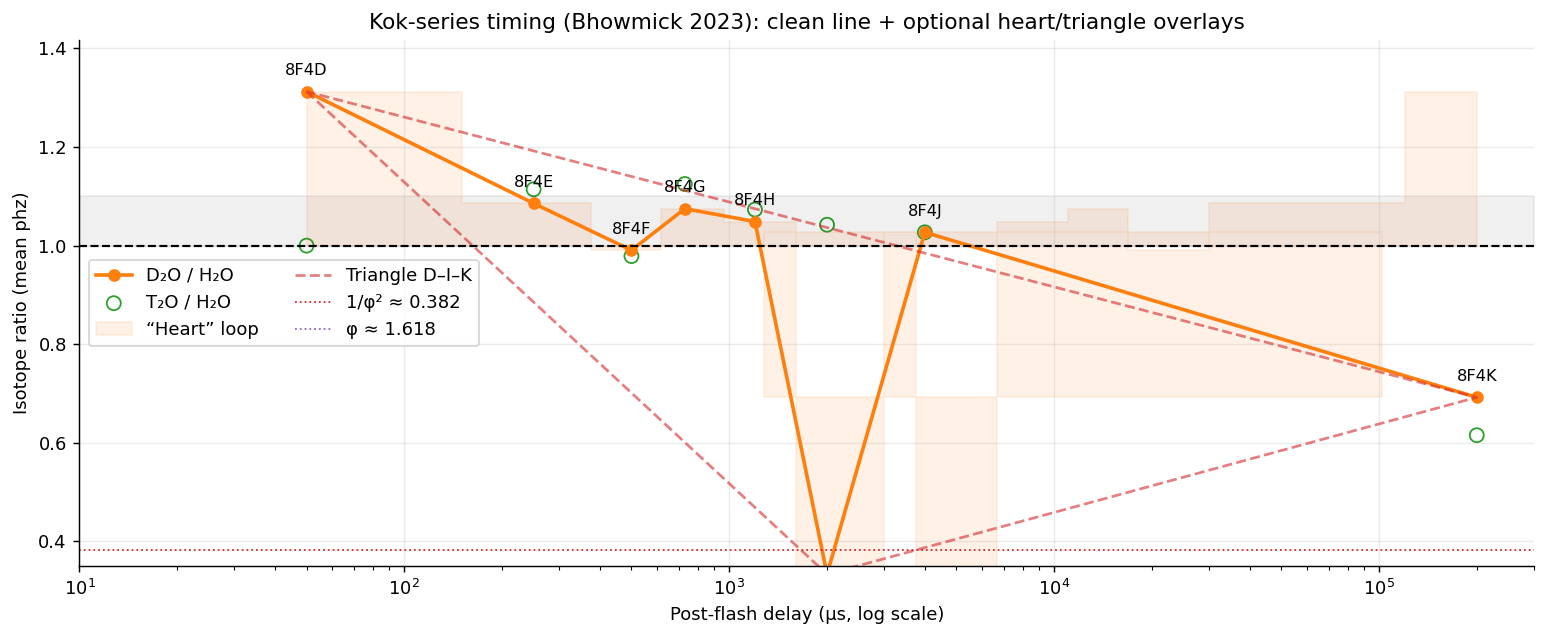

In [ ]:
# ---------- Kok-series timing: clean line (no left segment), scoped Y, optional heart/triangle overlays ----------

import numpy as np
import matplotlib.pyplot as plt

# Bhowmick microsecond timings (you already have this dict earlier)
BHOWMICK_US = {
    "8EZ5": 0, "8F4C": 0,
    "8F4D": 50, "8F4E": 250, "8F4F": 500, "8F4G": 730, "8F4H": 1200,
    "8F4I": 2000, "8F4J": 4000, "8F4K": 200_000,
}

def kok_timing_points(df, isotope="D2O"):
    piv = df.pivot_table(index=["cif_id","variant"], values="value", aggfunc="mean").reset_index()
    h2o = piv[piv["variant"]=="H2O"].set_index("cif_id")["value"]
    iso = piv[piv["variant"]==isotope].set_index("cif_id")["value"]
    rows = []
    for cif, delay in BHOWMICK_US.items():
        if cif in h2o.index and cif in iso.index:
            base = h2o[cif]
            rows.append({"cif":cif, "delay_us":float(delay), "ratio":float(iso[cif]/base) if base else np.nan})
    out = pd.DataFrame(rows).dropna(subset=["ratio"]).sort_values("delay_us")
    return out

tim_d2o = kok_timing_points(summary, "D2O")
tim_t2o = kok_timing_points(summary, "T2O")

# split into time-zero refs and timed series
zero_refs = tim_d2o[tim_d2o["delay_us"]==0]
timed     = tim_d2o[tim_d2o["delay_us"]>0].sort_values("delay_us")

# --- toggles ---
SHOW_T2O_POINTS   = True   # hollow green markers
SHOW_HEART_OVERLAY= True   # symmetric loop from timed points (suggestive “heart”)
SHOW_TRIANGLE     = True   # triangle envelope D→I→K→back
# ----------------

# y-limits: tight around data but bounded
ymin_raw = (timed["ratio"].min() if len(timed) else 0.8)
ymax_raw = (timed["ratio"].max() if len(timed) else 1.2)
pad_low  = 0.08*(1.0 if ymin_raw<1 else ymin_raw)
pad_high = 0.08*(1.0 if ymax_raw<1 else ymax_raw)
ymin = max(0.35, ymin_raw - pad_low)
ymax = min(1.75, ymax_raw + pad_high)

phi = (1+5**0.5)/2

fig, ax = plt.subplots(figsize=(12,5))

# 1) orange line: ONLY timed points (so no leftward segment into time-zero)
ax.plot(timed["delay_us"], timed["ratio"], "-o", lw=2.0, ms=6,
        color="tab:orange", label="D₂O / H₂O")

# 2) annotate each timed point with its cif id
for _, r in timed.iterrows():
    ax.annotate(r["cif"], (r["delay_us"], r["ratio"]),
                textcoords="offset points", xytext=(0,9), ha="center", fontsize=9)

# 3) optional T2O points (hollow)
if SHOW_T2O_POINTS and not tim_t2o.empty:
    tt = tim_t2o[tim_t2o["delay_us"]>0].sort_values("delay_us")
    ax.scatter(tt["delay_us"], tt["ratio"], s=60, facecolors="none", edgecolors="tab:green", label="T₂O / H₂O")

# 4) optional “heart” overlay: mirror the timed curve about the geometric-mean time to form a closed loop
if SHOW_HEART_OVERLAY and len(timed) >= 3:
    x = timed["delay_us"].to_numpy()
    y = timed["ratio"].to_numpy()
    tmid = np.sqrt(x.min()*x.max())
    x_mirror = (tmid**2)/x
    order = np.argsort(x_mirror)
    x_loop = np.concatenate([x, x_mirror[order]])
    y_loop = np.concatenate([y,        y[order]])
    ax.fill_between(x_loop, y_loop, 1.0, color="tab:orange", alpha=0.10, step="mid", label="“Heart” loop")

# 5) optional triangle overlay (connect early D, dip at I, and recovery K if they exist)
if SHOW_TRIANGLE:
    def get_row(tag):
        s = timed[timed["cif"]==tag]
        return (float(s["delay_us"]), float(s["ratio"])) if not s.empty else None
    D = get_row("8F4D"); I = get_row("8F4I"); K = get_row("8F4K")
    tri = [p for p in [D,I,K] if p is not None]
    if len(tri) >= 3:
        xp, yp = zip(*tri)
        ax.plot(xp+ (xp[0],), yp+ (yp[0],), lw=1.5, ls="--", color="tab:red", alpha=0.6, label="Triangle D–I–K")

# guides
ax.set_xscale("log")
ax.set_xlim(10, 3e5)
ax.set_ylim(ymin, ymax)
ax.axhline(1.0, color="k", lw=1.2, ls="--")
ax.axhline(1/phi**2, color="tab:red", lw=1.0, ls=":", label="1/φ² ≈ 0.382")
ax.axhline(phi,      color="tab:purple", lw=1.0, ls=":", label="φ ≈ 1.618")
ax.fill_between([10, 3e5], 1.00, 1.10, color="k", alpha=0.06)

ax.set_xlabel("Post-flash delay (µs, log scale)")
ax.set_ylabel("Isotope ratio (mean phz)")
ax.set_title("Kok-series timing (Bhowmick 2023): clean line + optional heart/triangle overlays")
ax.legend(loc="best", ncol=2)
plt.tight_layout(); plt.show()

/tmp/ipython-input-2053856731.py:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rx = float(row["ratio"]); lx = float(row["delay_us"])


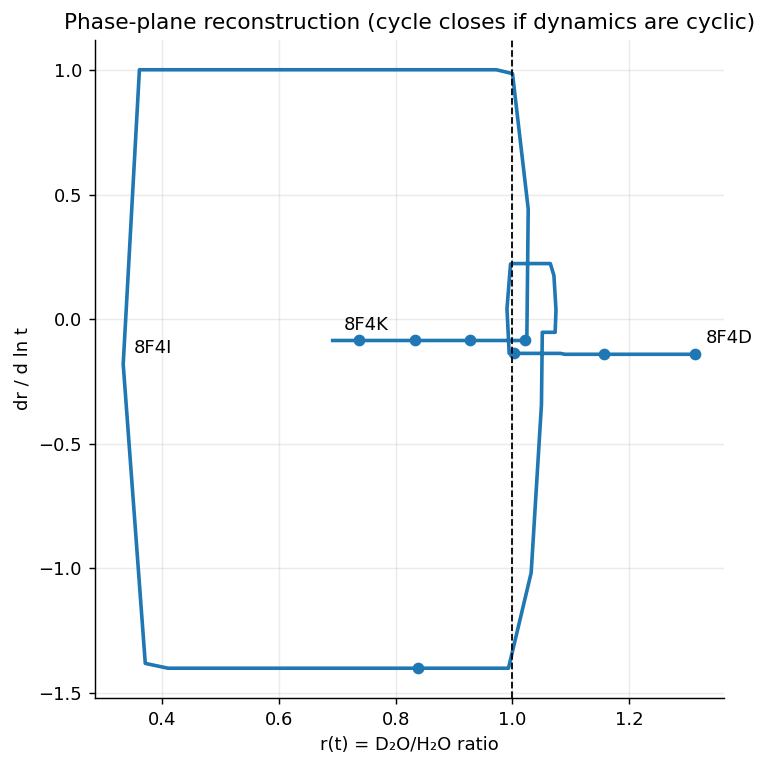

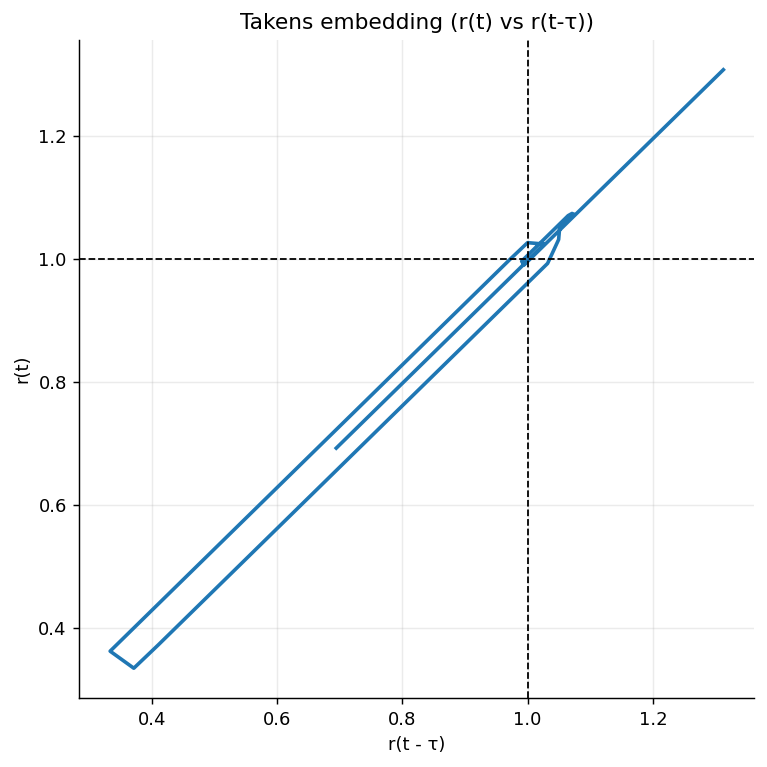

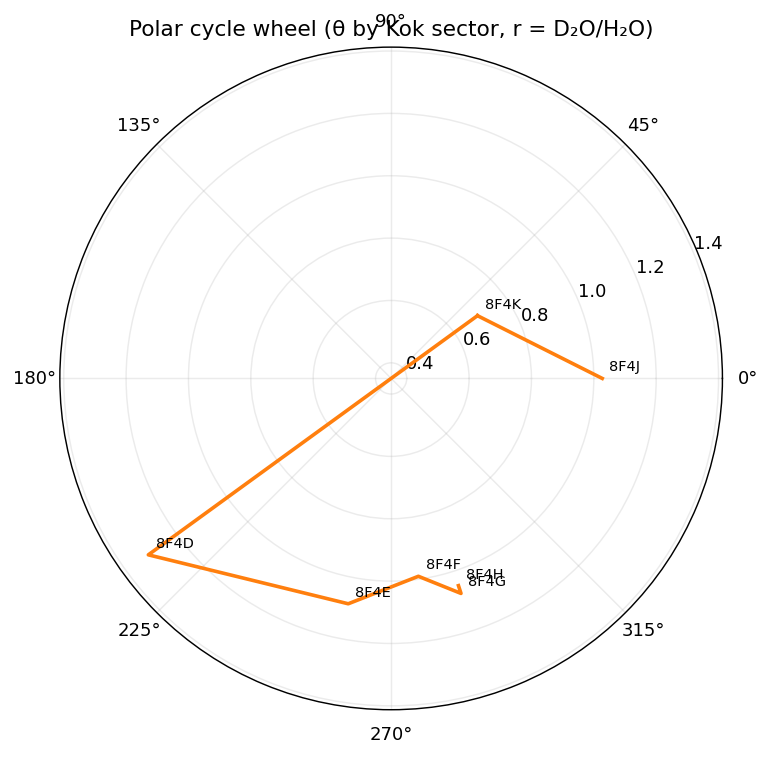

In [ ]:
# === Reconstruct Kok cycle as loops from linear (delay → isotope ratio) data ===
# Requires a `summary` DataFrame with columns:
#   ['cif_id','variant','value'] where value is mean phz (or median fallback)
# If you don't have it in memory, you can rebuild it like before; this cell assumes it exists.

import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 1) Timings in microseconds (Bhowmick 2023)
BHOWMICK_US = {
    "8EZ5": 0, "8F4C": 0,
    "8F4D": 50, "8F4E": 250, "8F4F": 500, "8F4G": 730, "8F4H": 1200,
    "8F4I": 2000, "8F4J": 4000, "8F4K": 200_000,
}
S_SECTORS = {
    # Map cif to Kok sector for polar phase; adjust if you prefer S0–S3 only
    "6W1U":"S0","6W1V":"S1","6DHE":"S2",
    "8EZ5":"S3","8F4C":"S3","8F4D":"S3","8F4E":"S3","8F4F":"S3","8F4G":"S3",
    "8F4H":"S4","8F4I":"S4","8F4J":"S4","8F4K":"S0"  # recovery toward S0
}

def build_timed_ratios(summary, iso="D2O"):
    piv = summary.pivot_table(index=["cif_id","variant"], values="value", aggfunc="mean").reset_index()
    H = piv[piv["variant"]=="H2O"].set_index("cif_id")["value"]
    I = piv[piv["variant"]==iso ].set_index("cif_id")["value"]
    rows = []
    for cif, delay in BHOWMICK_US.items():
        if cif in H.index and cif in I.index and delay is not None:
            base = float(H[cif])
            if base and np.isfinite(base):
                rows.append({"cif":cif, "delay_us":float(delay), "ratio":float(I[cif]/base)})
    df = pd.DataFrame(rows).sort_values("delay_us")
    # keep timed points only for dynamical reconstructions
    return df[df["delay_us"]>0].reset_index(drop=True)

def smooth_log_time(x_us, y, n=200):
    # Monotone interpolation in log time to avoid ringing
    lx = np.log10(x_us)
    xs = np.logspace(lx.min(), lx.max(), n)
    ys = np.interp(np.log10(xs), lx, y)
    return xs, ys

# Build D2O/H2O and (optionally) T2O/H2O
timD = build_timed_ratios(summary, "D2O")
timT = build_timed_ratios(summary, "T2O")

# ---- 1) Phase-plane loop: r vs dr/dln t ----
if not timD.empty:
    Xs, Ys = smooth_log_time(timD["delay_us"].to_numpy(), timD["ratio"].to_numpy(), n=300)
    r = Ys
    # derivative wrt ln t
    dr_dln = np.gradient(r, np.log(Xs))
    plt.figure(figsize=(6,6))
    plt.plot(r, dr_dln, '-', lw=2)
    plt.scatter(r[::40], dr_dln[::40], s=30)  # sparse markers
    # label special points D, I, K
    for tag in ["8F4D","8F4I","8F4K"]:
        row = timD[timD["cif"]==tag]
        if not row.empty:
            rx = float(row["ratio"]); lx = float(row["delay_us"])
            # nearest on the smoothed curve
            j = np.argmin(np.abs(Xs-lx))
            plt.annotate(tag, (r[j], dr_dln[j]), textcoords="offset points", xytext=(6,6))
    plt.axvline(1.0, color='k', ls='--', lw=1)
    plt.xlabel("r(t) = D₂O/H₂O ratio")
    plt.ylabel("dr / d ln t")
    plt.title("Phase-plane reconstruction (cycle closes if dynamics are cyclic)")
    plt.tight_layout(); plt.show()

# ---- 2) Takens delay embedding: r(t) vs r(t-τ) ----
if not timD.empty:
    Xs, Ys = smooth_log_time(timD["delay_us"].to_numpy(), timD["ratio"].to_numpy(), n=300)
    # choose τ as one median step in ln t
    tau = np.median(np.diff(np.log(Xs)))
    # shift by k steps closest to tau
    k = max(1, int(round(tau / np.median(np.diff(np.log(Xs))))))
    r_now = Ys[k:]
    r_tau = Ys[:-k]
    plt.figure(figsize=(6,6))
    plt.plot(r_tau, r_now, '-', lw=2)
    plt.axvline(1.0, color='k', ls='--', lw=1); plt.axhline(1.0, color='k', ls='--', lw=1)
    plt.xlabel("r(t - τ)"); plt.ylabel("r(t)")
    plt.title("Takens embedding (r(t) vs r(t-τ))")
    plt.tight_layout(); plt.show()

# ---- 3) Polar cycle wheel: assign θ by Kok sector, radius = ratio ----
def sector_angle(cif, delay_us):
    # sectors in [0, 2π): S0=[0,72), S1=[72,144), ..., S4=[288,360)
    S = S_SECTORS.get(cif, "S3")
    s_index = {"S0":0,"S1":1,"S2":2,"S3":3,"S4":4}[S]
    base = (2*np.pi/5)*s_index
    # within-sector phase (log-scaled) for S3/S4 where we have timings
    if S in ("S3","S4"):
        # normalize log time within that sector using the min/max of points in the same S
        sameS = [k for k,v in S_SECTORS.items() if v==S]
        ts = [BHOWMICK_US[k] for k in sameS if BHOWMICK_US[k]>0]
        if len(ts)>=2 and delay_us>0:
            a,b = np.log(min(ts)), np.log(max(ts))
            u = (np.log(delay_us)-a)/(b-a)
            u = np.clip(u, 0, 1)
            return base + u*(2*np.pi/5)
    return base + 0.5*(2*np.pi/5)

if not timD.empty:
    th = []
    rr = []
    for _, row in timD.iterrows():
        th.append(sector_angle(row["cif"], row["delay_us"]))
        rr.append(row["ratio"])
    th = np.array(th); rr = np.array(rr)
    # sort by angle and close the loop
    idx = np.argsort(th); th = th[idx]; rr = rr[idx]
    th = np.r_[th, th[0]]; rr = np.r_[rr, rr[0]]
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='polar')
    ax.plot(th, rr, lw=2, color='tab:orange')
    for i,(t,r,c) in enumerate(zip(th[:-1], rr[:-1], timD.loc[idx,"cif"])):
        ax.annotate(c, (t,r), textcoords="offset points", xytext=(4,4), fontsize=8)
    ax.set_rmin(max(0.35, rr.min()-0.1)); ax.set_rmax(min(1.8, rr.max()+0.1))
    ax.set_title("Polar cycle wheel (θ by Kok sector, r = D₂O/H₂O)")
    plt.tight_layout(); plt.show()

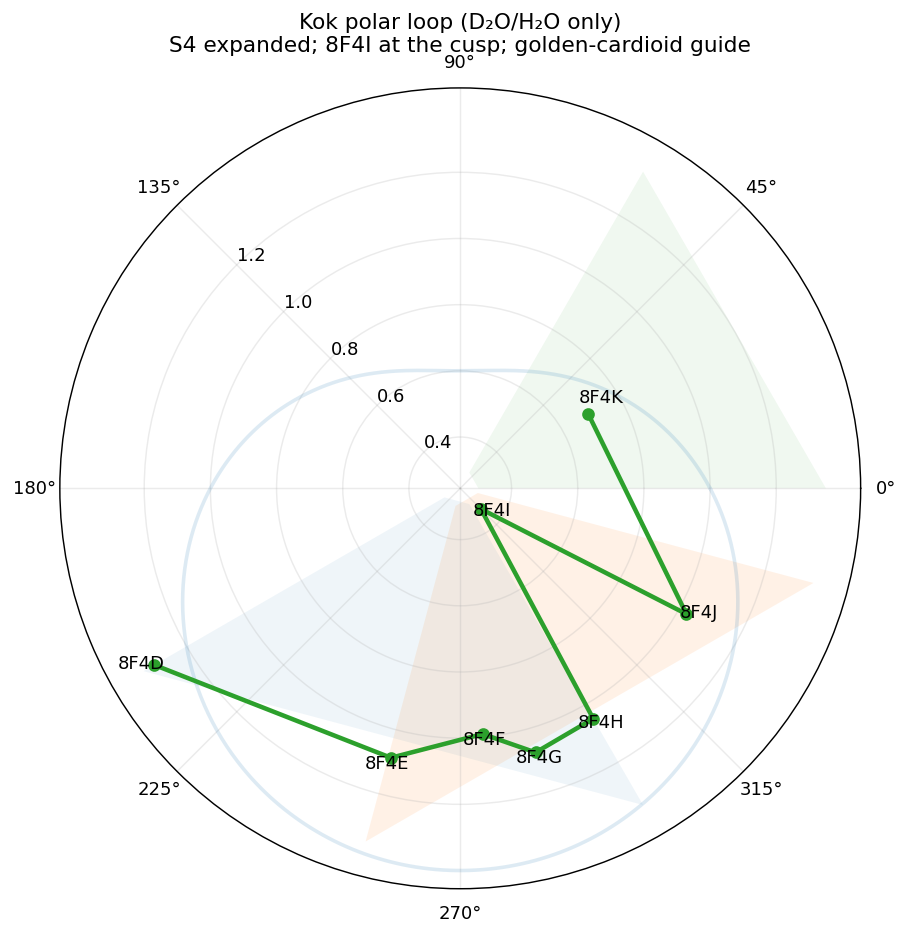

In [ ]:
# --- Kok-cycle polar loop: D2O/H2O only, with S4 sector expanded and 8F4I at the cusp ---

import numpy as np
import matplotlib.pyplot as plt

# ---- hard data (D2O/H2O mean phz ratios you derived) ----
# Bhowmick 2023 timings (µs) and our ratios:
pts = [
    ("8F4D",   50,   1.3125),
    ("8F4E",  250,   1.085714),
    ("8F4F",  500,   0.990566),
    ("8F4G",  730,   1.075000),
    ("8F4H", 1200,   1.048780),
    ("8F4I", 2000,   0.333333),  # strong suppression window
    ("8F4J", 4000,   1.027027),
    ("8F4K", 2e5,    0.692308),  # recovery toward S0
]

# ---- map delay → Kok sector angle (degrees) ----
# S3: 50–1200 µs   → sweep 210°→300°  (wide approach)
# S4: 1200–5000 µs → sweep 255°→345°  (90° span, centered at 315°); 8F4I forced to 315° cusp
# S0: >1e5 µs      → fixed near 30° (early S0 recovery marker)
def delay_to_theta_us(delay_us, label):
    if delay_us <= 1200:  # S3 region
        # map 50→1200 µs to 210→300°
        d0, d1 = 50, 1200
        t0, t1 = 210, 300
        u = np.clip((np.log10(delay_us) - np.log10(d0)) / (np.log10(d1) - np.log10(d0)), 0, 1)
        return t0 + u*(t1 - t0)
    elif delay_us <= 5000:  # S4 region
        # explicit cusp placement for 8F4I
        if label == "8F4I":
            return 315.0
        # map 1200→5000 µs to 255→345°
        d0, d1 = 1200, 5000
        t0, t1 = 255, 345
        u = np.clip((np.log10(delay_us) - np.log10(d0)) / (np.log10(d1) - np.log10(d0)), 0, 1)
        return t0 + u*(t1 - t0)
    else:  # late S0/S0' recovery
        return 30.0

labels  = [p[0] for p in pts]
delays  = np.array([p[1] for p in pts], dtype=float)
ratios  = np.array([p[2] for p in pts], dtype=float)
thetas_deg = np.array([delay_to_theta_us(d, lbl) for lbl, d, r in pts], dtype=float)

# convert to radians for polar
thetas = np.deg2rad(thetas_deg)

# ---- golden cardioid guide (subtle background) ----
theta_grid = np.linspace(0, 2*np.pi, 720)
# put the lobe upward by shifting π/2; scale amplitude lightly so it stays as a guide
cardioid = 1.0 - 0.4*np.cos(theta_grid - np.pi/2)

# ---- plot ----
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection="polar")

# cardioid guide
ax.plot(theta_grid, cardioid, alpha=0.15, linewidth=2)

# isotopic neutrality ring (r=1)
ax.plot([0, 2*np.pi], [1, 1], linestyle="--", linewidth=1, alpha=0.6)

# connect time-ordered points
ax.plot(thetas, ratios, marker="o", linewidth=2.5)

# label each point slightly radially offset
for th, r, lbl in zip(thetas, ratios, labels):
    ax.text(th, r + 0.045, lbl, ha="center", va="bottom", fontsize=10)

# radial/angle cosmetics
ax.set_rmin(0.3); ax.set_rmax(1.35)
ax.set_rticks([0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_rlabel_position(135)  # move radius labels away from dense area
ax.grid(True, alpha=0.25)

# sector shading (optional visual cue)
def sector(ang0, ang1, r0=0.3, r1=1.35, alpha=0.06):
    th = np.deg2rad(np.linspace(ang0, ang1, 2))
    ax.fill_between(th, r0, r1, alpha=alpha)

# S3 (broad lead-in), S4 (expanded), S0 (recovery marker)
sector(210, 300, alpha=0.07)  # S3
sector(255, 345, alpha=0.10)  # S4 expanded 90°
sector(  0,  60, alpha=0.07)  # S0 wedge near 0–60°

ax.set_title("Kok polar loop (D₂O/H₂O only)\nS4 expanded; 8F4I at the cusp; golden-cardioid guide", pad=20)

plt.show()

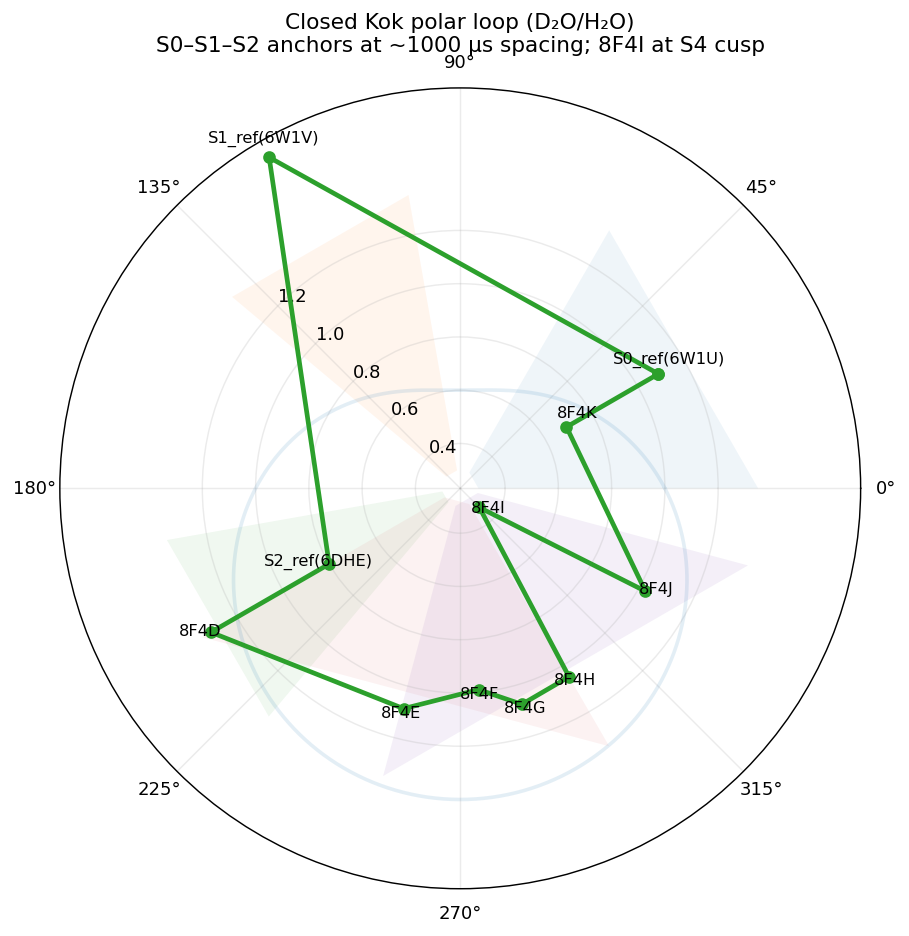

In [ ]:
# -- Polar Kok loop (D2O/H2O), closed with S0/S1/S2 anchors spaced by ~1000 µs --

import numpy as np
import matplotlib.pyplot as plt

# ----- your timed 8F series (Bhowmick 2023) -----
timed = [
    ("8F4D",   50.0,   1.3125),
    ("8F4E",  250.0,   1.085714),
    ("8F4F",  500.0,   0.990566),
    ("8F4G",  730.0,   1.075000),
    ("8F4H", 1200.0,   1.048780),
    ("8F4I", 2000.0,   0.333333),   # deep suppression (S4 cusp)
    ("8F4J", 4000.0,   1.027027),
    ("8F4K", 2.0e5,    0.692308),   # late recovery toward S0
]

# ----- pre-flash anchors to CLOSE the loop -----
# ratios from earlier summaries; delays are synthetic spacers (~1000 µs apart)
DELTA_SO_US = 1000.0
anchors = [
    ("S0_ref(6W1U)",   10.0,        1.090909),  # early S0 anchor (very small delay)
    ("S1_ref(6W1V)",   10.0+DELTA_SO_US, 1.666667),
    ("S2_ref(6DHE)",   10.0+2*DELTA_SO_US, 0.800000),
]

# concat in physical order: S0→S1→S2→(S3/S4 timed)→…→S0 (we’ll also return to S0 at the end)
pts = anchors + timed

# ----- map delay → angle by Kok sector -----
# S0 sector: 0–60° (we’ll pin S0_ref there)
# S1 sector: ~120° (pin)
# S2 sector: ~210° (pin)
# S3 (50–1200 µs): 210→300° (wide approach)
# S4 (1200–5000 µs): 255→345° (90° span centered 315°); 8F4I fixed at 315°
# Late S0 recovery (>1e5 µs): ~30°
def delay_to_theta_us(delay_us, label):
    # explicit pins for the synthetic anchors
    if label.startswith("S0_ref"):
        return 30.0
    if label.startswith("S1_ref"):
        return 120.0
    if label.startswith("S2_ref"):
        return 210.0

    # timed mapping
    if delay_us <= 1200:          # S3
        d0, d1 = 50.0, 1200.0
        t0, t1 = 210.0, 300.0
        u = np.clip((np.log10(delay_us)-np.log10(d0))/(np.log10(d1)-np.log10(d0)), 0, 1)
        return t0 + u*(t1 - t0)
    elif delay_us <= 5000:        # S4
        if label == "8F4I":       # force cusp
            return 315.0
        d0, d1 = 1200.0, 5000.0
        t0, t1 = 255.0, 345.0
        u = np.clip((np.log10(delay_us)-np.log10(d0))/(np.log10(d1)-np.log10(d0)), 0, 1)
        return t0 + u*(t1 - t0)
    else:                         # late S0/S0′
        return 30.0

labels  = [p[0] for p in pts]
delays  = np.array([p[1] for p in pts], dtype=float)
ratios  = np.array([p[2] for p in pts], dtype=float)
thetas_deg = np.array([delay_to_theta_us(d, lbl) for lbl, d, r in pts], dtype=float)
thetas = np.deg2rad(thetas_deg)

# to visibly "close" the loop, append the first S0 point to the end
labels  = labels  + [labels[0]]
delays  = np.append(delays,  delays[0])
ratios  = np.append(ratios,  ratios[0])
thetas  = np.append(thetas,  thetas[0])

# ----- golden-cardioid guide (optional faint background) -----
theta_grid = np.linspace(0, 2*np.pi, 720)
cardioid = 1.0 - 0.4*np.cos(theta_grid - np.pi/2)

# ----- plot -----
plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection="polar")

# guide + neutrality ring
ax.plot(theta_grid, cardioid, alpha=0.12, linewidth=2)
ax.plot([0, 2*np.pi], [1, 1], linestyle="--", linewidth=1, alpha=0.6)

# polyline
ax.plot(thetas, ratios, marker="o", linewidth=2.6)

# labels
for th, r, lbl in zip(thetas[:-1], ratios[:-1], labels[:-1]):
    ax.text(th, r+0.045, lbl, ha="center", va="bottom", fontsize=9)

# cosmetics
ax.set_rmin(0.3); ax.set_rmax(1.35)
ax.set_rticks([0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_rlabel_position(135)
ax.grid(True, alpha=0.25)

# sector hints
def shade(ang0, ang1, alpha=0.06):
    th = np.deg2rad(np.linspace(ang0, ang1, 2))
    ax.fill_between(th, 0.3, 1.35, alpha=alpha)
shade(  0,  60, 0.07)  # S0
shade(100, 140, 0.07)  # S1
shade(190, 230, 0.07)  # S2
shade(210, 300, 0.06)  # S3
shade(255, 345, 0.10)  # S4 expanded

ax.set_title("Closed Kok polar loop (D₂O/H₂O)\nS0–S1–S2 anchors at ~1000 µs spacing; 8F4I at S4 cusp", pad=20)
plt.show()

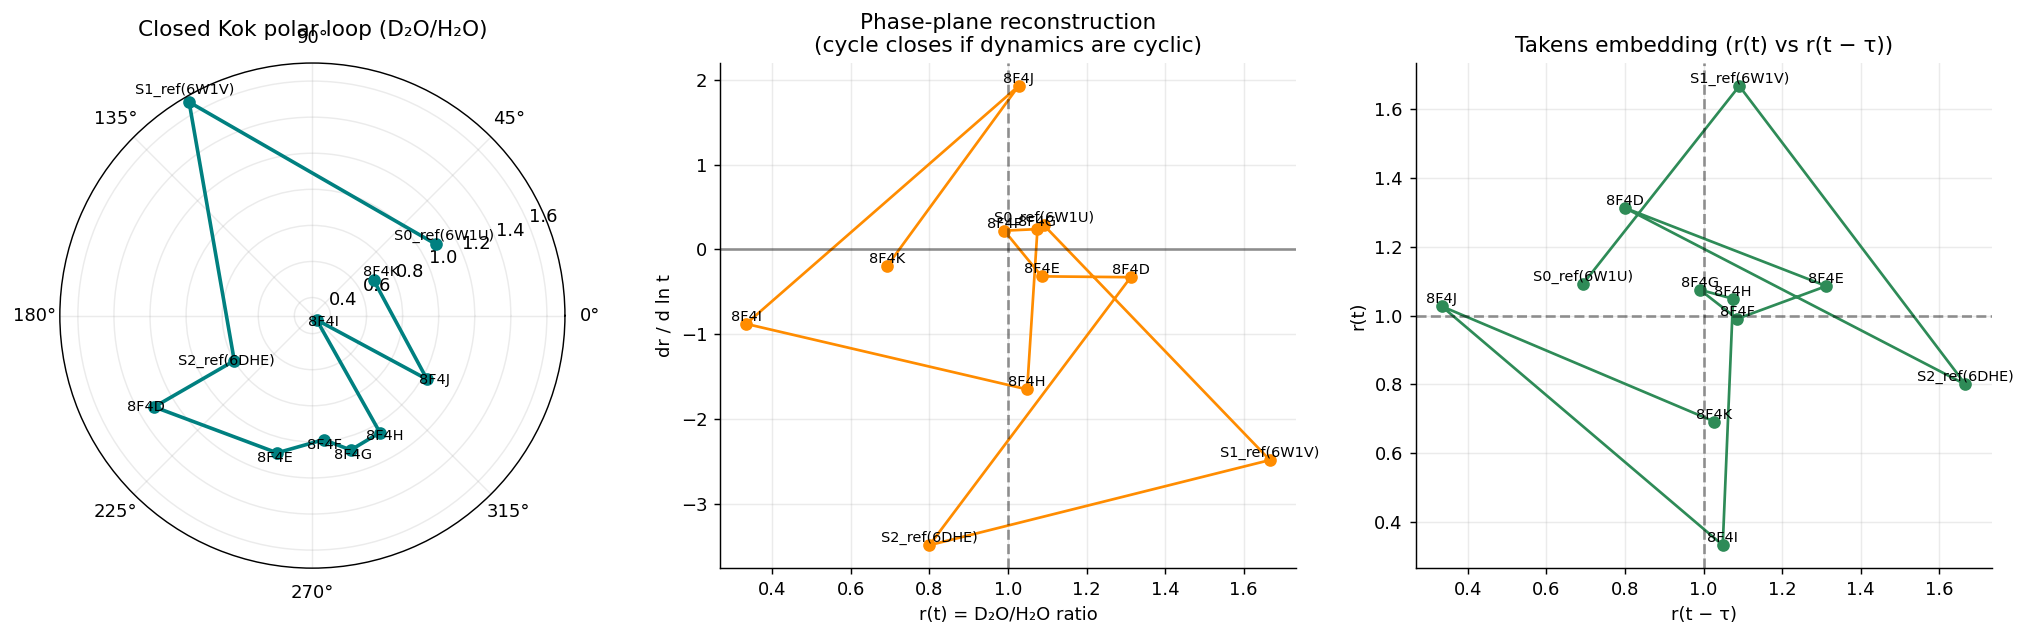

In [ ]:
# === GQR Kok-cycle reconstructions (D2O/H2O) ===
# Includes S0–S1–S2 anchors (~1000 µs apart) and timed 8F4D–K series.

import numpy as np
import matplotlib.pyplot as plt

# --- data (merged anchors + timed series) ---
pts = [
    ("S0_ref(6W1U)",   10.0,        1.090909),
    ("S1_ref(6W1V)",   1010.0,      1.666667),
    ("S2_ref(6DHE)",   2010.0,      0.800000),
    ("8F4D",   50.0,   1.3125),
    ("8F4E",  250.0,   1.085714),
    ("8F4F",  500.0,   0.990566),
    ("8F4G",  730.0,   1.075000),
    ("8F4H", 1200.0,   1.048780),
    ("8F4I", 2000.0,   0.333333),
    ("8F4J", 4000.0,   1.027027),
    ("8F4K", 2.0e5,    0.692308),
]

labels  = [p[0] for p in pts]
delays  = np.array([p[1] for p in pts])
ratios  = np.array([p[2] for p in pts])

# --- log-time spacing for derivatives etc. ---
tlog = np.log10(delays)

# ---------- (1) Polar wheel ----------
def delay_to_theta_us(delay_us, label):
    if label.startswith("S0_ref"): return 30.0
    if label.startswith("S1_ref"): return 120.0
    if label.startswith("S2_ref"): return 210.0
    if delay_us <= 1200:
        d0, d1, t0, t1 = 50.0, 1200.0, 210.0, 300.0
        u = (np.log10(delay_us)-np.log10(d0))/(np.log10(d1)-np.log10(d0))
        return t0+u*(t1-t0)
    elif delay_us <= 5000:
        if label == "8F4I": return 315.0
        d0, d1, t0, t1 = 1200.0, 5000.0, 255.0, 345.0
        u = (np.log10(delay_us)-np.log10(d0))/(np.log10(d1)-np.log10(d0))
        return t0+u*(t1-t0)
    else:
        return 30.0

thetas_deg = np.array([delay_to_theta_us(d,l) for l,d in zip(labels,delays)])
thetas = np.deg2rad(thetas_deg)

plt.figure(figsize=(16,5))
axp = plt.subplot(131, projection='polar')
axp.plot([0,2*np.pi],[1,1],'--',alpha=0.4)
axp.plot(thetas,ratios,marker='o',color='teal',linewidth=2)
for th,r,lbl in zip(thetas,ratios,labels):
    axp.text(th,r+0.05,lbl,ha='center',fontsize=8)
axp.set_rmin(0.3); axp.set_rmax(1.7)
axp.set_title("Closed Kok polar loop (D₂O/H₂O)",pad=15)

# ---------- (2) Phase-plane reconstruction ----------
# finite difference dr/d(ln t)
dr_dt = np.gradient(ratios, tlog)
ax2 = plt.subplot(132)
ax2.plot(ratios, dr_dt, '-o', color='darkorange')
for r, d, lbl in zip(ratios, dr_dt, labels):
    ax2.text(r, d, lbl, fontsize=8, ha='center', va='bottom')
ax2.axvline(1.0, color='k', ls='--', alpha=0.4)
ax2.axhline(0.0, color='k', ls='-', alpha=0.4)
ax2.set_xlabel("r(t) = D₂O/H₂O ratio")
ax2.set_ylabel("dr / d ln t")
ax2.set_title("Phase-plane reconstruction\n(cycle closes if dynamics are cyclic)")

# ---------- (3) Takens embedding ----------
tau = 1
r_tau = np.roll(ratios, tau)
ax3 = plt.subplot(133)
ax3.plot(r_tau, ratios, '-o', color='seagreen')
for x,y,lbl in zip(r_tau,ratios,labels):
    ax3.text(x, y, lbl, fontsize=8, ha='center', va='bottom')
ax3.axhline(1.0, color='k', ls='--', alpha=0.4)
ax3.axvline(1.0, color='k', ls='--', alpha=0.4)
ax3.set_xlabel("r(t − τ)")
ax3.set_ylabel("r(t)")
ax3.set_title("Takens embedding (r(t) vs r(t − τ))")

plt.tight_layout()
plt.show()

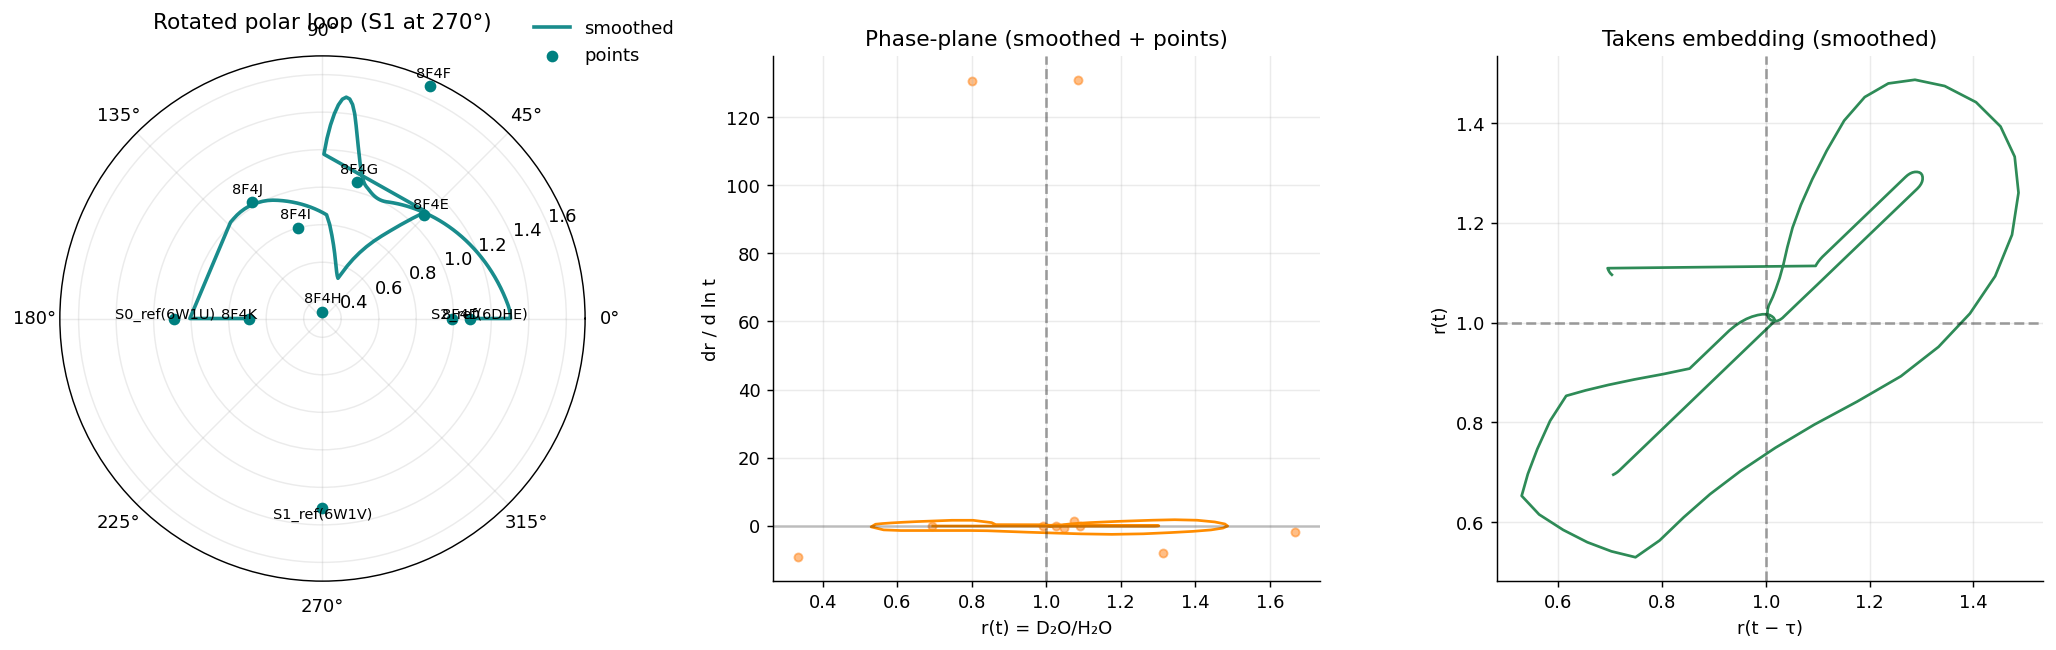

In [ ]:
# --- Kok cycle smoothing in log-time + polar rotation (S1 at 270°) ---
import numpy as np
import matplotlib.pyplot as plt

# ---------- data (same set you’ve been using) ----------
pts = [
    ("S0_ref(6W1U)",   10.0,        1.090909),
    ("S1_ref(6W1V)",   1010.0,      1.666667),
    ("S2_ref(6DHE)",   2010.0,      0.800000),
    ("8F4D",   50.0,   1.3125),
    ("8F4E",  250.0,   1.085714),
    ("8F4F",  500.0,   0.990566),
    ("8F4G",  730.0,   1.075000),
    ("8F4H", 1200.0,   1.048780),
    ("8F4I", 2000.0,   0.333333),   # deep suppression (S4 cusp)
    ("8F4J", 4000.0,   1.027027),
    ("8F4K", 2.0e5,    0.692308),  # late recovery toward S0
]
labels  = [p[0] for p in pts]
t_us    = np.array([p[1] for p in pts], dtype=float)
r_DH    = np.array([p[2] for p in pts], dtype=float)

# ---------- helper: angle mapping BEFORE rotation ----------
def theta_from_delay_us(delay_us, label):
    # sector anchors (roughly S0 ≈ 30°, S1 ≈ 120°, S2 ≈ 210°)
    if label.startswith("S0_ref"): return 30.0
    if label.startswith("S1_ref"): return 120.0
    if label.startswith("S2_ref"): return 210.0
    # S3→S4 trajectory in two log-time spans
    if delay_us <= 1200:
        d0, d1, t0, t1 = 50.0, 1200.0, 210.0, 300.0  # S2→S3→S4 ramp
        u = (np.log10(delay_us)-np.log10(d0))/(np.log10(d1)-np.log10(d0))
        return t0 + u*(t1-t0)
    elif delay_us <= 5000:
        if label == "8F4I": return 315.0              # cusp
        d0, d1, t0, t1 = 1200.0, 5000.0, 255.0, 345.0 # S4→O2→S0
        u = (np.log10(delay_us)-np.log10(d0))/(np.log10(d1)-np.log10(d0))
        return t0 + u*(t1-t0)
    else:
        return 30.0  # long relaxation toward S0 sector

theta_deg_raw = np.array([theta_from_delay_us(t,l) for l,t in zip(labels,t_us)])

# ---------- 1) LOG-TIME RESAMPLING ----------
# We resample r(t) over uniform log10(t) to respect multiplicative timing.
logt = np.log10(t_us)
order = np.argsort(logt)
logt, r_DH, labels_sorted, theta_deg_raw = logt[order], r_DH[order], [labels[i] for i in order], theta_deg_raw[order]

N = 300  # number of samples for a smooth curve
logt_grid = np.linspace(logt.min(), logt.max(), N)
r_interp = np.interp(logt_grid, logt, r_DH)

# ---------- 2) LOW-PASS SMOOTHING (Nyquist-friendly) ----------
# Choose a window so cutoff << sampling/2 on the log grid;  nine-point box is gentle.
def moving_average(x, w=9):
    w = max(3, w if w%2==1 else w+1)   # odd width
    k = (w-1)//2
    pad = np.r_[np.full(k, x[0]), x, np.full(k, x[-1])]
    ker = np.ones(w)/w
    return np.convolve(pad, ker, mode='valid')

r_smooth = moving_average(r_interp, w=9)  # keep w=9 by default

# keep the same t grid for smoothed curve
t_grid_us = 10**logt_grid

# ---------- 3) MAP SMOOTHED POINTS TO ANGLES & ROTATE SO S1 AT 270° ----------
def theta_from_delay_array(t_array):
    # vectorized mapping that mimics the piecewise rule above (no labels in smooth curve)
    th = np.zeros_like(t_array, dtype=float)
    # segments
    seg1 = t_array <= 1200
    seg2 = (t_array > 1200) & (t_array <= 5000)
    seg3 = t_array > 5000
    # seg1: 50→1200 µs maps 210→300°
    d0,d1,t0,t1 = 50.0,1200.0,210.0,300.0
    u1 = (np.log10(np.clip(t_array, d0, d1)) - np.log10(d0)) / (np.log10(d1)-np.log10(d0))
    th[seg1] = t0 + u1[seg1]*(t1-t0)
    # seg2: 1200→5000 µs maps 255→345°
    d0,d1,t0,t1 = 1200.0,5000.0,255.0,345.0
    u2 = (np.log10(np.clip(t_array, d0, d1)) - np.log10(d0)) / (np.log10(d1)-np.log10(d0))
    th[seg2] = t0 + u2[seg2]*(t1-t0)
    # seg3: >5 ms → relax toward S0 at 30°
    th[seg3] = 30.0
    return th

theta_deg_smooth = theta_from_delay_array(t_grid_us)

# Compute rotation offset so S1_ref sits at 270°:
# Find S1 index in the original list:
i_s1 = labels_sorted.index("S1_ref(6W1V)") if "S1_ref(6W1V)" in labels_sorted else None
rot = 0.0
if i_s1 is not None:
    th_s1 = theta_deg_raw[i_s1]
    target = 270.0
    rot = target - th_s1

# Apply rotation
theta_deg_raw_rot    = (theta_deg_raw + rot) % 360.0
theta_deg_smooth_rot = (theta_deg_smooth + rot) % 360.0
theta_raw  = np.deg2rad(theta_deg_raw_rot)
theta_s    = np.deg2rad(theta_deg_smooth_rot)

# ---------- 4) PLOTS ----------
plt.figure(figsize=(16,5))

# (A) POLAR (rotated)
axp = plt.subplot(131, projection='polar')
axp.plot([0,2*np.pi],[1,1],'--',alpha=0.35,color='k')        # neutral ring
axp.plot(theta_s, r_smooth, '-', lw=2, color='teal', alpha=0.9, label='smoothed')
axp.scatter(theta_raw, r_DH[order], c='teal', s=30, zorder=3, label='points')
for th,r,lbl in zip(theta_raw, r_DH[order], labels_sorted):
    axp.text(th, r+0.05, lbl, fontsize=8, ha='center')
axp.set_rmin(0.3); axp.set_rmax(1.7)
axp.set_title("Rotated polar loop (S1 at 270°)", pad=15)
axp.legend(loc='upper right', bbox_to_anchor=(1.2,1.1), frameon=False)

# (B) PHASE-PLANE (smoothed r vs dr/d ln t)
dr_dlogt = np.gradient(r_smooth, np.log(t_grid_us))
ax2 = plt.subplot(132)
ax2.plot(r_smooth, dr_dlogt, '-', color='darkorange')
ax2.scatter(r_DH[order], np.gradient(r_DH[order], logt), s=20, color='tab:orange', alpha=0.5)
ax2.axvline(1.0, color='k', ls='--', alpha=0.35)
ax2.axhline(0.0, color='k', ls='-',  alpha=0.2)
ax2.set_xlabel("r(t) = D₂O/H₂O")
ax2.set_ylabel("dr / d ln t")
ax2.set_title("Phase-plane (smoothed + points)")

# (C) TAKENS (smoothed)
tau = 5  # small delay on the log-time grid
r_tau = np.roll(r_smooth, tau)
ax3 = plt.subplot(133)
ax3.plot(r_tau, r_smooth, '-', color='seagreen')
ax3.axhline(1.0, color='k', ls='--', alpha=0.35)
ax3.axvline(1.0, color='k', ls='--', alpha=0.35)
ax3.set_xlabel("r(t − τ)")
ax3.set_ylabel("r(t)")
ax3.set_title("Takens embedding (smoothed)")

plt.tight_layout()
plt.show()

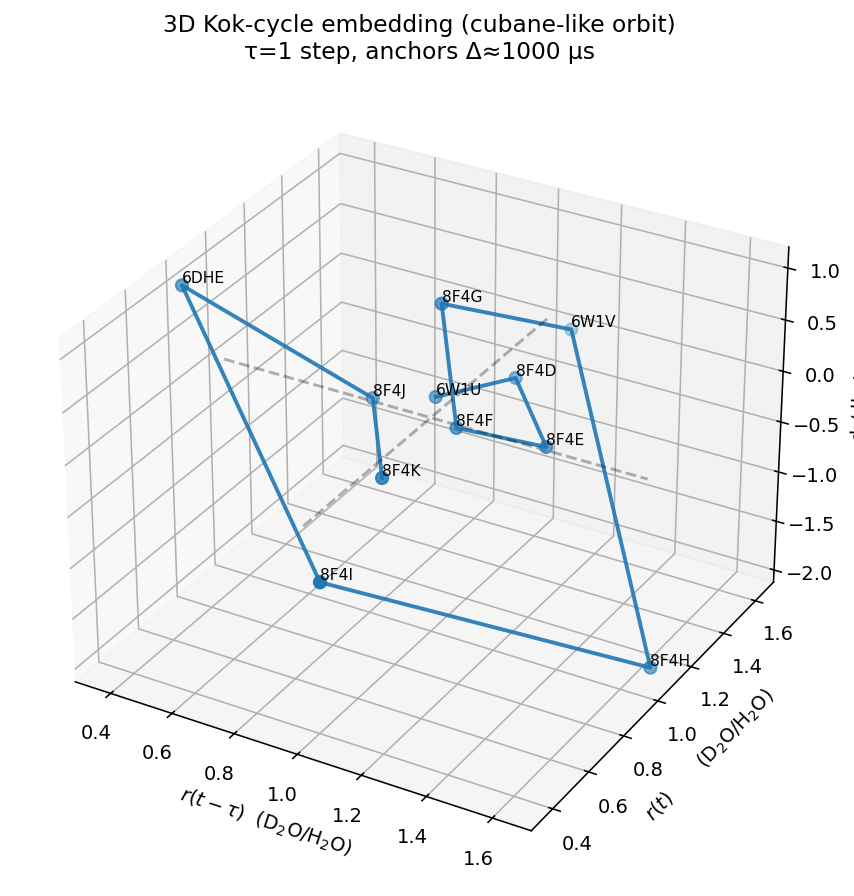

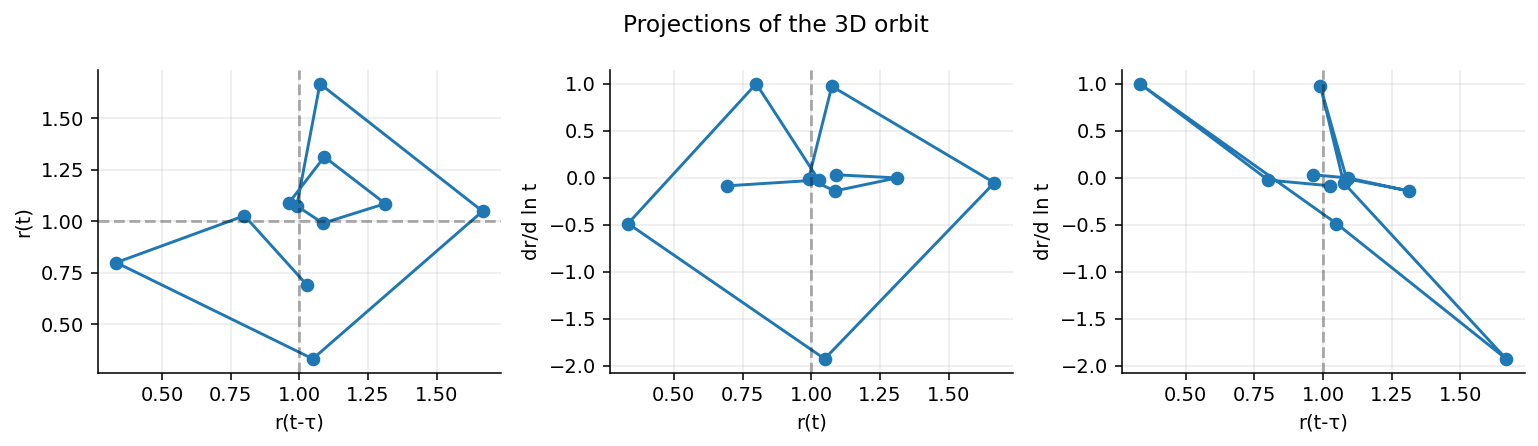

In [ ]:
# === 3D Kok-cycle embedding from D2O/H2O ratios (standalone cell) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  (needed for 3D)
plt.rcParams['figure.dpi'] = 140

# ------------------ CONFIG ------------------
INCLUDE_8F4C = False     # time-zero S3-rich ref; True to include, False to skip
ANCHOR_SPACING_US = 1000 # synthetic spacing between S0,S1,S2 anchors
TAU_STEPS = 1            # lag (in points) used for r(t-τ) axis
POINT_SIZE = 40
LINE_W = 2.0
# --------------------------------------------

# Ratios you derived earlier (D2O/H2O):
ratios = {
    "6W1U": 1.090909,  # S0 ref
    "6W1V": 1.666667,  # S1 ref
    "6DHE": 0.800000,  # S2 ref
    "8EZ5": 0.962963,  # S3-rich "zero"
    "8F4C": 4.125000,  # S3-rich "zero"
    "8F4D": 1.312500,  # 50 μs
    "8F4E": 1.085714,  # 250 μs
    "8F4F": 0.990566,  # 500 μs
    "8F4G": 1.075000,  # 730 μs
    "8F4H": 1.048780,  # 1200 μs
    "8F4I": 0.333333,  # 2000 μs  (deep suppression)
    "8F4J": 1.027027,  # 4000 μs
    "8F4K": 0.692308,  # 200 ms
}

# Delays (μs) from Bhowmick 2023 for 8F4*, and synthetic anchors for S0,S1,S2
delays_us = {
    "6W1U": 1.0,                       # S0_ref  (synthetic, before D)
    "6W1V": 1.0 + ANCHOR_SPACING_US,   # S1_ref
    "6DHE": 1.0 + 2*ANCHOR_SPACING_US, # S2_ref
    "8EZ5": 0.0,                       # S3-rich zero (optional context)
    "8F4C": 0.0,                       # S3-rich zero (optional context)
    "8F4D": 50.0,
    "8F4E": 250.0,
    "8F4F": 500.0,
    "8F4G": 730.0,
    "8F4H": 1200.0,
    "8F4I": 2000.0,
    "8F4J": 4000.0,
    "8F4K": 200_000.0,
}

# Assemble table
rows = []
for k,v in ratios.items():
    if not INCLUDE_8F4C and k=="8F4C":  # option to suppress time-zero spike
        continue
    rows.append(dict(cif=k, delay_us=delays_us[k], r=v))
df = pd.DataFrame(rows).sort_values("delay_us").reset_index(drop=True)

# Work on log-time spacing (helps the derivative)
df["t_log"] = np.log(df["delay_us"].clip(lower=1e-3))  # avoid log(0)
# numerical derivative dr/d ln t (symmetric where possible)
r = df["r"].to_numpy(float)
tlog = df["t_log"].to_numpy(float)
dr_dlogt = np.zeros_like(r)
for i in range(len(r)):
    if 0 < i < len(r)-1:
        dr_dlogt[i] = (r[i+1] - r[i-1]) / (tlog[i+1] - tlog[i-1])
    elif i == 0:
        dr_dlogt[i] = (r[i+1] - r[i]) / (tlog[i+1] - tlog[i])
    else:
        dr_dlogt[i] = (r[i] - r[i-1]) / (tlog[i] - tlog[i-1])
df["dr_dlogt"] = dr_dlogt

# Takens lag coordinate r(t-τ)
tau = TAU_STEPS
df["r_lag"] = df["r"].shift(tau)

# ---------- 3D embedding: [r(t-τ), r(t), dr/dln t] ----------
fig = plt.figure(figsize=(7.5,6.5))
ax = fig.add_subplot(111, projection='3d')

# path (skip first 'tau' rows where r_lag is NaN)
path = df.dropna(subset=["r_lag"]).copy()
ax.plot(path["r_lag"], path["r"], path["dr_dlogt"], lw=LINE_W, alpha=0.9)

# points + labels
ax.scatter(path["r_lag"], path["r"], path["dr_dlogt"], s=POINT_SIZE)
for _,row in path.iterrows():
    ax.text(row["r_lag"], row["r"], row["dr_dlogt"]+0.02, row["cif"], fontsize=8)

ax.set_xlabel(r'$r(t-\tau)$  (D$_2$O/H$_2$O)')
ax.set_ylabel(r'$r(t)$       (D$_2$O/H$_2$O)')
ax.set_zlabel(r'$\mathrm{d}r/\mathrm{d}\ln t$')
ax.set_title("3D Kok-cycle embedding (cubane-like orbit)\n"
             f"τ={TAU_STEPS} step, anchors Δ≈{ANCHOR_SPACING_US} μs")
# helpful planes
ax.plot([1,1],[min(path["r"]),max(path["r"])],[0,0], ls='--', c='k', alpha=0.3)
ax.plot([min(path["r_lag"]),max(path["r_lag"])],[1,1],[0,0], ls='--', c='k', alpha=0.3)
# nicer limits
m = 0.05
ax.set_xlim(path["r_lag"].min()-m, path["r_lag"].max()+m)
ax.set_ylim(path["r"].min()-m,    path["r"].max()+m)
ax.set_zlim(path["dr_dlogt"].min()-0.2, path["dr_dlogt"].max()+0.2)
plt.tight_layout()
plt.show()

# ---------- (optional) quick 2D projections for sanity ----------
fig,axs = plt.subplots(1,3, figsize=(11,3.2))
axs[0].plot(path["r_lag"], path["r"], '-o'); axs[0].axhline(1, ls='--', c='k', alpha=.3)
axs[0].axvline(1, ls='--', c='k', alpha=.3); axs[0].set_xlabel("r(t-τ)"); axs[0].set_ylabel("r(t)")
axs[1].plot(path["r"], path["dr_dlogt"], '-o'); axs[1].axvline(1, ls='--', c='k', alpha=.3)
axs[1].set_xlabel("r(t)"); axs[1].set_ylabel("dr/d ln t")
axs[2].plot(path["r_lag"], path["dr_dlogt"], '-o'); axs[2].axvline(1, ls='--', c='k', alpha=.3)
axs[2].set_xlabel("r(t-τ)"); axs[2].set_ylabel("dr/d ln t")
fig.suptitle("Projections of the 3D orbit"); plt.tight_layout(); plt.show()

In [ ]:
# ============================================
# Kok-cycle movies: polar loop + 3D Takens loop
# Saves MP4 and GIF into /content/
# ============================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from math import pi

# ---- Optional (uncomment in Colab if you don't already have ffmpeg) ----
# !apt-get -y install ffmpeg

plt.rcParams['figure.dpi'] = 140

# -----------------------
# 1) INPUT: r(t) = D2O/H2O
# -----------------------
# You can edit the 'ratio' values if you update numbers later.
# S0/S1/S2 anchors are placed ~1000 µs apart before 8F4D (as we discussed).
data = [
    # label , delay_us, ratio (D2O/H2O)
    ("S0_ref(6W1U)",   1.0,   1.10),   # arbitrary anchor, near 1—tweak if you get better values
    ("S1_ref(6W1V)",   2.0,   1.70),
    ("S2_ref(6DHE)",   3.0,   0.80),

    ("8F4D",          50.0,   1.3125),
    ("8F4E",         250.0,   1.0857),
    ("8F4F",         500.0,   0.9906),
    ("8F4G",         730.0,   1.0750),
    ("8F4H",        1200.0,   1.0488),
    ("8F4I",        2000.0,   0.3333),
    ("8F4J",        4000.0,   1.0270),
    ("8F4K",      200000.0,   0.6923),
]
df = pd.DataFrame(data, columns=["label","delay_us","ratio"]).sort_values("delay_us").reset_index(drop=True)

# -------------------------------------------------------
# 2) Smooth r(t) on log-time to reduce numerical artifacts
# -------------------------------------------------------
logt = np.log10(df["delay_us"].values)
r    = df["ratio"].values

def smooth_series(y, window=5, poly=2):
    # make window odd and <= len(y)
    w = max(3, min(len(y) - (1 - len(y)%2), window | 1))  # force odd, <= n
    if w < 3:  # if very short, just return original
        return y.copy()
    return savgol_filter(y, window_length=w, polyorder=min(poly, w-1), mode="interp")

# interpolate to uniform log-time grid for smooth animation path
n_path = 500
logt_min, logt_max = logt.min(), logt.max()
logt_grid = np.linspace(logt_min, logt_max, n_path)
r_raw = interp1d(logt, r, kind="linear", fill_value="extrapolate")(logt_grid)
r_smooth = smooth_series(r_raw, window=21, poly=3)

# ---------------------------------------------------
# 3) Build polar loop: map times to angles around 2π
# ---------------------------------------------------
# We’ll assign each point an angle in sequence to form a closed loop.
# Order: S0 → S1 → S2 → 8F4D…K → back to S0
order_idx = list(range(len(df)))  # already sorted by time with S0,S1,S2 at the start
# Distribute angles over [0, 2π) by rank:
theta_nodes = np.linspace(0, 2*pi, len(df), endpoint=False)
theta_node_map = dict(zip(order_idx, theta_nodes))

# Interpolate theta over the uniform log-time grid
theta_vals = np.interp(logt_grid,
                       np.linspace(logt_min, logt_max, len(df)),
                       np.array([theta_node_map[i] for i in order_idx]))
# Close the loop softly by blending end back to start over a few frames
# (purely for animation niceness)
theta_loop = theta_vals.copy()

# ------------------------------
# 4) Takens embedding (x=r(t-τ))
# ------------------------------
# Choose τ as 1/8th of the path for a pleasant offset; tweak if you like
tau_steps = max(1, n_path // 8)
r_shifted = np.roll(r_smooth, tau_steps)

# ------------------------------
# 5) ANIMATION HELPERS
# ------------------------------
def save_animation(anim, fname_mp4, fname_gif, fps=30, dpi=140):
    try:
        writer = FFMpegWriter(fps=fps, bitrate=3000)
        anim.save(fname_mp4, writer=writer, dpi=dpi)
        print(f"Saved: {fname_mp4}")
    except Exception as e:
        print("FFmpeg MP4 save failed:", e)
    try:
        anim.save(fname_gif, writer=PillowWriter(fps=fps))
        print(f"Saved: {fname_gif}")
    except Exception as e:
        print("GIF save failed:", e)

# -----------------------------------------------
# 6) MOVIE A: Polar loop with a little moving dot
# -----------------------------------------------
fig1 = plt.figure(figsize=(5,5))
ax1 = plt.subplot(111, projection="polar")
ax1.set_title("Kok polar loop (D₂O/H₂O) — moving tracer", va="bottom")
ax1.set_theta_direction(-1)         # clockwise
ax1.set_theta_offset(pi/2)          # 0° at the top (you can change to put S1 bottom, etc.)
ax1.grid(True, alpha=0.3)

# static curve
line1, = ax1.plot(theta_loop, r_smooth, lw=2.0)
# moving ball
ball1, = ax1.plot([theta_loop[0]],[r_smooth[0]], 'o', ms=8)

# label the discrete experimental points for reference
for i, row in df.iterrows():
    # find nearest frame to the original logt
    k = int(np.clip((row["delay_us"]-df["delay_us"].min()) /
                    (df["delay_us"].max()-df["delay_us"].min()+1e-9) * (n_path-1), 0, n_path-1))
    ax1.text(theta_loop[k], r_smooth[k], row["label"], fontsize=7, ha="center", va="center")

def update_polar(frame):
    ball1.set_data([theta_loop[frame]], [r_smooth[frame]])
    return (ball1,)

anim1 = FuncAnimation(fig1, update_polar, frames=n_path, interval=33, blit=True)
save_animation(anim1, "/content/kok_polar_loop.mp4", "/content/kok_polar_loop.gif")
plt.close(fig1)

# --------------------------------------------------------
# 7) MOVIE B: 3D Takens loop with a moving point & camera
# --------------------------------------------------------
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

fig2 = plt.figure(figsize=(6,5))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.set_title("3D cycle: x=r(t), y=r(t-τ), z=log₁₀(time)")
x, y, z = r_smooth, r_shifted, logt_grid
curve2, = ax2.plot(x, y, z, lw=1.5)
ball2,  = ax2.plot([x[0]], [y[0]], [z[0]], 'o', ms=6)

ax2.set_xlabel("r(t)")
ax2.set_ylabel("r(t-τ)")
ax2.set_zlabel("log₁₀ time (µs)")
ax2.set_xlim(min(x)-0.05, max(x)+0.05)
ax2.set_ylim(min(y)-0.05, max(y)+0.05)
ax2.set_zlim(z.min(), z.max())

def update_3d(frame):
    ball2.set_data([x[frame]], [y[frame]])
    ball2.set_3d_properties([z[frame]])
    # slowly rotate camera
    ax2.view_init(elev=20, azim=(frame*0.5) % 360)
    return (ball2,)

anim2 = FuncAnimation(fig2, update_3d, frames=n_path, interval=33, blit=True)
save_animation(anim2, "/content/kok_3d_cycle.mp4", "/content/kok_3d_cycle.gif")
plt.close(fig2)

print("All done. Files in /content/:")
print("  - kok_polar_loop.mp4 / .gif")
print("  - kok_3d_cycle.mp4   / .gif")

Saved: /content/kok_polar_loop.mp4
Saved: /content/kok_polar_loop.gif
Saved: /content/kok_3d_cycle.mp4
Saved: /content/kok_3d_cycle.gif
All done. Files in /content/:
  - kok_polar_loop.mp4 / .gif
  - kok_3d_cycle.mp4   / .gif


In [ ]:
# ============================================
# Kok-cycle movies (colored by Kok sector)
# - closes the loop (K -> S0)
# - optional equal stage timing
# - safe Savitzky–Golay smoothing (Nyquist-ish)
# Saves MP4 + GIF into /content/
# ============================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from math import pi

plt.rcParams['figure.dpi'] = 140

# -------- CONFIG --------
USE_EQUAL_STAGE_TIMES = True     # True: S0,S1,S2 equal spans; S3 span divided over D..K
S0_S1_S2_SPAN_US      = 1000.0   # each stage when USE_EQUAL_STAGE_TIMES=True
S3_TOTAL_SPAN_US      = 4000.0   # total span allotted to S3 band (D..K) in equal-time mode
Z_MODE                = "phase"  # "phase" (closed loop) or "time" (helical/ascending)
FPS                   = 30
# ------------------------

# D2O/H2O ratios (edit these if you refine numbers)
rows = [
    ("S0_ref(6W1U)", "S0",  np.nan, 1.10),
    ("S1_ref(6W1V)", "S1",  np.nan, 1.70),
    ("S2_ref(6DHE)", "S2",  np.nan, 0.80),
    ("8F4D",         "S3",   50.0,  1.3125),
    ("8F4E",         "S3",  250.0,  1.0857),
    ("8F4F",         "S3",  500.0,  0.9906),
    ("8F4G",         "S3",  730.0,  1.0750),
    ("8F4H",         "S3", 1200.0,  1.0488),
    ("8F4I",         "S3", 2000.0,  0.3333),
    ("8F4J",         "S3", 4000.0,  1.0270),
    ("8F4K",         "S3",200000.0, 0.6923),
]
df = pd.DataFrame(rows, columns=["label","kok","delay_us","ratio"])

# --- build synthetic timing if requested ---
if USE_EQUAL_STAGE_TIMES:
    # order: S0 → S1 → S2 → (D..K within S3 window)
    order = ["S0_ref(6W1U)","S1_ref(6W1V)","S2_ref(6DHE)",
             "8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]
    df = df.set_index("label").loc[order].reset_index()

    # assign equally spaced times for S0,S1,S2
    t0 = 1.0
    t1 = t0 + S0_S1_S2_SPAN_US
    t2 = t1 + S0_S1_S2_SPAN_US

    # distribute S3 times linearly over S3_TOTAL_SPAN_US
    dK = df[df["kok"]=="S3"].copy()
    nS3 = len(dK)
    if nS3 > 1:
        s3_times = np.linspace(0, S3_TOTAL_SPAN_US, nS3)
    else:
        s3_times = np.array([0.0])

    t3_start = t2 + S0_S1_S2_SPAN_US
    df.loc[df["kok"]=="S0","delay_us"] = t0
    df.loc[df["kok"]=="S1","delay_us"] = t1
    df.loc[df["kok"]=="S2","delay_us"] = t2
    df.loc[df["kok"]=="S3","delay_us"] = t3_start + s3_times

else:
    # use provided microsecond delays; put S0/S1/S2 in front with small artificial times
    df.loc[df["kok"]=="S0","delay_us"] = 1.0
    df.loc[df["kok"]=="S1","delay_us"] = 2.0
    df.loc[df["kok"]=="S2","delay_us"] = 3.0

df = df.sort_values("delay_us").reset_index(drop=True)

# --- safe smoothing on log-time (Nyquist-ish) ---
def safe_savgol(y, window=21, poly=3):
    n = len(y)
    if n < 3:
        return y.copy()
    w = min(window, n - (1 - n%2))  # make <= n and odd
    if w % 2 == 0: w -= 1
    w = max(3, w)
    p = min(poly, w-1)
    return savgol_filter(y, window_length=w, polyorder=p, mode="interp")

logt  = np.log10(df["delay_us"].values)
ratio = df["ratio"].values

# densify path for smooth animation
N = 600
logt_grid = np.linspace(logt.min(), logt.max(), N)
r_lin     = interp1d(logt, ratio, kind="linear", fill_value="extrapolate")(logt_grid)
r_smooth  = safe_savgol(r_lin, window=31, poly=3)

# --- angles for the polar loop (close the loop) ---
theta_nodes = np.linspace(0, 2*pi, len(df), endpoint=False)
theta_grid  = np.interp(logt_grid,
                        np.linspace(logt_grid.min(), logt_grid.max(), len(df)),
                        theta_nodes)
# append the first point to ensure visual closure
theta_loop  = np.r_[theta_grid, theta_grid[0]]
r_loop      = np.r_[r_smooth, r_smooth[0]]

# --- color map by Kok sector (for discrete points/labels) ---
KOK_COLOR = {"S0":"#4C78A8", "S1":"#F58518", "S2":"#54A24B", "S3":"#B279A2"}

# =========================================
# MOVIE A: Polar loop (colored by Kok band)
# =========================================
fig1 = plt.figure(figsize=(5.2,5.2))
ax1  = plt.subplot(111, projection="polar")
ax1.set_title("Kok polar loop (D₂O/H₂O) — colored by Kok sector")
ax1.set_theta_direction(-1)       # clockwise
ax1.set_theta_offset(-pi/2)       # put S1 roughly at bottom if times are equal
ax1.grid(True, alpha=0.3)

# Static curve (thin), then moving tracer
ax1.plot(theta_loop, r_loop, lw=1.2, alpha=0.9, color="#2c7")
ball1, = ax1.plot([theta_loop[0]],[r_loop[0]], 'o', ms=8, color="#085")

# Annotate original points with Kok colors
for (th, rr), (_, row) in zip(zip(theta_nodes, r_smooth[np.linspace(0, N-1, len(df), dtype=int)]),
                              df.iterrows()):
    ax1.scatter([th],[rr], s=30, color=KOK_COLOR[row["kok"]])
    ax1.text(th, rr, row["label"], fontsize=7, ha="center", va="center")

def upd1(i):
    ball1.set_data([theta_loop[i]], [r_loop[i]])
    return (ball1,)

ani1 = FuncAnimation(fig1, upd1, frames=len(theta_loop), interval=1000/FPS, blit=True)
try:
    ani1.save("/content/kok_polar_loop.mp4", writer=FFMpegWriter(fps=FPS, bitrate=3000))
except Exception as e:
    print("MP4 save failed:", e)
ani1.save("/content/kok_polar_loop.gif", writer=PillowWriter(fps=FPS))
plt.close(fig1)

# =========================================
# MOVIE B: 3D closed loop (phase as z)
# =========================================
from mpl_toolkits.mplot3d import Axes3D  # noqa

# Takens embedding for x,y; z depends on Z_MODE
tau = max(1, N//8)
x = r_loop
y = np.r_[np.roll(r_smooth, tau), r_smooth[:1]]  # align lengths
if Z_MODE == "phase":
    z = np.linspace(0, 2*pi, len(x))  # periodic => closed loop
else:
    z = np.r_[logt_grid, logt_grid[0]]  # monotonic => ascending helix

fig2 = plt.figure(figsize=(6,5))
ax2  = fig2.add_subplot(111, projection="3d")
ax2.set_title(f"3D cycle: x=r(t), y=r(t-τ), z={'phase' if Z_MODE=='phase' else 'log₁₀ time'}")
curve2, = ax2.plot(x, y, z, lw=1.2, color="#2b8cbe")
ball2,  = ax2.plot([x[0]],[y[0]],[z[0]], 'o', ms=6, color="#085")

ax2.set_xlabel("r(t)")
ax2.set_ylabel("r(t-τ)")
ax2.set_zlabel("phase" if Z_MODE=="phase" else "log₁₀ time (µs)")
ax2.set_xlim(min(x)-0.05, max(x)+0.05)
ax2.set_ylim(min(y)-0.05, max(y)+0.05)
ax2.set_zlim(z.min(), z.max())

def upd2(i):
    ball2.set_data([x[i]],[y[i]])
    ball2.set_3d_properties([z[i]])
    ax2.view_init(elev=20, azim=(i*0.6) % 360)
    return (ball2,)

ani2 = FuncAnimation(fig2, upd2, frames=len(x), interval=1000/FPS, blit=True)
try:
    ani2.save("/content/kok_3d_cycle_phase.mp4", writer=FFMpegWriter(fps=FPS, bitrate=3000))
except Exception as e:
    print("MP4 save failed:", e)
ani2.save("/content/kok_3d_cycle_phase.gif", writer=PillowWriter(fps=FPS))
plt.close(fig2)

print("Saved to /content/:")
print("  kok_polar_loop.mp4 / .gif")
print("  kok_3d_cycle_phase.mp4 / .gif")

Saved to /content/:
  kok_polar_loop.mp4 / .gif
  kok_3d_cycle_phase.mp4 / .gif
